In [18]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import GATConv

from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import glob
import time

from torch.nn import LSTM


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [19]:
data_clean_folder = "stage3_data_cleaning/v2"
folder_path = data_clean_folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
xlsx_files

['stage3_data_cleaning/v2\\type10_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type3_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type4_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type5_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type6_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type7_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type8_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type9_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\~$type1_label_merged_final_decoded_clean3.xlsx']

In [20]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

def create_graph(window_df):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Avoid self-loops
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        if node1 not in index_tracker:
            index_tracker[node1] = []
        index_tracker[node1].append((i, label))
        
        # if i == len(window_df)-1:
        if node2 not in index_tracker:
            index_tracker[node2] = []
        index_tracker[node2].append((i, label))

    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # print(index_tracker)
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    G = calculate_optimized_pagerank(G)
    
    return G, index_tracker


def visualize_graph(G, window_index,visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()


def preprocess_data(data,output_dir,visualization_dir, window_size=100):
    pyg_data_list = []
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        G, index_tracker = create_graph(window_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        
        # Add labels to PyG data object
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            labels.append(index_tracker[node][-1][1])
            G.nodes[node]['label'] = index_tracker[node][-1][1]
        pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
        # Save the raw graph for later analysis
        graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        visualize_graph(G, window_start // window_size,visualization_dir)
        
        pyg_data_list.append(pyg_data)
    
    return pyg_data_list

# # Train the model


# Evaluate the model
# def evaluate_model(model, test_loader):
#     model.eval()
#     y_true = []
#     y_pred = []
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         pred = out.argmax(dim=1)
#         y_true.extend(data.y.tolist())
#         y_pred.extend(pred.tolist())
    
#     cm = confusion_matrix(y_true, y_pred)
#     report = classification_report(y_true, y_pred)
#     return cm, report

# Save the model
# def save_model(model, path):
#     torch.save(model.state_dict(), path)


class EGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)



class EGraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
    
class EGraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)



class LSTMAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LSTMAggregator, self).__init__()
        self.lstm = LSTM(in_channels, out_channels, batch_first=True)

    def forward(self, x, edge_index):
        # Assuming x is of shape [num_nodes, num_features]
        # Reshape x to [num_nodes, 1, num_features] for LSTM
        x = x.unsqueeze(1)
        x, (hn, cn) = self.lstm(x)
        # Flatten the output to [num_nodes, out_channels]
        x = x.squeeze(1)
        return x
    


class EGraphSAGE_with_LSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE_with_LSTM, self).__init__()
        self.lstm_agg = LSTMAggregator(in_channels, hidden_channels)
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=self.lstm_agg)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=self.lstm_agg)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
    

class GCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [27]:
def plot_roc_curve(y_true, y_prob, title,result_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.savefig(f'{result_dir}/roc_curve_{title}.png')
    plt.show()

def train_model(model, train_loader, optimizer, criterion,title,result_dir, epochs=100):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/traing_loss_over_epochs_{title}.png')
    plt.show()

def evaluate_model(model, test_loader, title,result_dir):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred,output_dict=True)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob, title,result_dir)
    
    return cm, report

# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)



In [28]:

def load_saved_graphs(graph_dir):
    pyg_data_list = []
    for graph_file in sorted(os.listdir(graph_dir)):
        if graph_file.endswith('.graphml'):
            graph_path = os.path.join(graph_dir, graph_file)
            G = nx.read_graphml(graph_path)
            
            # Convert networkx graph to PyG data object
            pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
            pyg_data.x = pyg_data.x.float()  # Ensure x is Float
            
            # Assuming labels are stored in the graph attributes
            labels = [G.nodes[node]['label'] for node in G.nodes]
            pyg_data.y = torch.tensor(labels, dtype=torch.long)
            
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [35]:
def run_GCnn(train_loader,test_loader,title,result_dir):

    model = GCNN(in_channels=1, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    train_model(model, train_loader, optimizer, criterion,title,title_dir)
    cm, report = evaluate_model(model, test_loader,title,title_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_SageConv_lstm(train_loader,test_loader,title,result_dir):

    model = EGraphSAGE_with_LSTM(in_channels=1, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    train_model(model, train_loader, optimizer, criterion,title,title_dir)
    cm, report = evaluate_model(model, test_loader,title,title_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_SageConv(train_loader,test_loader,title,result_dir):
    # title = "SageConv"
    model = EGraphSAGE(in_channels=1, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    train_model(model, train_loader, optimizer, criterion,title,title_dir)
    cm, report = evaluate_model(model, test_loader,title,title_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_GAT(train_loader,test_loader,title,result_dir):
    model = EGraphGAT(in_channels=1, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    train_model(model, train_loader, optimizer, criterion,title,title_dir)
    cm, report = evaluate_model(model, test_loader,title,title_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_GTransformer(train_loader,test_loader,title,result_dir):
    model = EGraphTransformer(in_channels=1, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    train_model(model, train_loader, optimizer, criterion,title,title_dir)
    cm, report = evaluate_model(model, test_loader,title,title_dir)

    

    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

In [36]:
import time
int(time.time()),str(time.time()).replace('.','_')

(1720638419, '1720638419_1959555')

In [37]:
# new_execution_flag = input("Do u want new execution")
# new_execution_flag
def assign_value():
    user_input = input("Please enter 'yes' or 'no': ").strip().lower()
    
    if user_input == '1':
        return 1
    elif user_input == '0':
        return 0
    else:
        print("Invalid input. Please enter '1' or '0'.")
        return assign_value()
    
# assigned_value = assign_value()

type10_label


100%|██████████| 2074/2074 [03:08<00:00, 10.98it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.3689878619397464
Epoch 2, Loss: 0.25043175580061
Epoch 3, Loss: 0.23959741239314494
Epoch 4, Loss: 0.22981508983218152
Epoch 5, Loss: 0.2239435000912003
Epoch 6, Loss: 0.21755106860528822
Epoch 7, Loss: 0.2171908214526332
Epoch 8, Loss: 0.21442468318602312
Epoch 9, Loss: 0.21141302472223406
Epoch 10, Loss: 0.20856938057619592
Epoch 11, Loss: 0.21126595439146395
Epoch 12, Loss: 0.2080574654366659
Epoch 13, Loss: 0.20852704904973507
Epoch 14, Loss: 0.210456899812688
Epoch 15, Loss: 0.2041169847969128
Epoch 16, Loss: 0.20564391569274923
Epoch 17, Loss: 0.2048558834940195
Epoch 18, Loss: 0.20625376174955265
Epoch 19, Loss: 0.20392004100848798
Epoch 20, Loss: 0.208493169721054


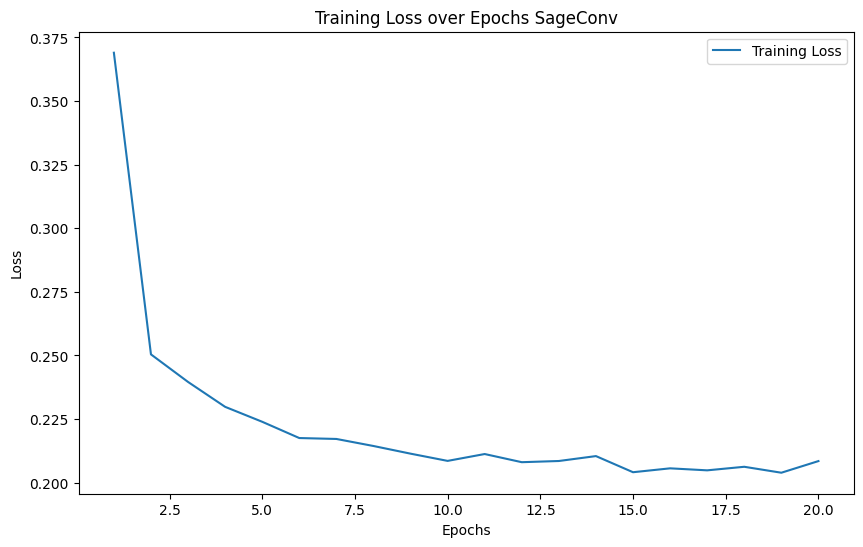

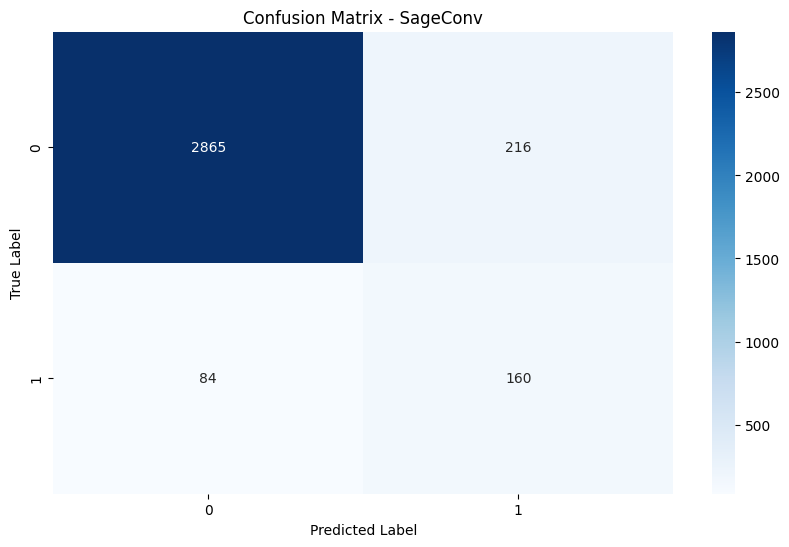

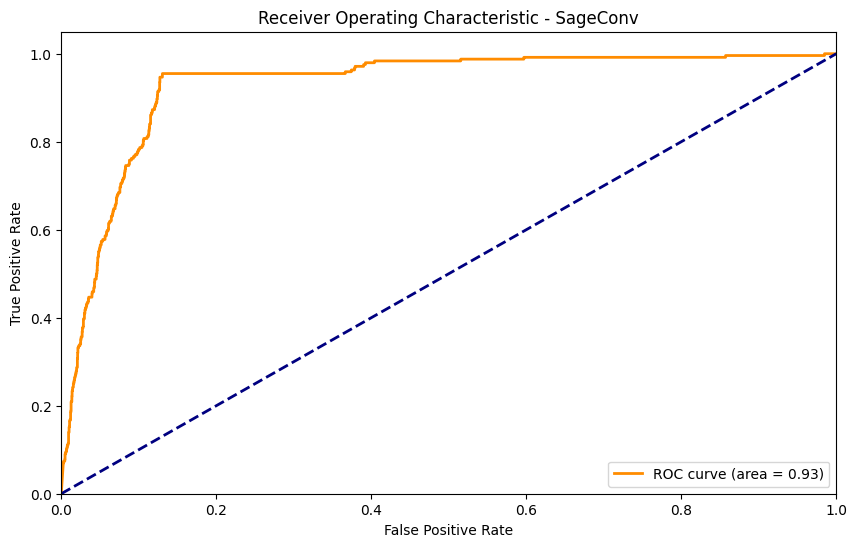

Epoch 1, Loss: 0.5938572572625201
Epoch 2, Loss: 0.4608339881119521
Epoch 3, Loss: 0.44962727991135226
Epoch 4, Loss: 0.43033970876232436
Epoch 5, Loss: 0.4183208273480768
Epoch 6, Loss: 0.3991119113305341
Epoch 7, Loss: 0.3821118407599304
Epoch 8, Loss: 0.3639333886296853
Epoch 9, Loss: 0.34958265543631883
Epoch 10, Loss: 0.33959865189440874
Epoch 11, Loss: 0.3335164689823337
Epoch 12, Loss: 0.329213106761808
Epoch 13, Loss: 0.33018506237346196
Epoch 14, Loss: 0.3246967478290848
Epoch 15, Loss: 0.326023832935354
Epoch 16, Loss: 0.3217715711697288
Epoch 17, Loss: 0.3231000023205643
Epoch 18, Loss: 0.32120418062676553
Epoch 19, Loss: 0.3234535685699919
Epoch 20, Loss: 0.32208148357660876


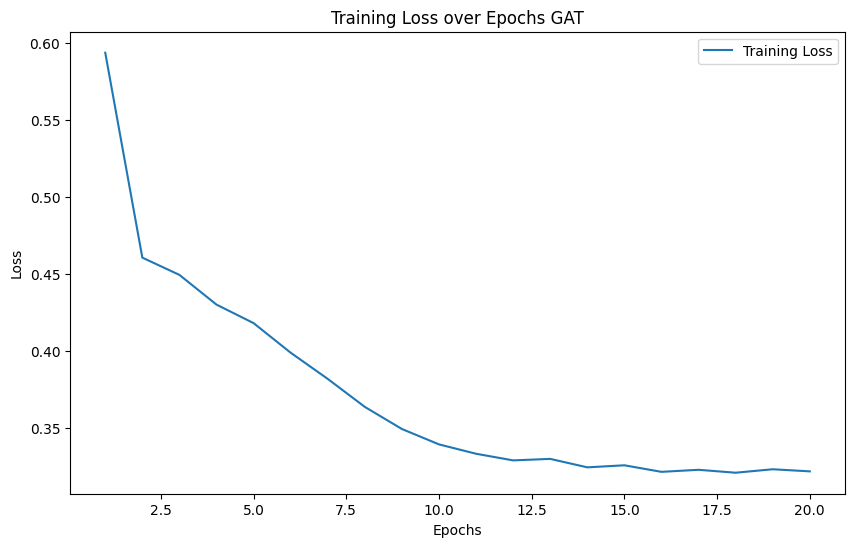

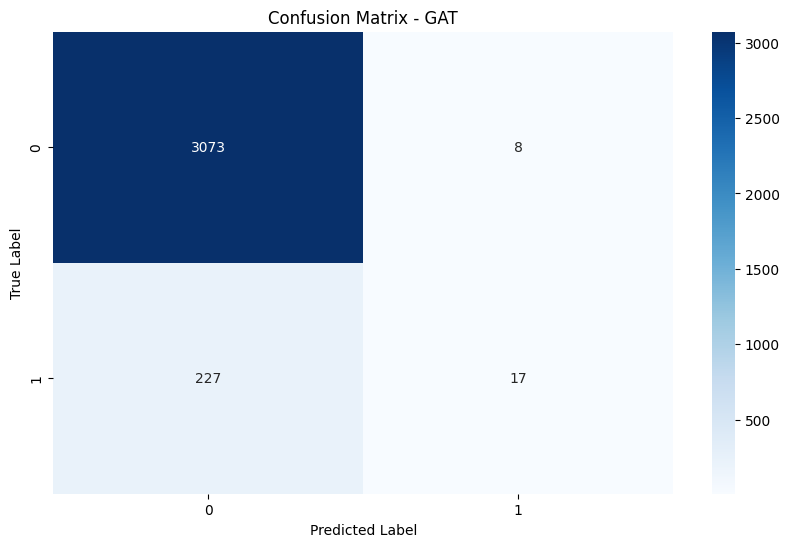

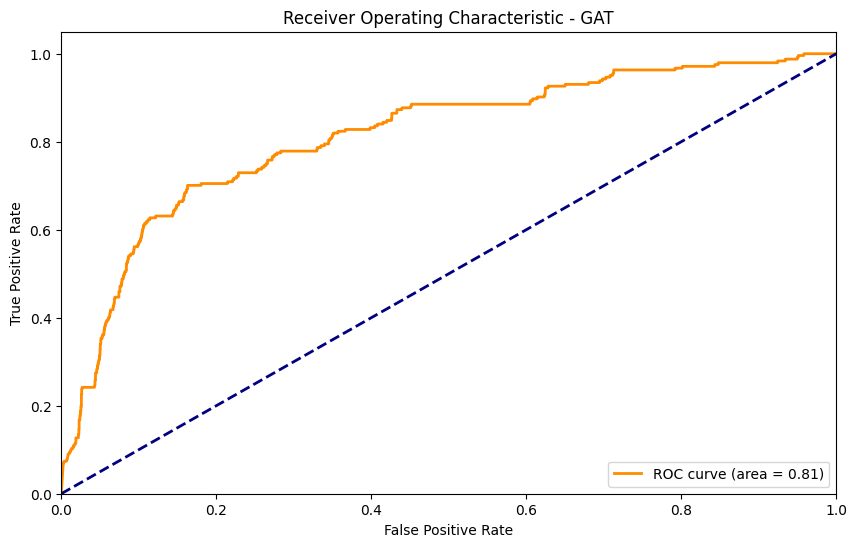

Epoch 1, Loss: 0.359681197533222
Epoch 2, Loss: 0.24611473164480666
Epoch 3, Loss: 0.24949408399508052
Epoch 4, Loss: 0.23249301500618458
Epoch 5, Loss: 0.23243021373839481
Epoch 6, Loss: 0.22354181637258633
Epoch 7, Loss: 0.22912663820645082
Epoch 8, Loss: 0.21999918377917746
Epoch 9, Loss: 0.22207433349736358
Epoch 10, Loss: 0.22067792219636234
Epoch 11, Loss: 0.2207998306207035
Epoch 12, Loss: 0.21551162814316543
Epoch 13, Loss: 0.2114452509128529
Epoch 14, Loss: 0.21414252427285133
Epoch 15, Loss: 0.21510530902963618
Epoch 16, Loss: 0.2137665795567243
Epoch 17, Loss: 0.21177482896524927
Epoch 18, Loss: 0.2116932429211295
Epoch 19, Loss: 0.21042334928136805
Epoch 20, Loss: 0.20930264153234338


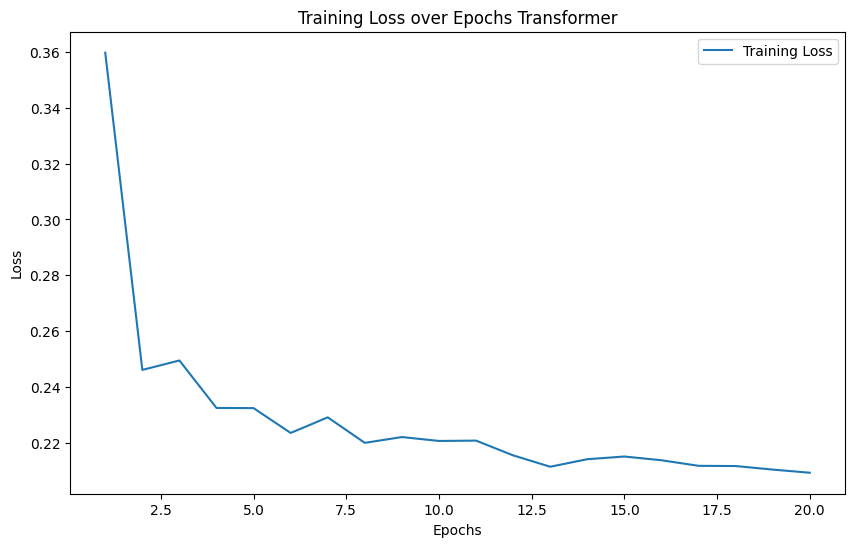

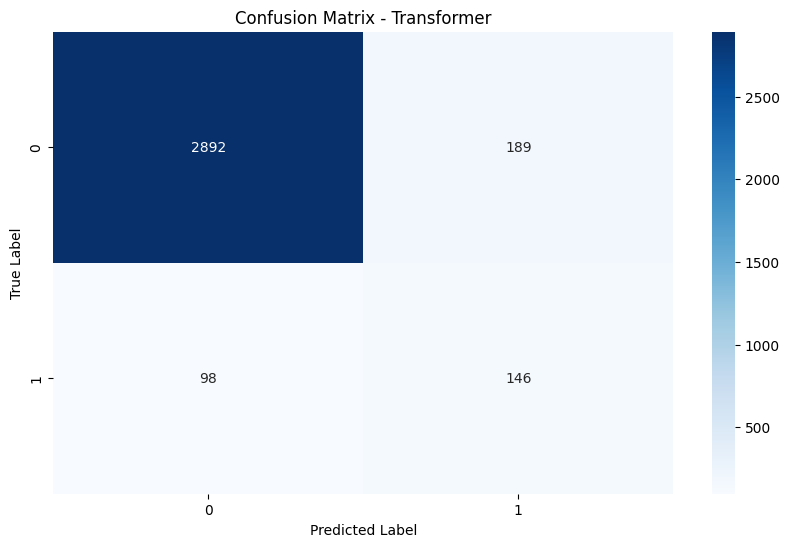

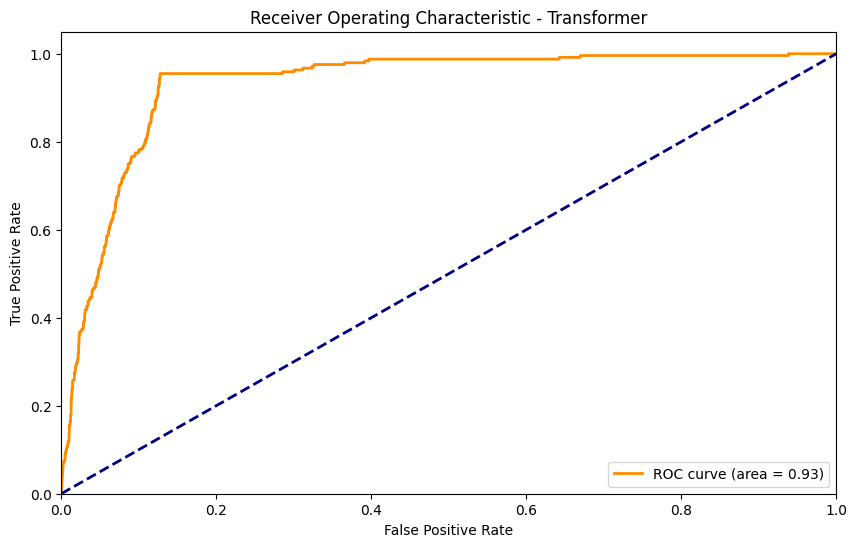

Epoch 1, Loss: 0.600385717075804
Epoch 2, Loss: 0.4873099942570147
Epoch 3, Loss: 0.45385612968517386
Epoch 4, Loss: 0.41716949544523074
Epoch 5, Loss: 0.38245113955243776
Epoch 6, Loss: 0.3534898103579231
Epoch 7, Loss: 0.33570624402035837
Epoch 8, Loss: 0.3264178338906039
Epoch 9, Loss: 0.3219092575752217
Epoch 10, Loss: 0.31603022462323954
Epoch 11, Loss: 0.31165305824707384
Epoch 12, Loss: 0.31431711861944717
Epoch 13, Loss: 0.3111850822587376
Epoch 14, Loss: 0.3113215331636045
Epoch 15, Loss: 0.3086820708830719
Epoch 16, Loss: 0.3125155824843956
Epoch 17, Loss: 0.307685406230714
Epoch 18, Loss: 0.3077313291799763
Epoch 19, Loss: 0.3071016008439271
Epoch 20, Loss: 0.30411904143250507


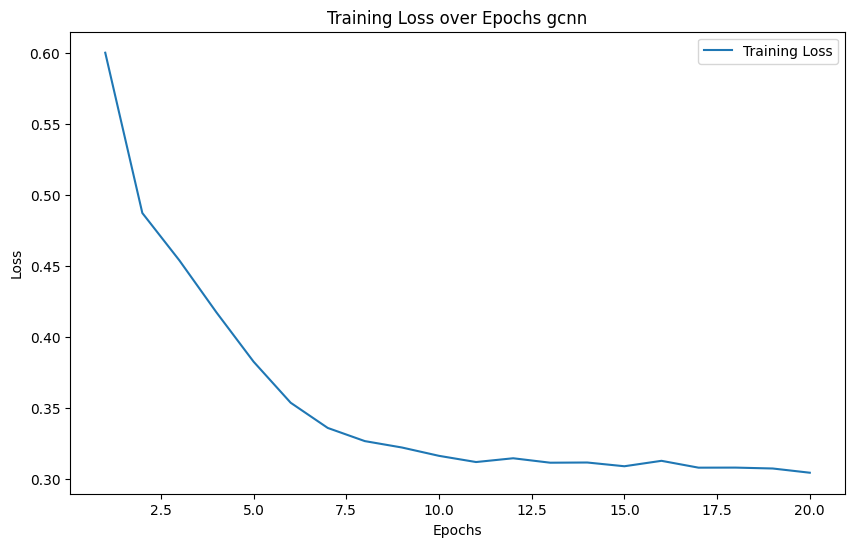

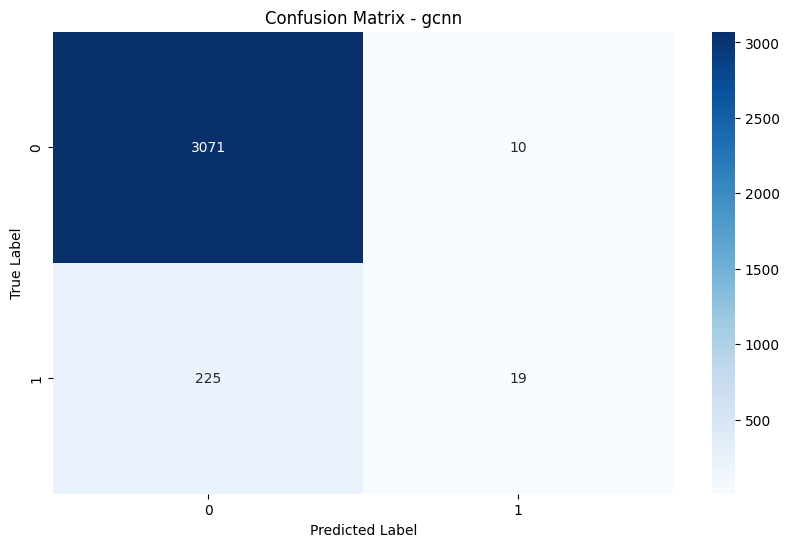

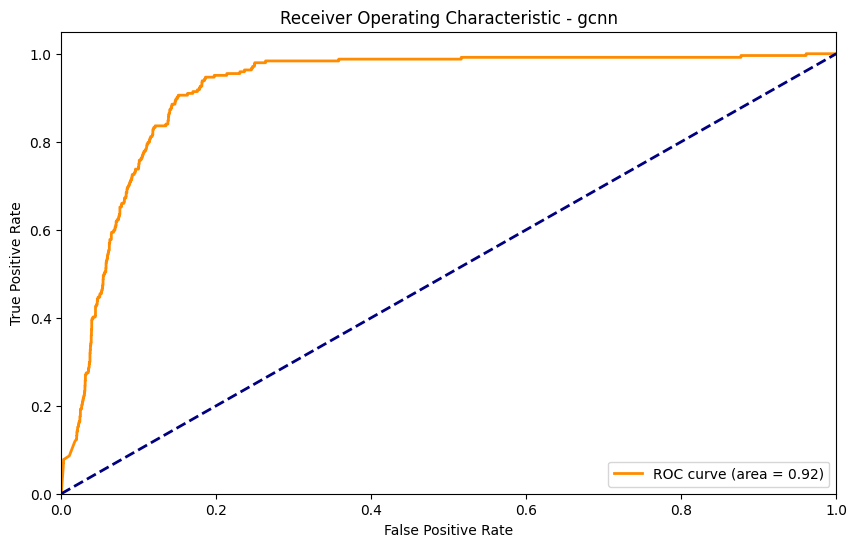

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}}
type1_label_


100%|██████████| 2079/2079 [02:50<00:00, 12.21it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.6403107338625452
Epoch 2, Loss: 0.371696264118604
Epoch 3, Loss: 0.33741812594234943
Epoch 4, Loss: 0.31642338115236035
Epoch 5, Loss: 0.3068768867170033
Epoch 6, Loss: 0.30032013081338094
Epoch 7, Loss: 0.30404226036499377
Epoch 8, Loss: 0.3001452554827151
Epoch 9, Loss: 0.293427693941023
Epoch 10, Loss: 0.29779529838782287
Epoch 11, Loss: 0.2930115101777989
Epoch 12, Loss: 0.2918753853958586
Epoch 13, Loss: 0.2895581267126229
Epoch 14, Loss: 0.2943393897427165
Epoch 15, Loss: 0.2889913650148589
Epoch 16, Loss: 0.2967321090400219
Epoch 17, Loss: 0.2908072479717109
Epoch 18, Loss: 0.2922117281705141
Epoch 19, Loss: 0.2928429602280907
Epoch 20, Loss: 0.2880207778804976


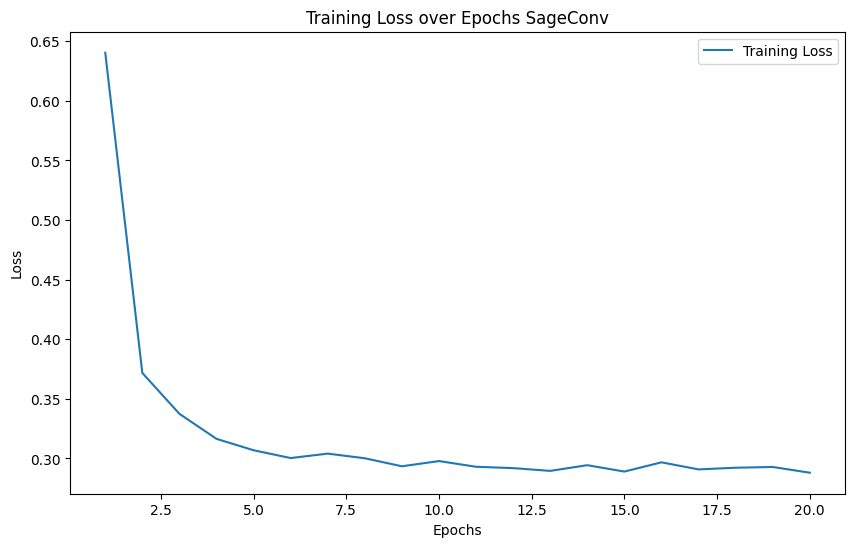

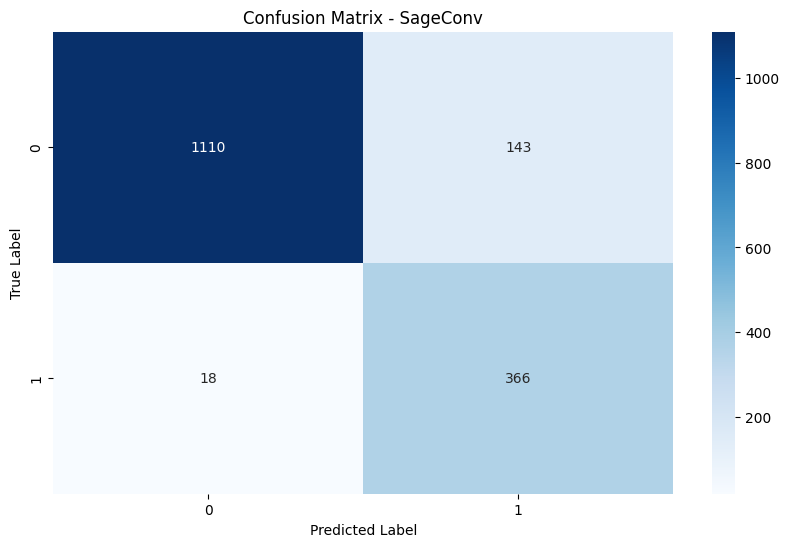

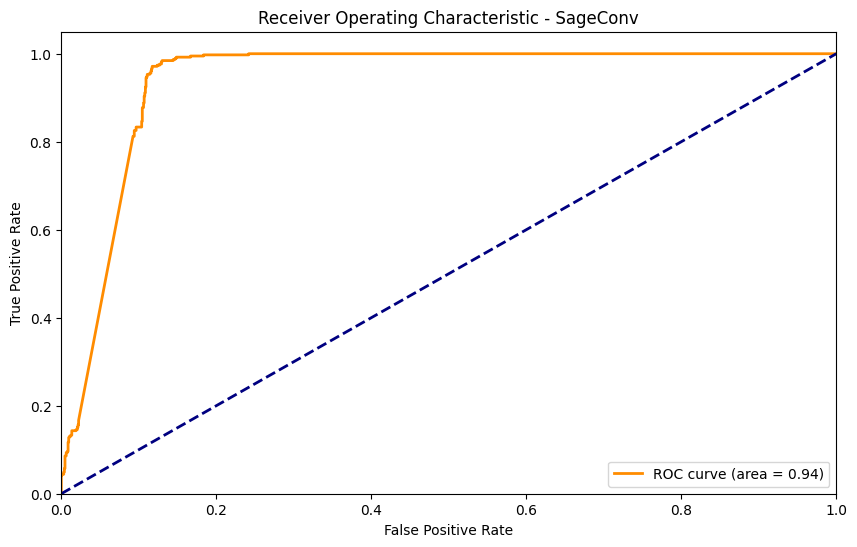

Epoch 1, Loss: 0.6757187389809153
Epoch 2, Loss: 0.5769789918609287
Epoch 3, Loss: 0.4837821106547895
Epoch 4, Loss: 0.45606117744160735
Epoch 5, Loss: 0.44994000734194467
Epoch 6, Loss: 0.4494682393320229
Epoch 7, Loss: 0.4519928886514643
Epoch 8, Loss: 0.44916546215181763
Epoch 9, Loss: 0.44463190679316933
Epoch 10, Loss: 0.44571463569350867
Epoch 11, Loss: 0.4427081858334334
Epoch 12, Loss: 0.441152800846359
Epoch 13, Loss: 0.4401400622142398
Epoch 14, Loss: 0.4416098523399104
Epoch 15, Loss: 0.44355176081476005
Epoch 16, Loss: 0.4413299732234167
Epoch 17, Loss: 0.4394909167743247
Epoch 18, Loss: 0.4398740965711034
Epoch 19, Loss: 0.4412105634160664
Epoch 20, Loss: 0.43830588719119196


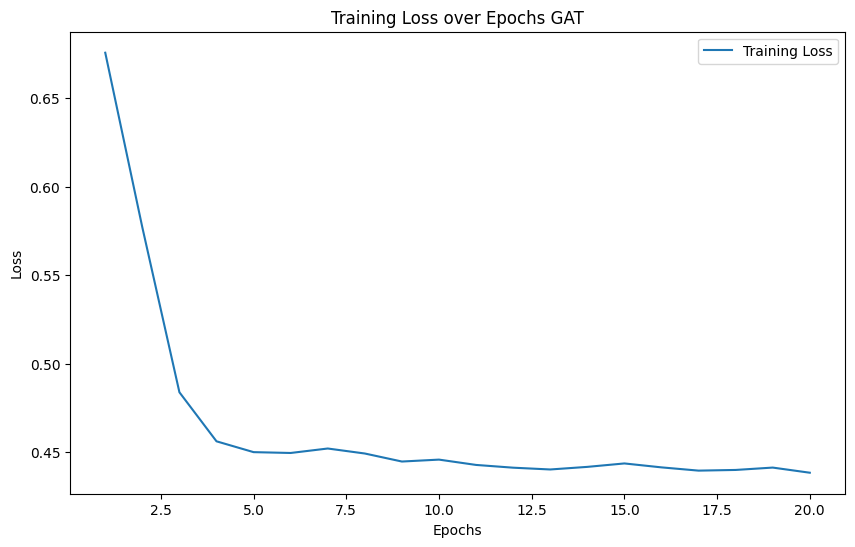

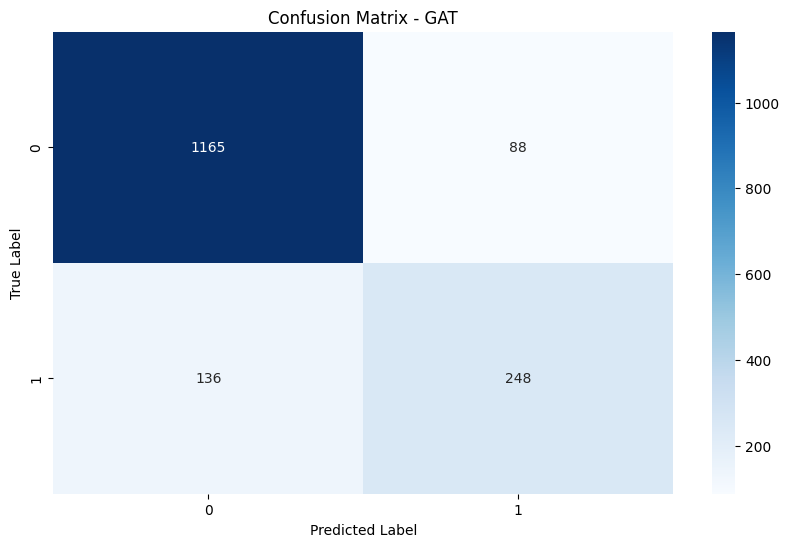

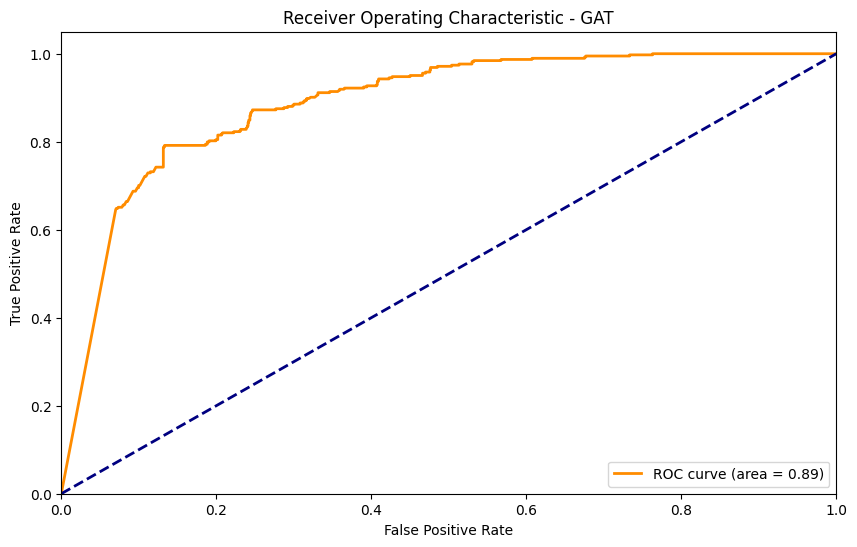

Epoch 1, Loss: 0.7622880395906775
Epoch 2, Loss: 0.361482370806777
Epoch 3, Loss: 0.3389991963201243
Epoch 4, Loss: 0.32250936037820316
Epoch 5, Loss: 0.3184012836250274
Epoch 6, Loss: 0.31748480455059075
Epoch 7, Loss: 0.30772146210074425
Epoch 8, Loss: 0.3094581621496574
Epoch 9, Loss: 0.30064589165798994
Epoch 10, Loss: 0.2973287016477274
Epoch 11, Loss: 0.29890025787703367
Epoch 12, Loss: 0.29427551907365734
Epoch 13, Loss: 0.29076777277109417
Epoch 14, Loss: 0.2932489451182925
Epoch 15, Loss: 0.2902288687941821
Epoch 16, Loss: 0.2931449131878174
Epoch 17, Loss: 0.2885351833765921
Epoch 18, Loss: 0.29100076797539776
Epoch 19, Loss: 0.29001193971413636
Epoch 20, Loss: 0.2903732122124537


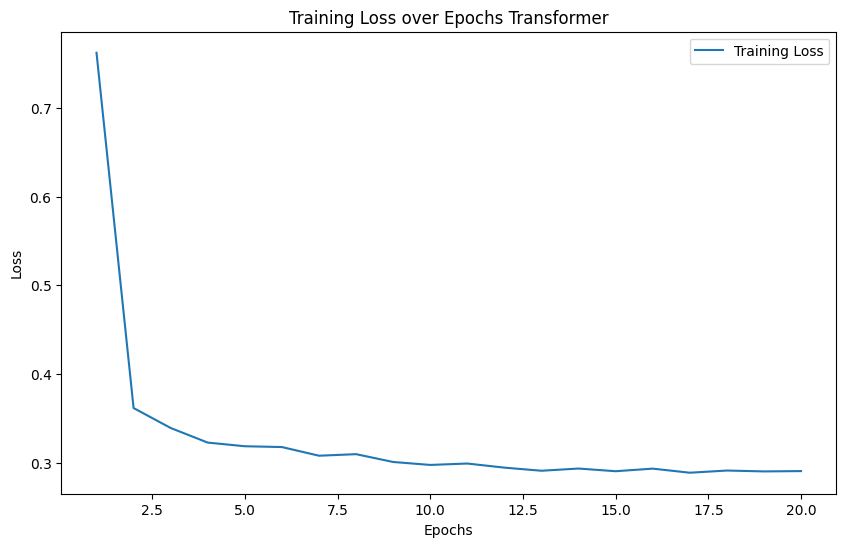

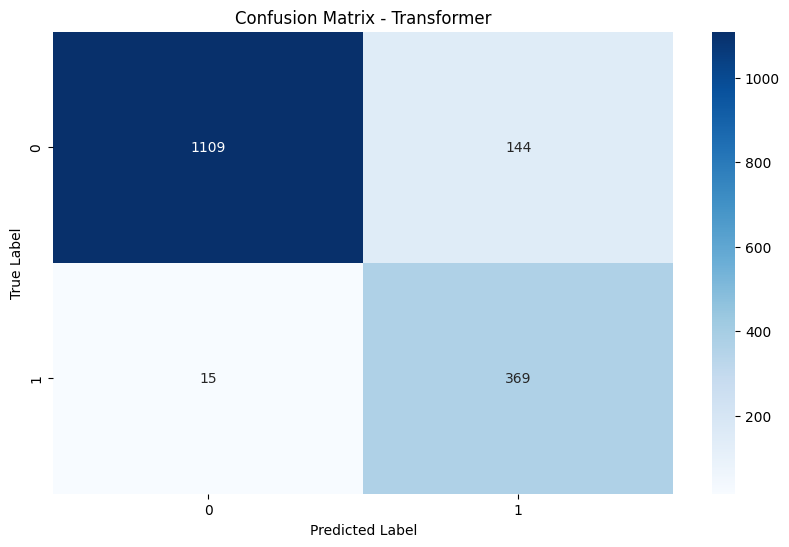

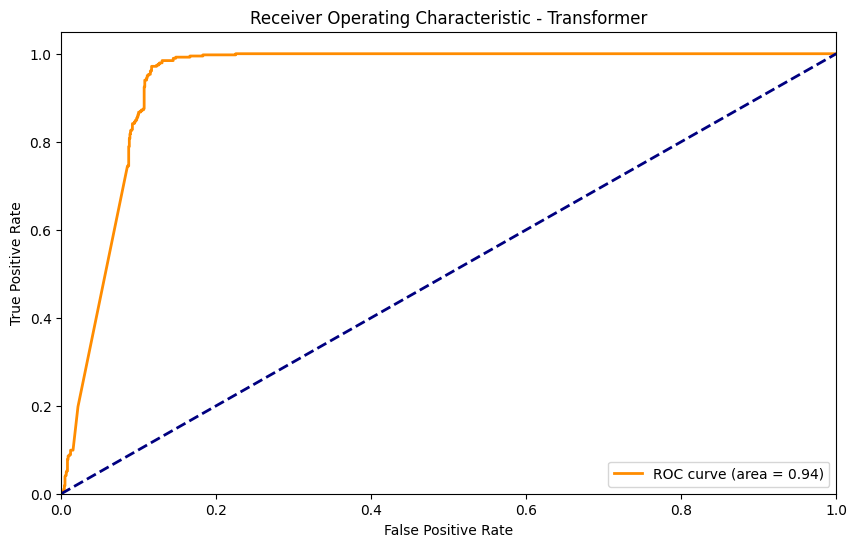

Epoch 1, Loss: 0.6803149231102156
Epoch 2, Loss: 0.568537576690964
Epoch 3, Loss: 0.472226837730926
Epoch 4, Loss: 0.4567190711588963
Epoch 5, Loss: 0.4495388308297033
Epoch 6, Loss: 0.4487096524756888
Epoch 7, Loss: 0.44394872110822925
Epoch 8, Loss: 0.45240232737168024
Epoch 9, Loss: 0.4464595970576224
Epoch 10, Loss: 0.4438041105218556
Epoch 11, Loss: 0.44406280877149623
Epoch 12, Loss: 0.44532576851222827
Epoch 13, Loss: 0.4458282554279203
Epoch 14, Loss: 0.44050760194659233
Epoch 15, Loss: 0.44031674900780554
Epoch 16, Loss: 0.4396460807841757
Epoch 17, Loss: 0.4420835631697074
Epoch 18, Loss: 0.4388932049598383
Epoch 19, Loss: 0.44115378270330635
Epoch 20, Loss: 0.44289161426865536


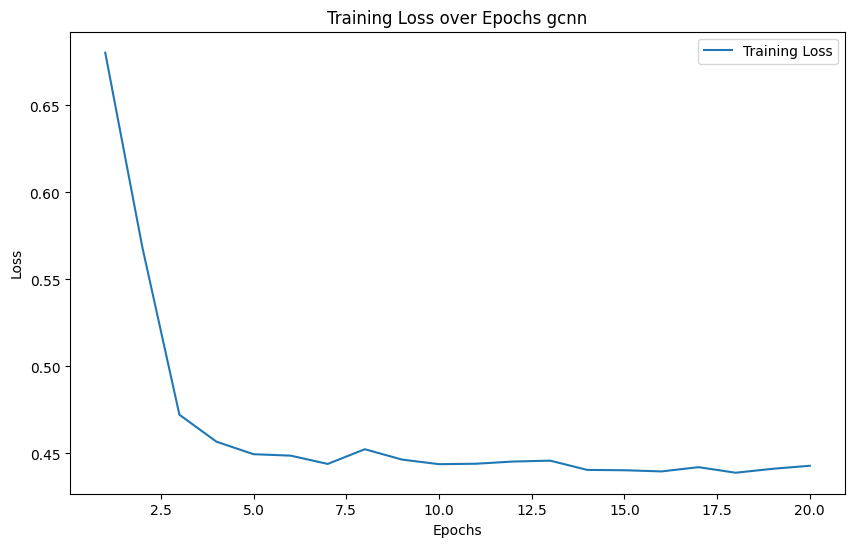

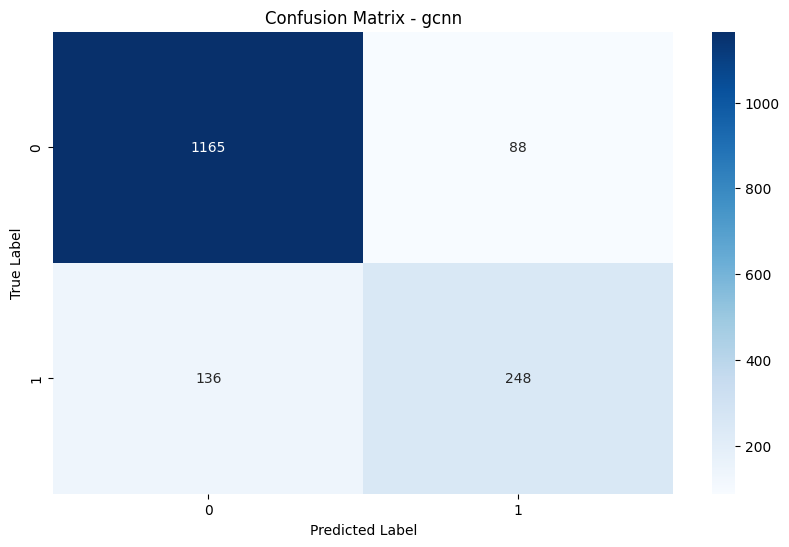

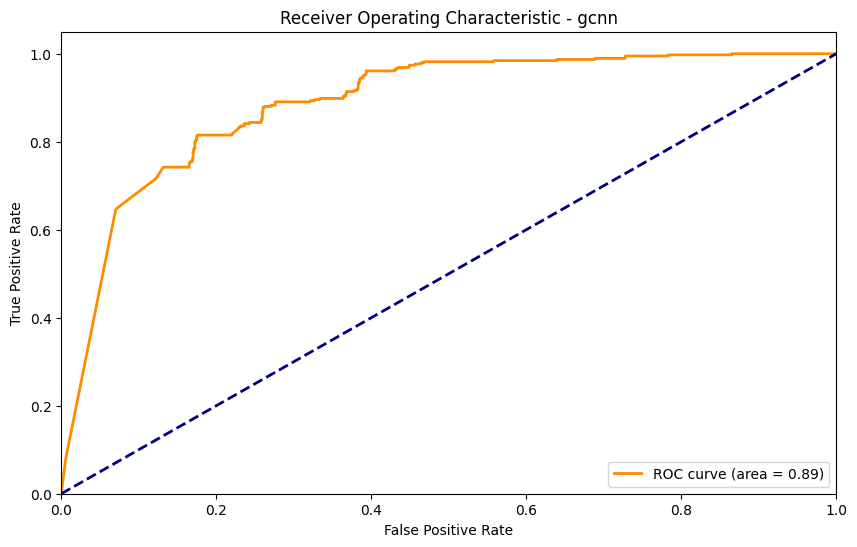

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}}
type2_label_


100%|██████████| 1342/1342 [02:04<00:00, 10.80it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.2822584104413787
Epoch 2, Loss: 0.19347387179732323
Epoch 3, Loss: 0.1606410000473261
Epoch 4, Loss: 0.15177934697518747
Epoch 5, Loss: 0.15173572028676668
Epoch 6, Loss: 0.14455817273507515
Epoch 7, Loss: 0.14633578509092332
Epoch 8, Loss: 0.14160453863441944
Epoch 9, Loss: 0.13948340515295665
Epoch 10, Loss: 0.13622149731963873
Epoch 11, Loss: 0.13764855898916722
Epoch 12, Loss: 0.13688950029512245
Epoch 13, Loss: 0.1368529222905636
Epoch 14, Loss: 0.1361594927807649
Epoch 15, Loss: 0.13553790679822367
Epoch 16, Loss: 0.13401729470739762
Epoch 17, Loss: 0.13379657069842021
Epoch 18, Loss: 0.1343692975739638
Epoch 19, Loss: 0.13302672679225605
Epoch 20, Loss: 0.1340761948376894


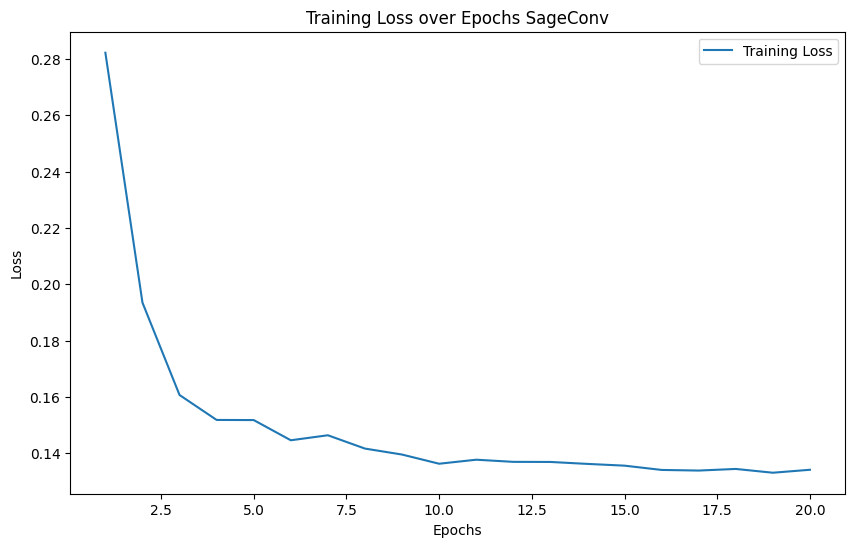

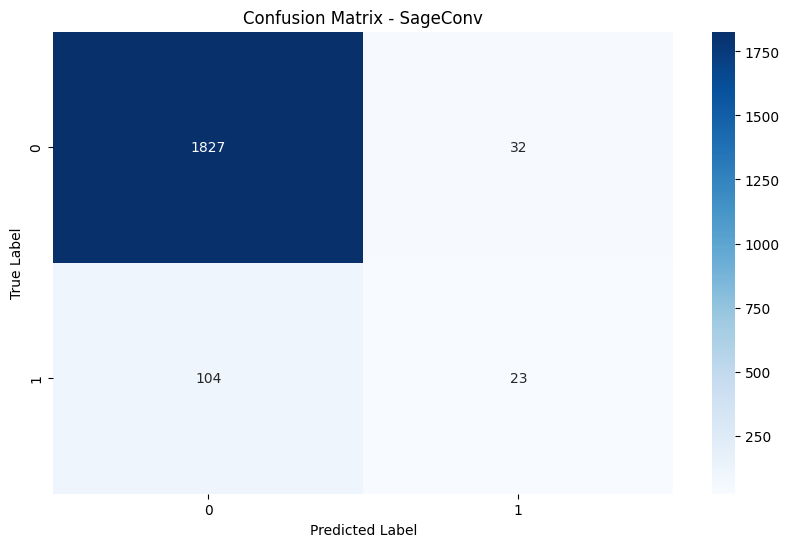

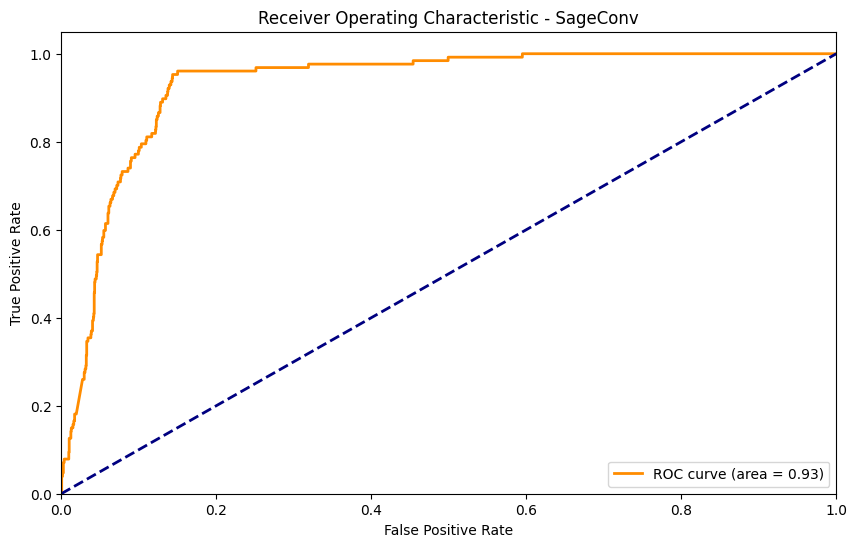

Epoch 1, Loss: 0.46685358236233393
Epoch 2, Loss: 0.27014805463453134
Epoch 3, Loss: 0.245013398428758
Epoch 4, Loss: 0.2459686423341433
Epoch 5, Loss: 0.240634685754776
Epoch 6, Loss: 0.23635066598653792
Epoch 7, Loss: 0.2331378746777773
Epoch 8, Loss: 0.23097081556916238
Epoch 9, Loss: 0.22921269610524178
Epoch 10, Loss: 0.22395125490923723
Epoch 11, Loss: 0.22224233796199164
Epoch 12, Loss: 0.2202904686331749
Epoch 13, Loss: 0.21692207232117652
Epoch 14, Loss: 0.21621376946568488
Epoch 15, Loss: 0.21681335493922232
Epoch 16, Loss: 0.21240795602401097
Epoch 17, Loss: 0.21220835633575916
Epoch 18, Loss: 0.2113132902731498
Epoch 19, Loss: 0.21313266269862652
Epoch 20, Loss: 0.21088022602101167


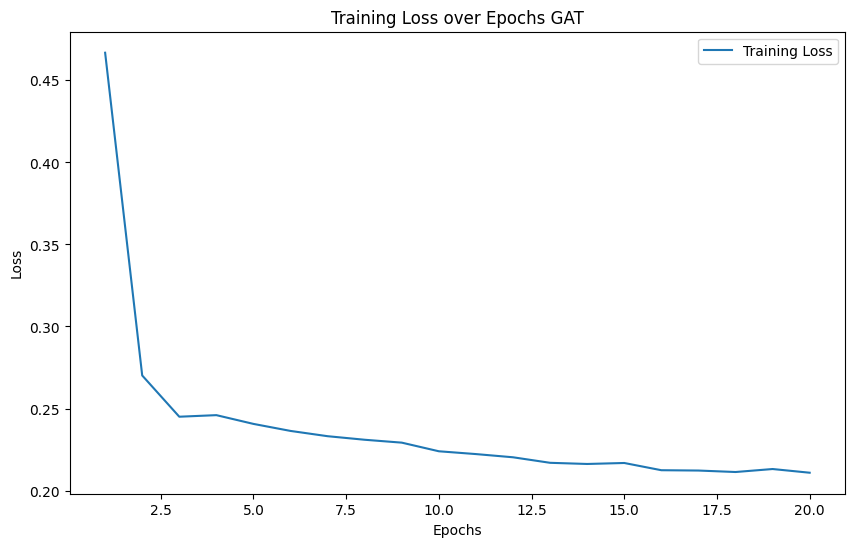

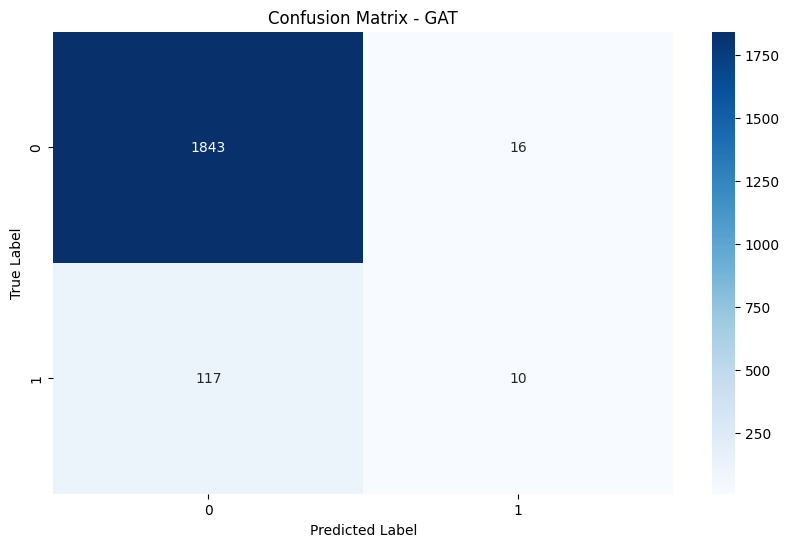

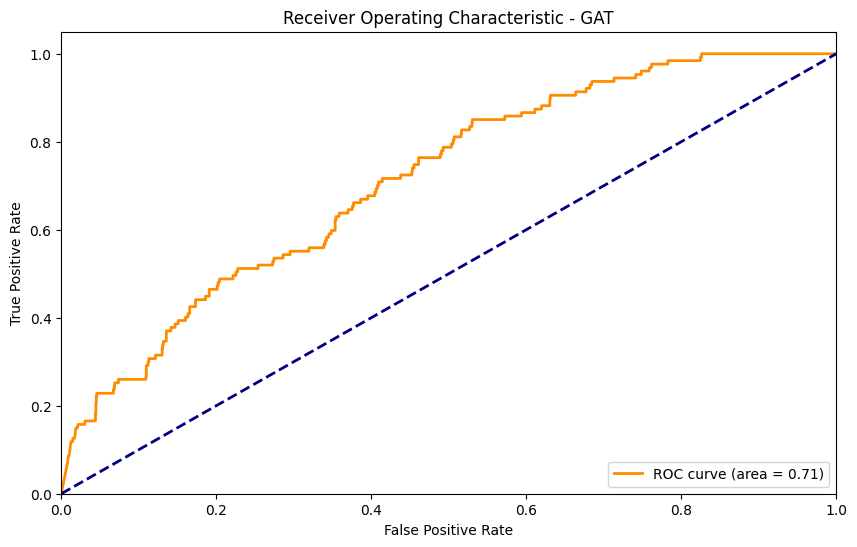

Epoch 1, Loss: 0.2912973833580812
Epoch 2, Loss: 0.20815281967322033
Epoch 3, Loss: 0.16823416656504075
Epoch 4, Loss: 0.1591535609215498
Epoch 5, Loss: 0.15578312346090872
Epoch 6, Loss: 0.15193870949248472
Epoch 7, Loss: 0.1499026800195376
Epoch 8, Loss: 0.1474348643173774
Epoch 9, Loss: 0.14364362526684998
Epoch 10, Loss: 0.14057328576842945
Epoch 11, Loss: 0.1423659090573589
Epoch 12, Loss: 0.1423073148354888
Epoch 13, Loss: 0.14052429950485626
Epoch 14, Loss: 0.14033226612955332
Epoch 15, Loss: 0.1383784094825387
Epoch 16, Loss: 0.13992765781780084
Epoch 17, Loss: 0.13863472267985344
Epoch 18, Loss: 0.13668071056405703
Epoch 19, Loss: 0.13767347068836291
Epoch 20, Loss: 0.13661436773836613


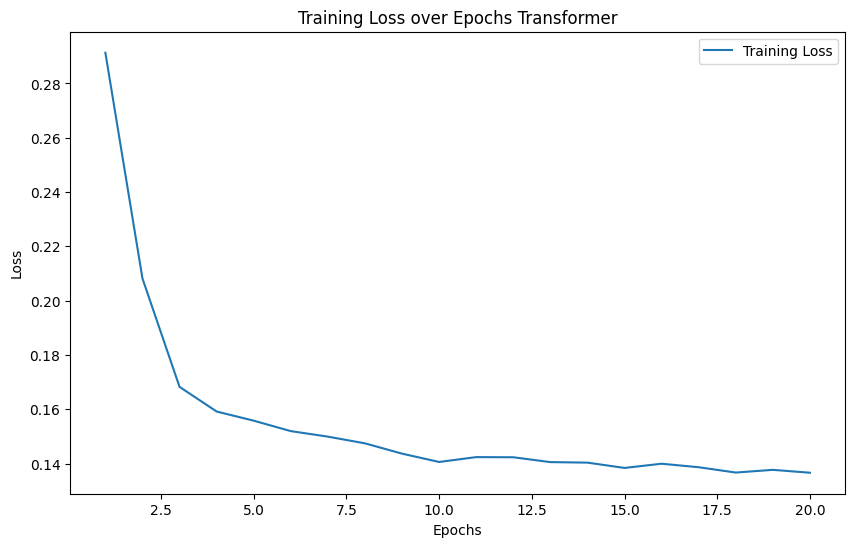

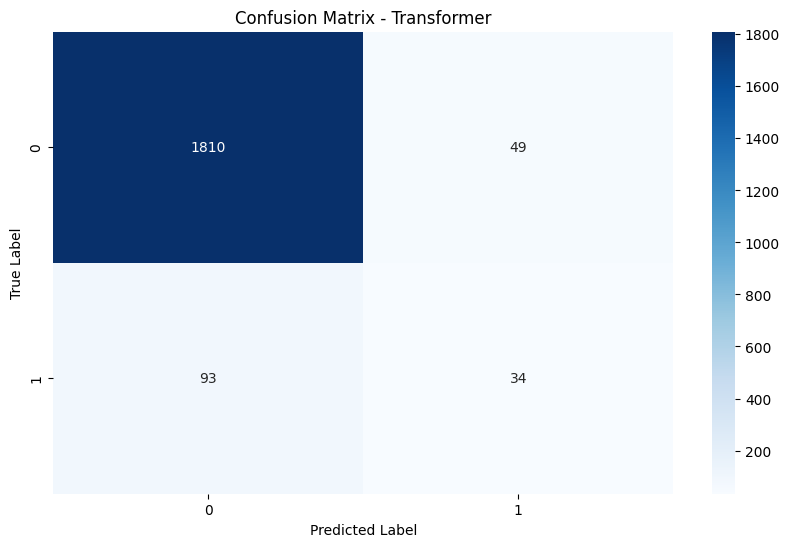

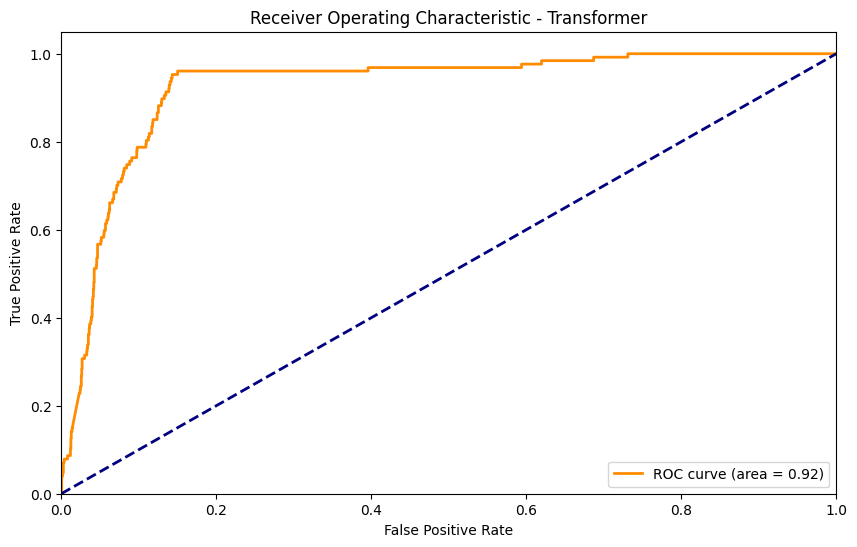

Epoch 1, Loss: 0.5563870007793109
Epoch 2, Loss: 0.2947364484270414
Epoch 3, Loss: 0.26968120808402696
Epoch 4, Loss: 0.26351516619324683
Epoch 5, Loss: 0.2580628521740437
Epoch 6, Loss: 0.2529448144137859
Epoch 7, Loss: 0.24855624089638392
Epoch 8, Loss: 0.24197269702951113
Epoch 9, Loss: 0.2378489926457405
Epoch 10, Loss: 0.23237451029320558
Epoch 11, Loss: 0.22633362809816995
Epoch 12, Loss: 0.22245667738219102
Epoch 13, Loss: 0.21956251338124275
Epoch 14, Loss: 0.2180598055322965
Epoch 15, Loss: 0.21636506443222364
Epoch 16, Loss: 0.21246502585709096
Epoch 17, Loss: 0.21310681141912938
Epoch 18, Loss: 0.21059900497396786
Epoch 19, Loss: 0.2093062234421571
Epoch 20, Loss: 0.20797147092719873


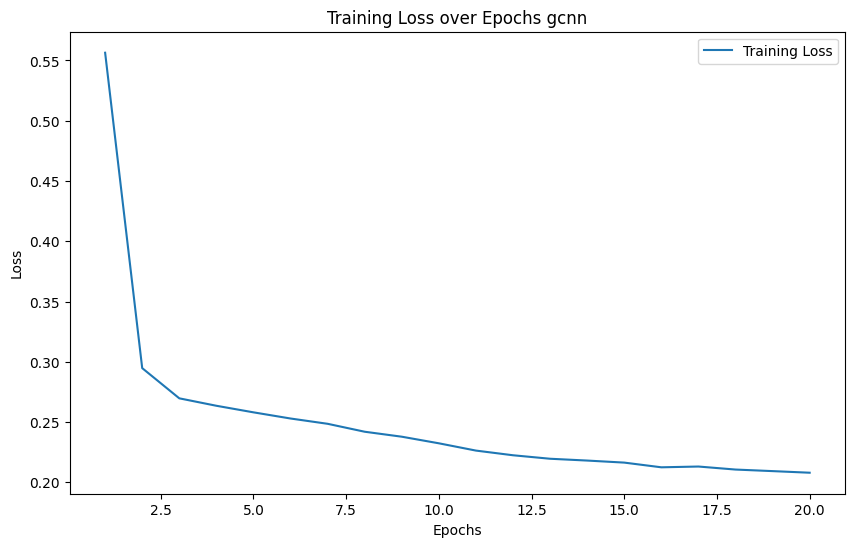

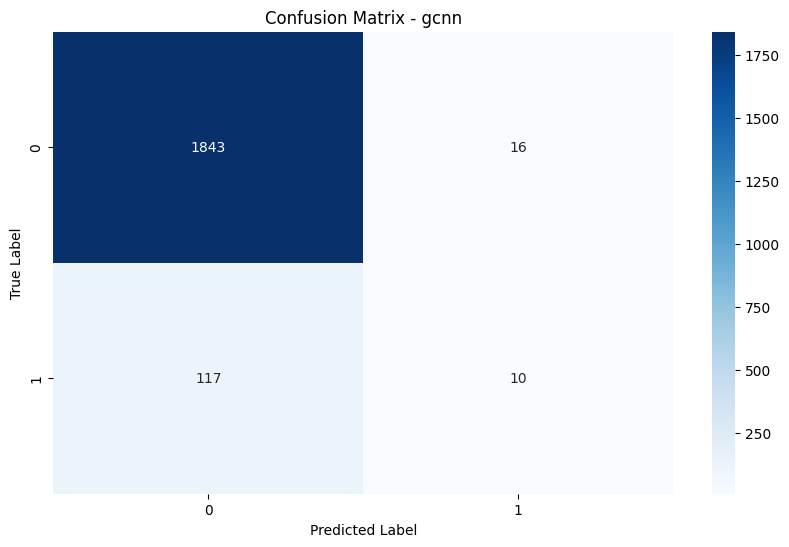

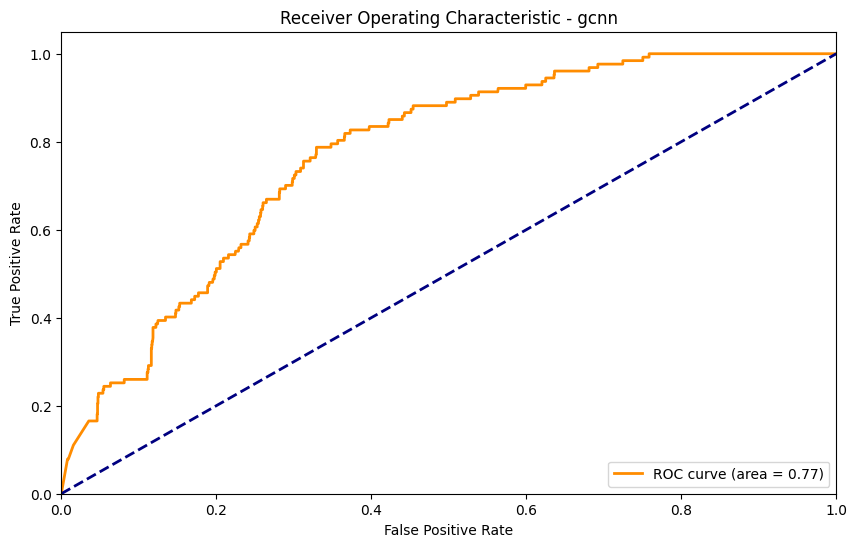

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}, 'type2_label_': {'GSageConv': 0.9315206445115811, 'GAT': 0.9330312185297079, 'GTransformer': 0.9284994964753273, 'GCNN': 0.9330312185297079}}
type3_label_


100%|██████████| 1975/1975 [02:49<00:00, 11.62it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.5339288538829847
Epoch 2, Loss: 0.2974749544466084
Epoch 3, Loss: 0.26830434308133344
Epoch 4, Loss: 0.254051297056404
Epoch 5, Loss: 0.2575846105305986
Epoch 6, Loss: 0.2459952011704445
Epoch 7, Loss: 0.24286205346950077
Epoch 8, Loss: 0.24183212119069966
Epoch 9, Loss: 0.24261200411075895
Epoch 10, Loss: 0.23747395470061086
Epoch 11, Loss: 0.23851221105591816
Epoch 12, Loss: 0.23907130177725444
Epoch 13, Loss: 0.23440593684261496
Epoch 14, Loss: 0.2366622004827315
Epoch 15, Loss: 0.23068005659363486
Epoch 16, Loss: 0.2354263930835507
Epoch 17, Loss: 0.22810021296820857
Epoch 18, Loss: 0.2336232200772925
Epoch 19, Loss: 0.23281381211497568
Epoch 20, Loss: 0.23274977361275392


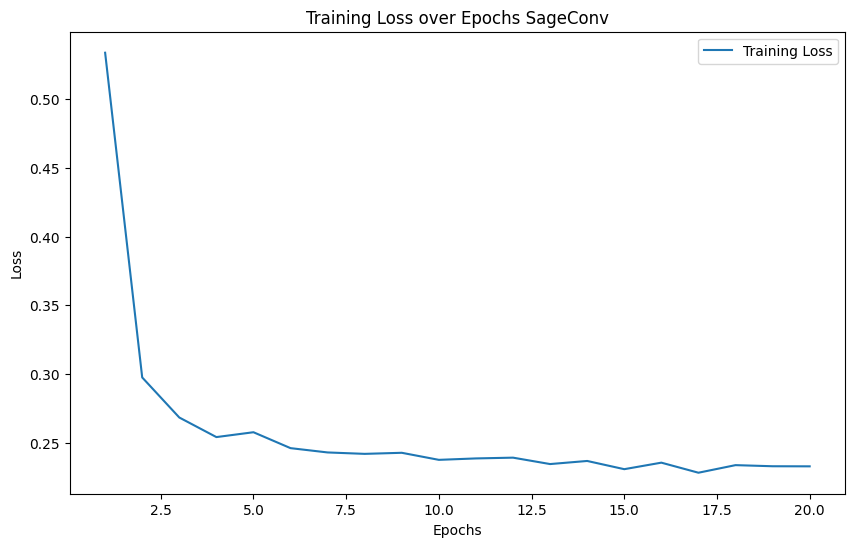

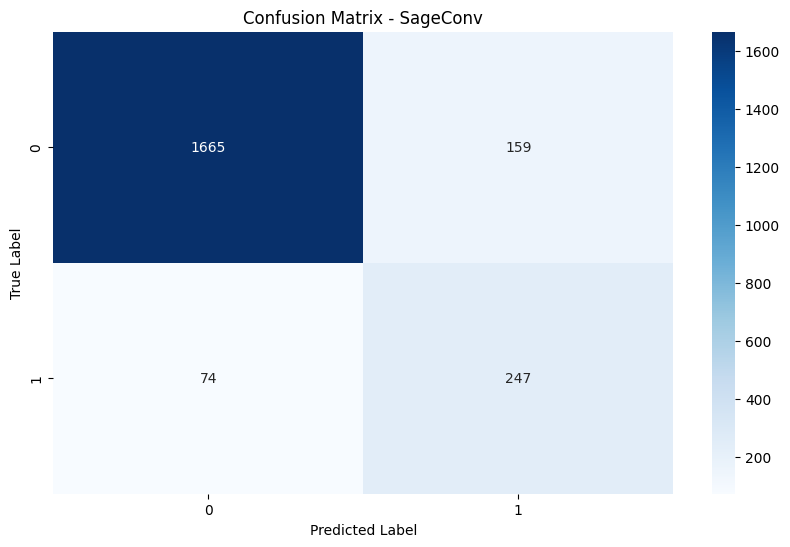

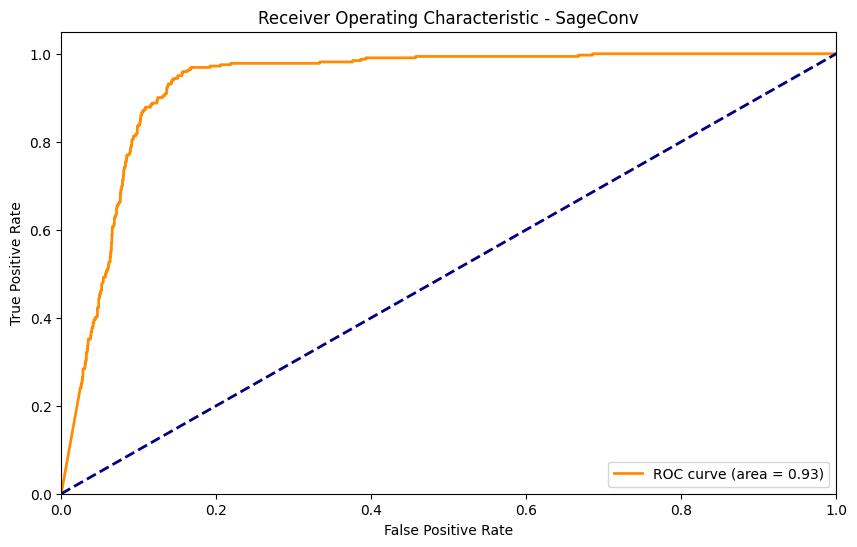

Epoch 1, Loss: 0.5965248468247327
Epoch 2, Loss: 0.5075747905807062
Epoch 3, Loss: 0.46261587942188437
Epoch 4, Loss: 0.42236287451603194
Epoch 5, Loss: 0.41060046411373397
Epoch 6, Loss: 0.4051319890740243
Epoch 7, Loss: 0.40209802155467594
Epoch 8, Loss: 0.4024374424056573
Epoch 9, Loss: 0.3984075059944933
Epoch 10, Loss: 0.3983212939717553
Epoch 11, Loss: 0.39712695811282506
Epoch 12, Loss: 0.3933513084934516
Epoch 13, Loss: 0.39381576905196364
Epoch 14, Loss: 0.3918072987686504
Epoch 15, Loss: 0.3945791970261119
Epoch 16, Loss: 0.39171428521248425
Epoch 17, Loss: 0.3906363629820672
Epoch 18, Loss: 0.3925483424893834
Epoch 19, Loss: 0.3873485953293063
Epoch 20, Loss: 0.38818425397303974


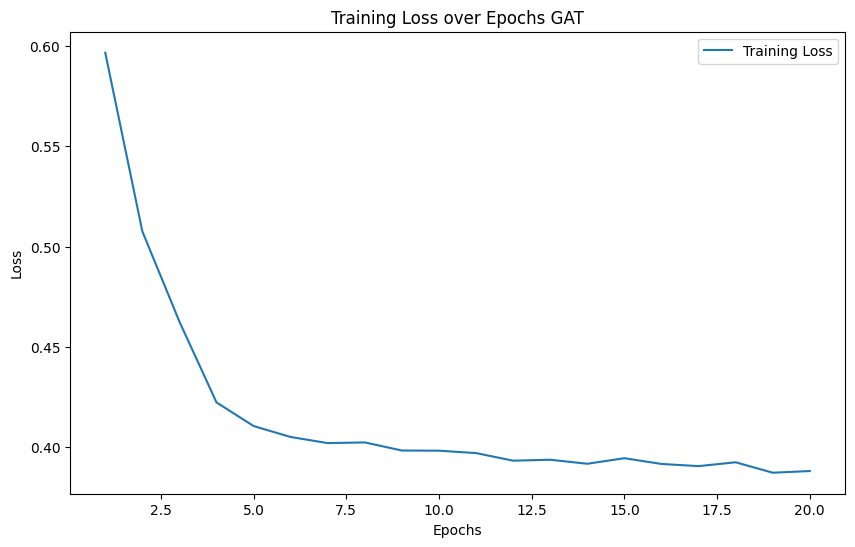

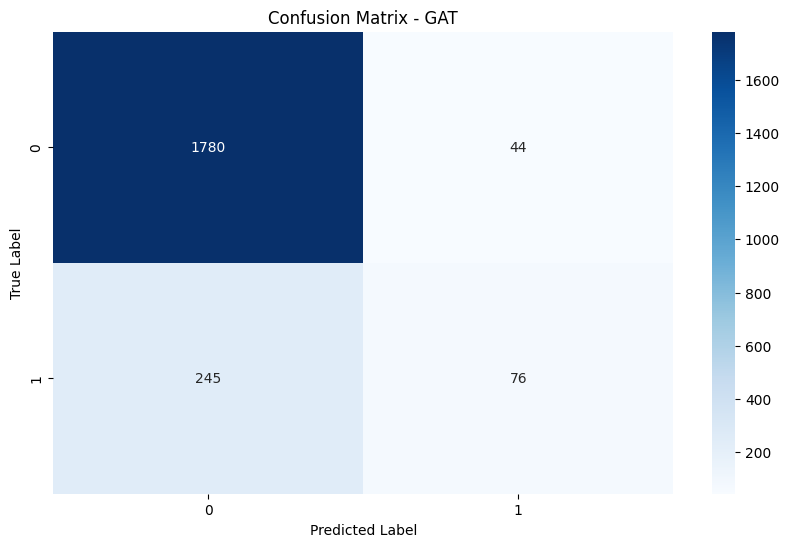

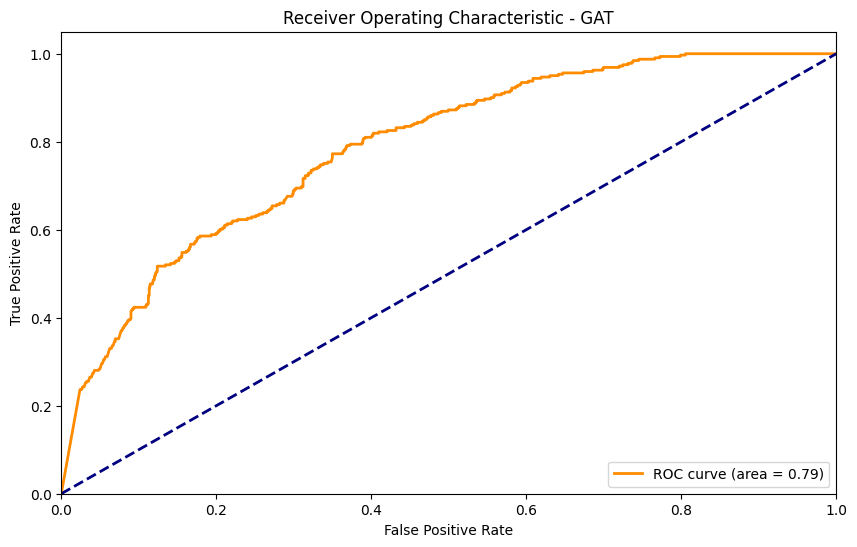

Epoch 1, Loss: 0.5762330872557041
Epoch 2, Loss: 0.3091378147629174
Epoch 3, Loss: 0.2735494197430936
Epoch 4, Loss: 0.2721974038603631
Epoch 5, Loss: 0.2664782902733846
Epoch 6, Loss: 0.25578285804526374
Epoch 7, Loss: 0.25769961083477194
Epoch 8, Loss: 0.24238873273134232
Epoch 9, Loss: 0.24815255860713395
Epoch 10, Loss: 0.24446548995646564
Epoch 11, Loss: 0.24061035779728132
Epoch 12, Loss: 0.24114404491741548
Epoch 13, Loss: 0.24200519623065536
Epoch 14, Loss: 0.23878269583325495
Epoch 15, Loss: 0.23721928547390483
Epoch 16, Loss: 0.23947348454120485
Epoch 17, Loss: 0.2383437886495482
Epoch 18, Loss: 0.23462664810093967
Epoch 19, Loss: 0.23608589155430143
Epoch 20, Loss: 0.23550998893651096


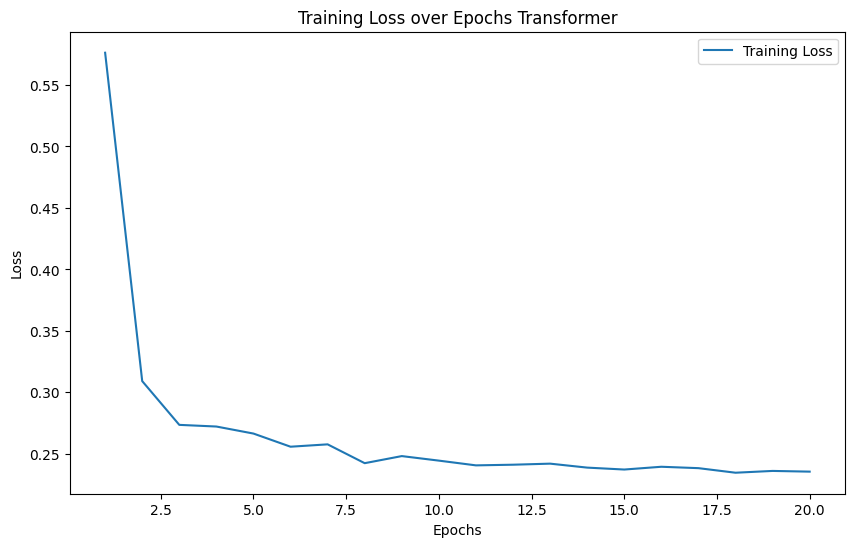

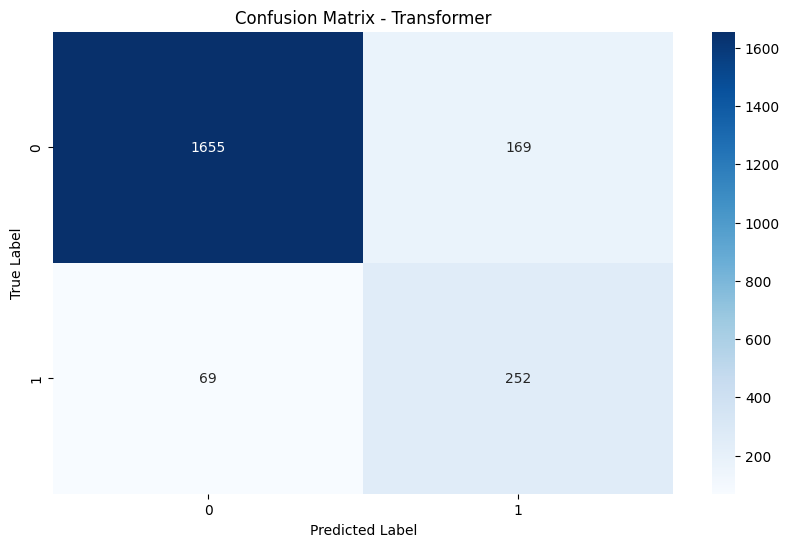

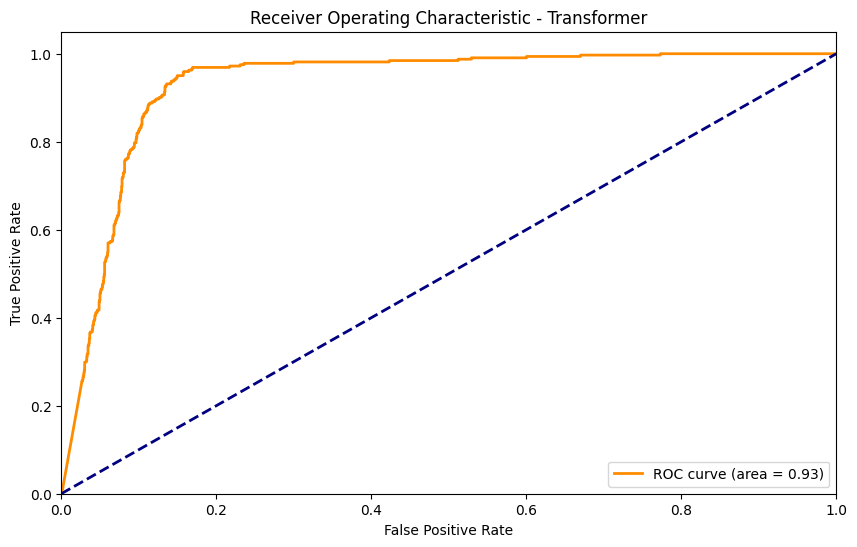

Epoch 1, Loss: 0.6259685192595829
Epoch 2, Loss: 0.5095903846350583
Epoch 3, Loss: 0.44622496650977567
Epoch 4, Loss: 0.41831598397005687
Epoch 5, Loss: 0.409495384009047
Epoch 6, Loss: 0.4007800165563822
Epoch 7, Loss: 0.3999394384974783
Epoch 8, Loss: 0.3971236058595506
Epoch 9, Loss: 0.39684380540116265
Epoch 10, Loss: 0.3968798248943957
Epoch 11, Loss: 0.39029174856841564
Epoch 12, Loss: 0.3895580114966089
Epoch 13, Loss: 0.3870474330403588
Epoch 14, Loss: 0.38538310304284096
Epoch 15, Loss: 0.38529369489035825
Epoch 16, Loss: 0.38339441134171054
Epoch 17, Loss: 0.3805333064361052
Epoch 18, Loss: 0.37943404489620164
Epoch 19, Loss: 0.38327845033596863
Epoch 20, Loss: 0.3828159492801536


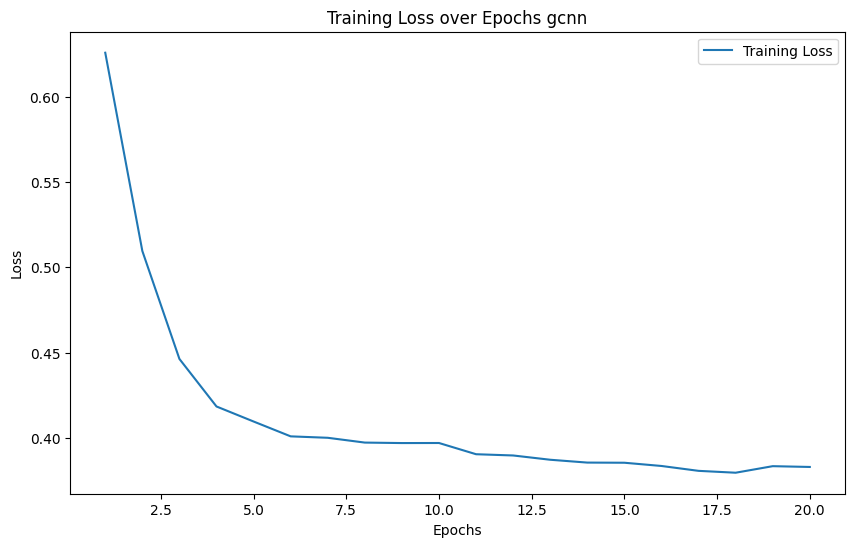

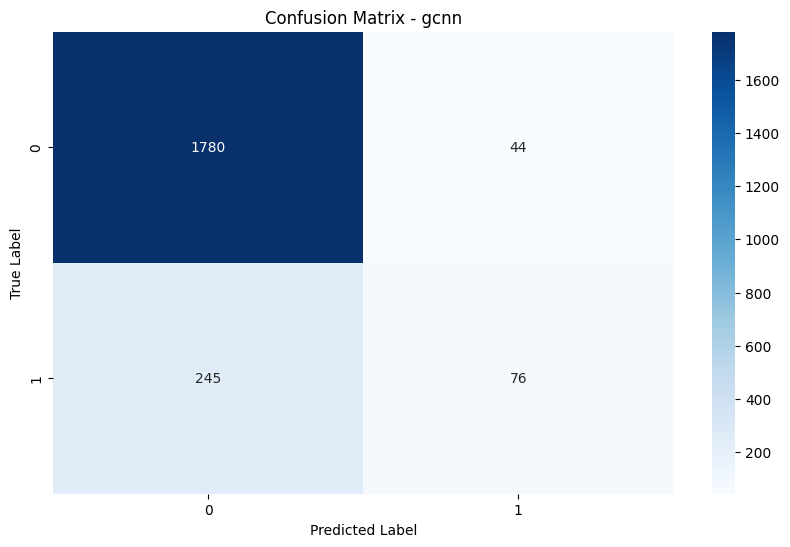

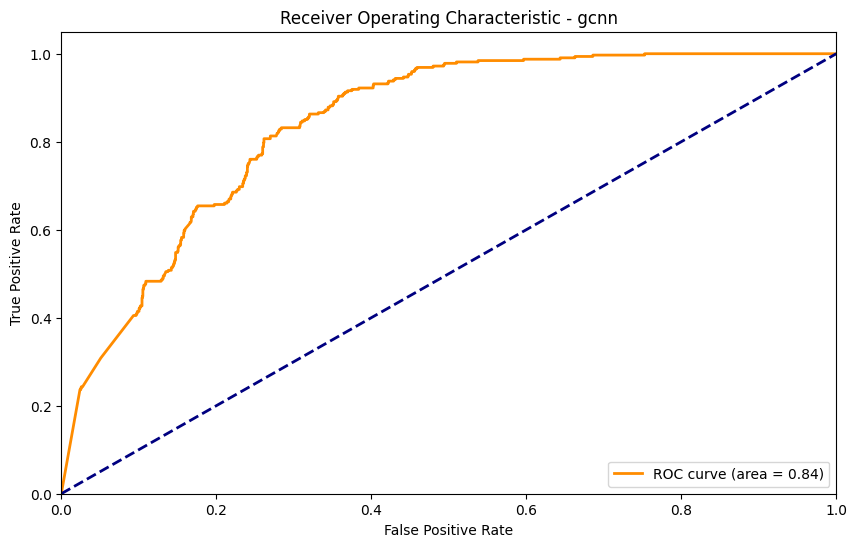

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}, 'type2_label_': {'GSageConv': 0.9315206445115811, 'GAT': 0.9330312185297079, 'GTransformer': 0.9284994964753273, 'GCNN': 0.9330312185297079}, 'type3_label_': {'GSageConv': 0.8913752913752914, 'GAT': 0.8652680652680653, 'GTransformer': 0.889044289044289, 'GCNN': 0.8652680652680653}}
type4_label_


100%|██████████| 1334/1334 [02:05<00:00, 10.59it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.2755864525834719
Epoch 2, Loss: 0.17036337653795877
Epoch 3, Loss: 0.1427332287033399
Epoch 4, Loss: 0.13334552956124146
Epoch 5, Loss: 0.13325324511776368
Epoch 6, Loss: 0.13291519576062757
Epoch 7, Loss: 0.12785104792565108
Epoch 8, Loss: 0.12692416117837033
Epoch 9, Loss: 0.12582531937708458
Epoch 10, Loss: 0.12416574557622274
Epoch 11, Loss: 0.12146403832981983
Epoch 12, Loss: 0.12294030313690503
Epoch 13, Loss: 0.12074863749245802
Epoch 14, Loss: 0.1208221735432744
Epoch 15, Loss: 0.12041862377276023
Epoch 16, Loss: 0.11843240335583687
Epoch 17, Loss: 0.11866715258608261
Epoch 18, Loss: 0.11843585552026828
Epoch 19, Loss: 0.11838737999399503
Epoch 20, Loss: 0.11778042229513327


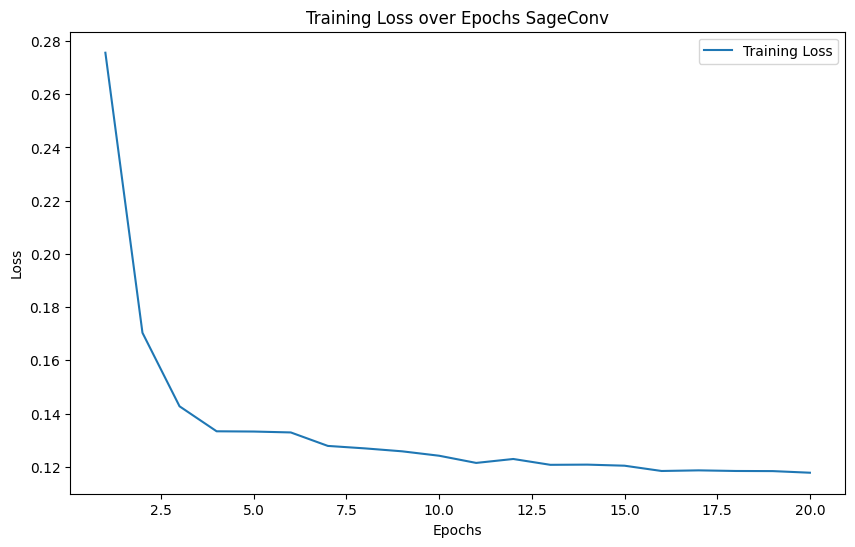

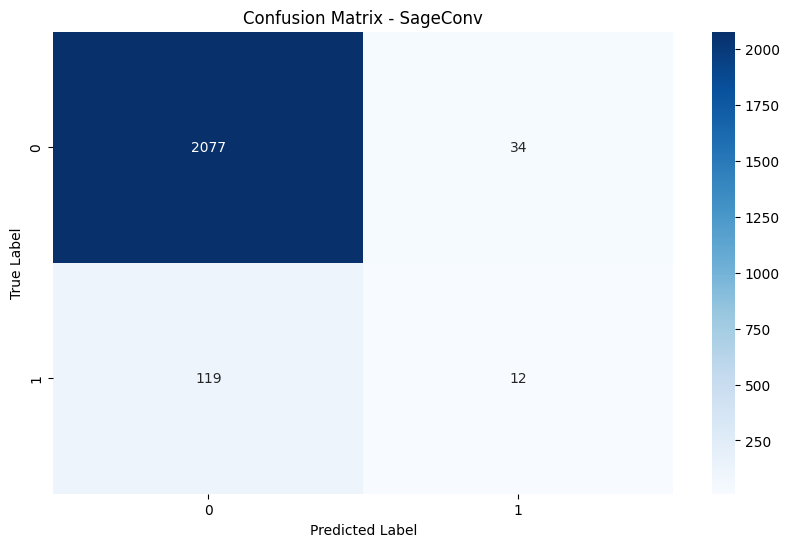

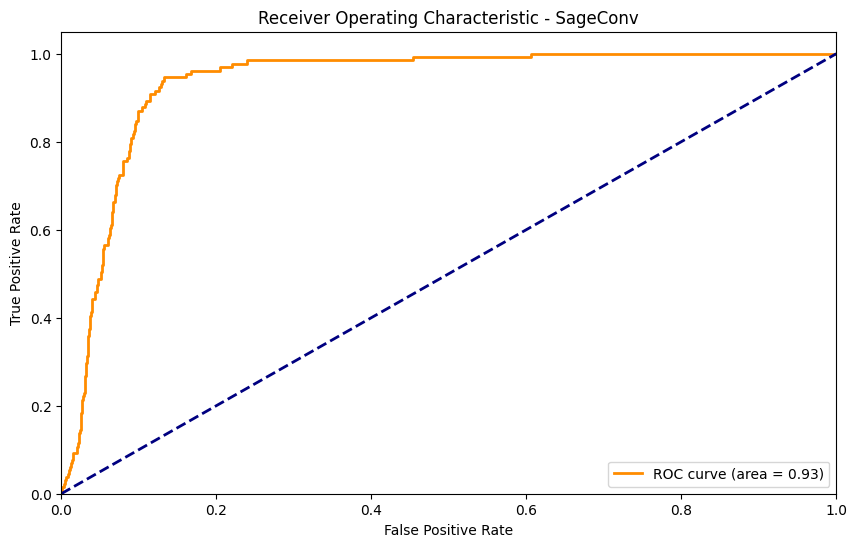

Epoch 1, Loss: 0.46286898901065193
Epoch 2, Loss: 0.22258160896599294
Epoch 3, Loss: 0.20295051870246728
Epoch 4, Loss: 0.2036818079650402
Epoch 5, Loss: 0.2012775739034017
Epoch 6, Loss: 0.20183194267253082
Epoch 7, Loss: 0.20034953877329825
Epoch 8, Loss: 0.20069753850499789
Epoch 9, Loss: 0.19983763806521893
Epoch 10, Loss: 0.19861035160720347
Epoch 11, Loss: 0.19693331296245256
Epoch 12, Loss: 0.19728607287009556
Epoch 13, Loss: 0.1975755151361227
Epoch 14, Loss: 0.19577763105432192
Epoch 15, Loss: 0.1961451372752587
Epoch 16, Loss: 0.19624247426788013
Epoch 17, Loss: 0.19582171278695265
Epoch 18, Loss: 0.1947976549466451
Epoch 19, Loss: 0.19459944752355415
Epoch 20, Loss: 0.19417574380834898


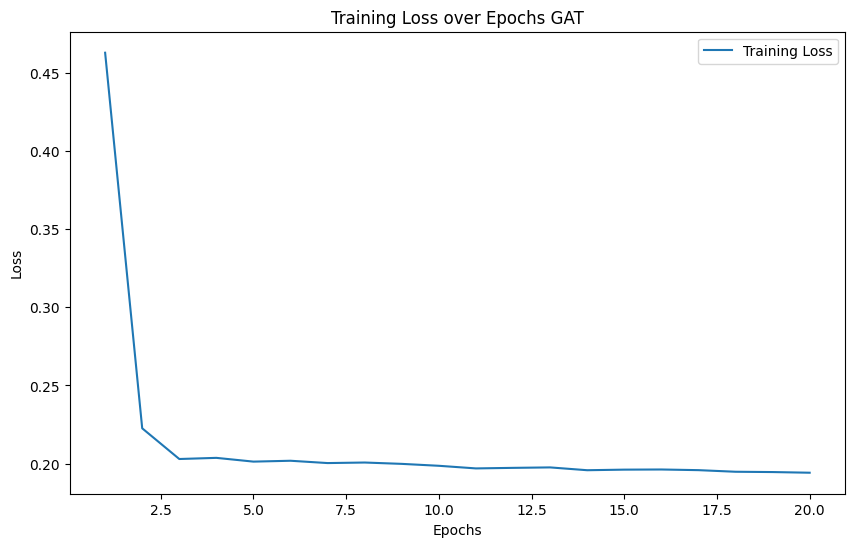

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

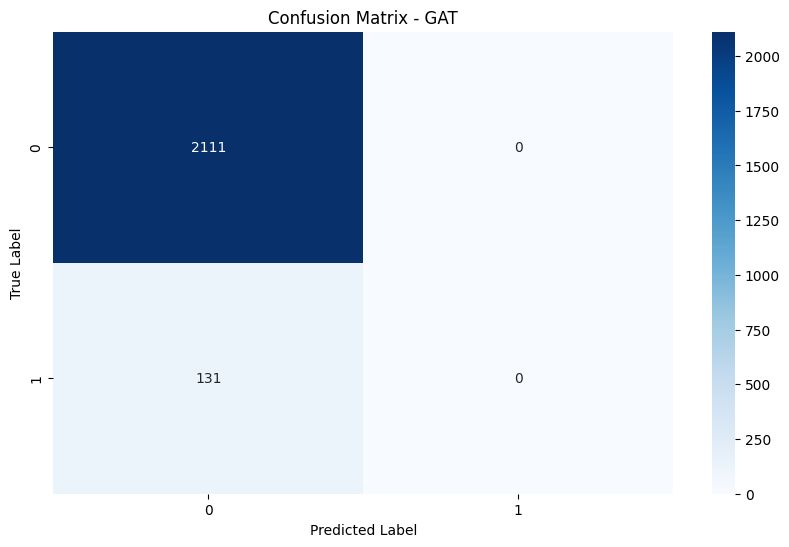

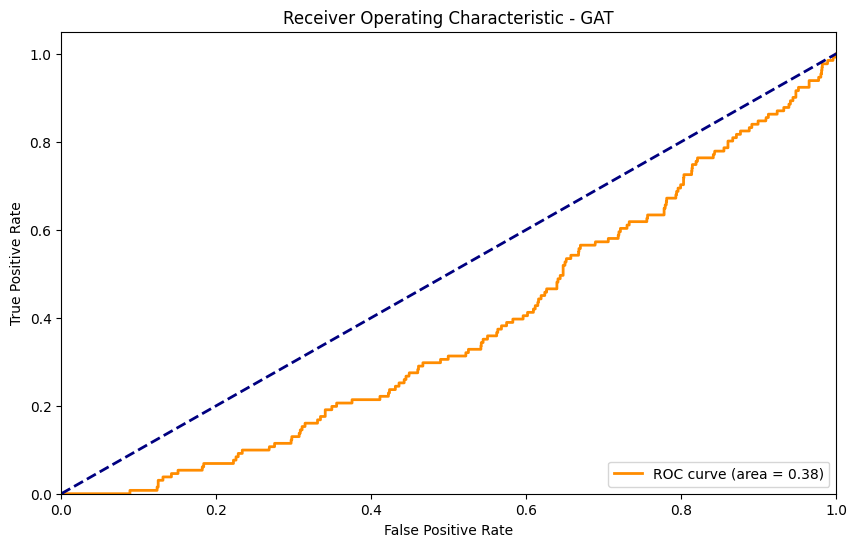

Epoch 1, Loss: 0.2940064049170663
Epoch 2, Loss: 0.1706268356492122
Epoch 3, Loss: 0.1498214190204938
Epoch 4, Loss: 0.14514089096337557
Epoch 5, Loss: 0.13992156541595857
Epoch 6, Loss: 0.13602157657345135
Epoch 7, Loss: 0.13828682769089937
Epoch 8, Loss: 0.13507472431908052
Epoch 9, Loss: 0.13556663220127424
Epoch 10, Loss: 0.12814577935884397
Epoch 11, Loss: 0.13033998937656482
Epoch 12, Loss: 0.12801323166737955
Epoch 13, Loss: 0.1270987485225002
Epoch 14, Loss: 0.12666559591889381
Epoch 15, Loss: 0.1271879783521096
Epoch 16, Loss: 0.12388010217497746
Epoch 17, Loss: 0.12649156134575607
Epoch 18, Loss: 0.12431327210118373
Epoch 19, Loss: 0.12247679817179839
Epoch 20, Loss: 0.1239752180253466


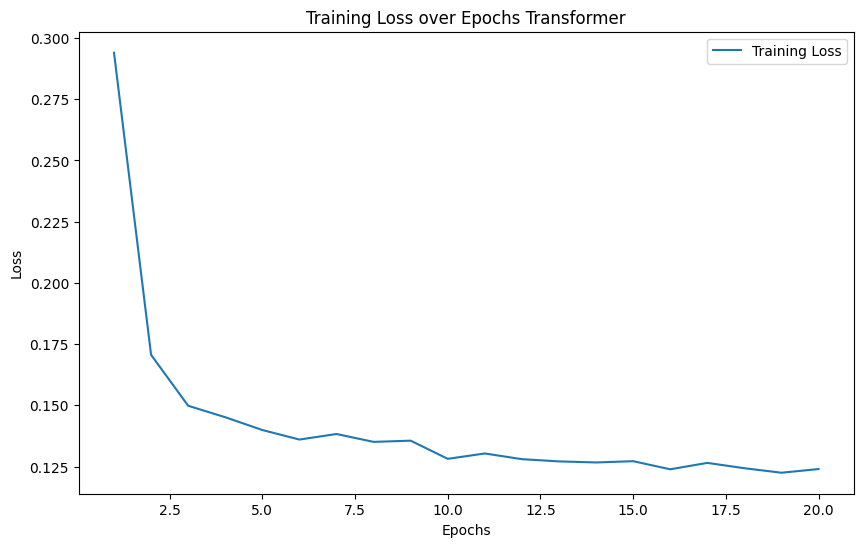

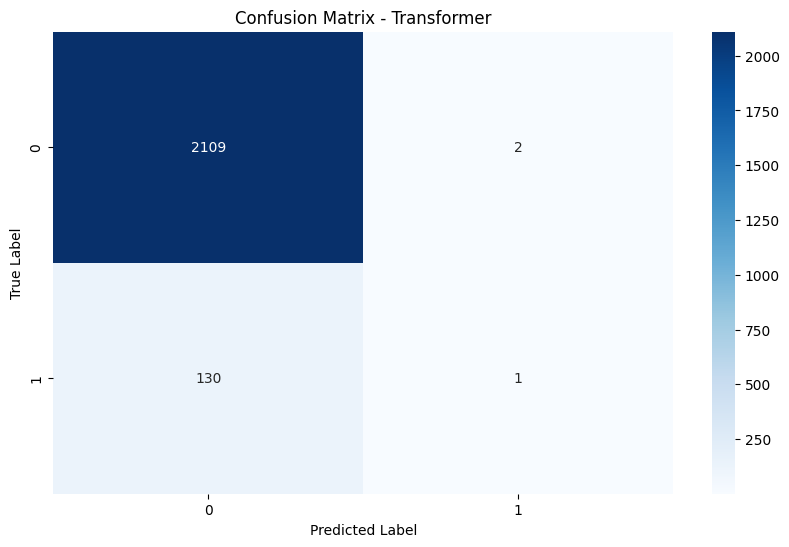

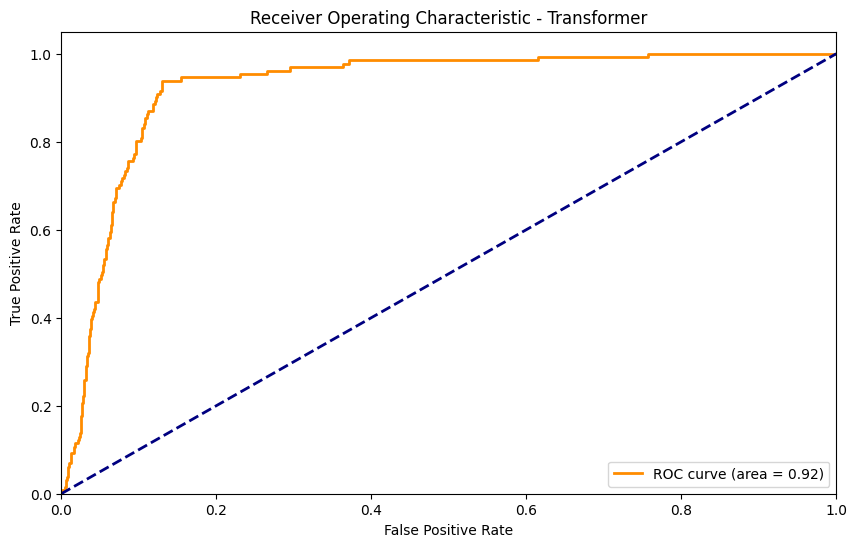

Epoch 1, Loss: 0.5609402845303217
Epoch 2, Loss: 0.2514245131363471
Epoch 3, Loss: 0.22398862006763617
Epoch 4, Loss: 0.22572141314546268
Epoch 5, Loss: 0.22338367501894632
Epoch 6, Loss: 0.22234399914741515
Epoch 7, Loss: 0.22041949220001697
Epoch 8, Loss: 0.2186432642241319
Epoch 9, Loss: 0.2159418273717165
Epoch 10, Loss: 0.2131243700782458
Epoch 11, Loss: 0.21125327547391257
Epoch 12, Loss: 0.2077856292327245
Epoch 13, Loss: 0.20589794951180618
Epoch 14, Loss: 0.2024045889576276
Epoch 15, Loss: 0.19950959831476212
Epoch 16, Loss: 0.19693068452179432
Epoch 17, Loss: 0.19430628729363283
Epoch 18, Loss: 0.19183510144551594
Epoch 19, Loss: 0.18887572400271893
Epoch 20, Loss: 0.18620692615707715


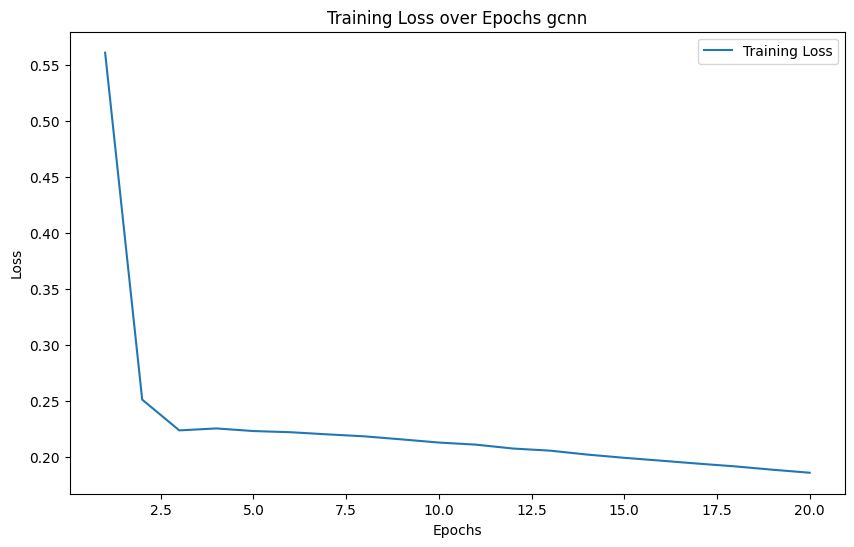

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

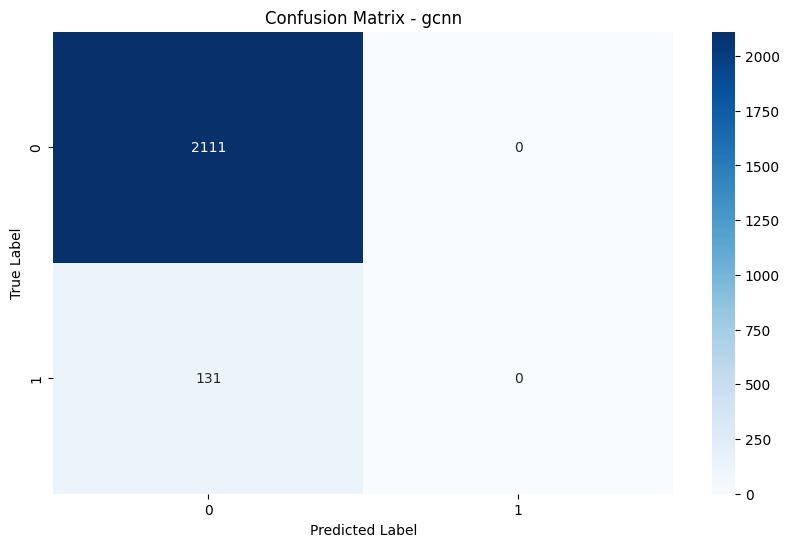

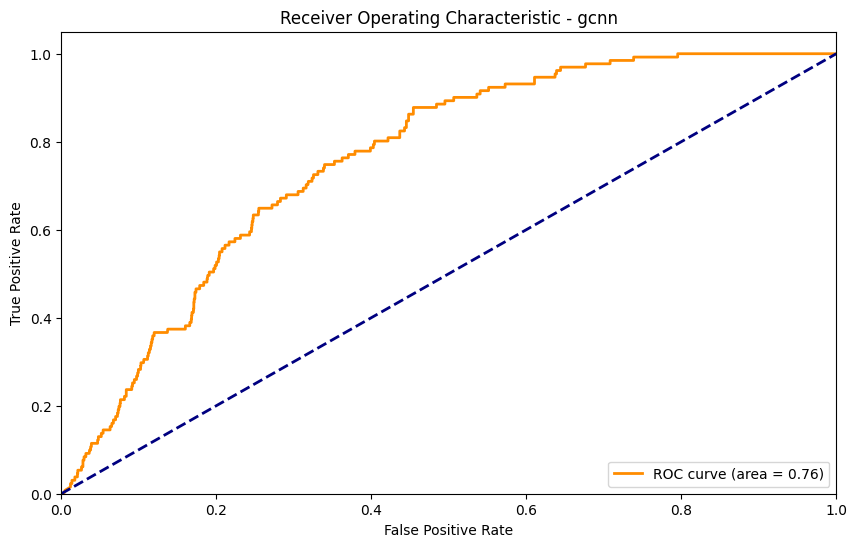

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}, 'type2_label_': {'GSageConv': 0.9315206445115811, 'GAT': 0.9330312185297079, 'GTransformer': 0.9284994964753273, 'GCNN': 0.9330312185297079}, 'type3_label_': {'GSageConv': 0.8913752913752914, 'GAT': 0.8652680652680653, 'GTransformer': 0.889044289044289, 'GCNN': 0.8652680652680653}, 'type4_label_': {'GSageConv': 0.931757359500446, 'GAT': 0.9415700267618198, 'GTransformer': 0.9411239964317574, 'GCNN': 0.9415700267618198}}
type5_label_


100%|██████████| 1807/1807 [02:50<00:00, 10.60it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.30651184495072814
Epoch 2, Loss: 0.19430702570825814
Epoch 3, Loss: 0.17607228881679476
Epoch 4, Loss: 0.17178257880732417
Epoch 5, Loss: 0.16590176559984685
Epoch 6, Loss: 0.16280069379135967
Epoch 7, Loss: 0.16003306154161692
Epoch 8, Loss: 0.15784800415858627
Epoch 9, Loss: 0.15504250517114998
Epoch 10, Loss: 0.1566570763476193
Epoch 11, Loss: 0.15355693828314543
Epoch 12, Loss: 0.15360411060974002
Epoch 13, Loss: 0.1525866387411952
Epoch 14, Loss: 0.1532916988246143
Epoch 15, Loss: 0.15275684176012874
Epoch 16, Loss: 0.15154617596417666
Epoch 17, Loss: 0.15297259902581573
Epoch 18, Loss: 0.1517029450275004
Epoch 19, Loss: 0.15037892274558545
Epoch 20, Loss: 0.14897324396297335


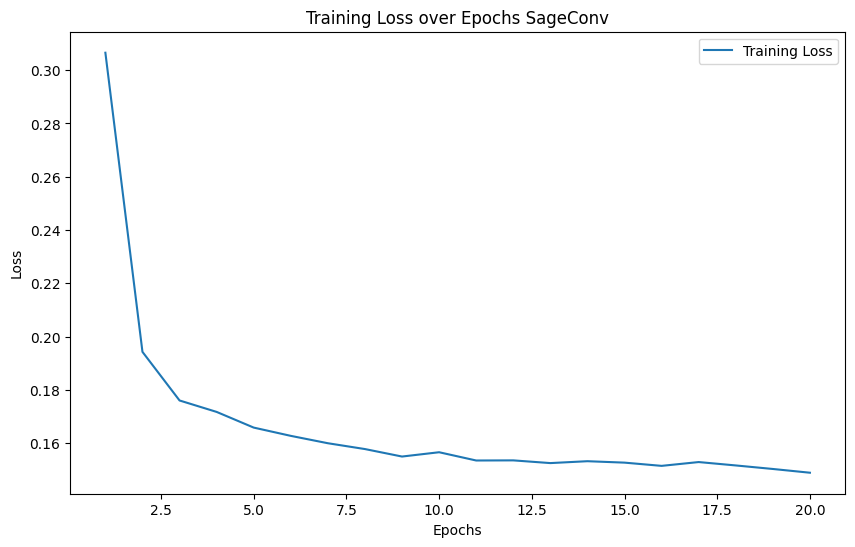

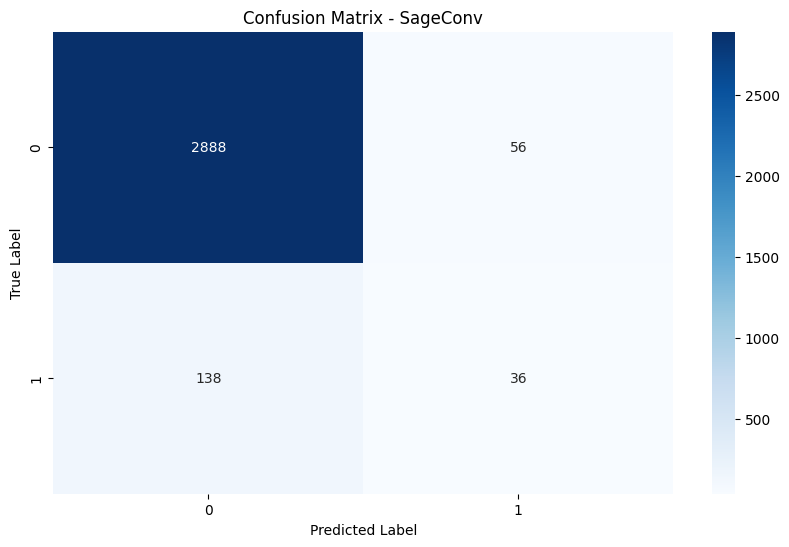

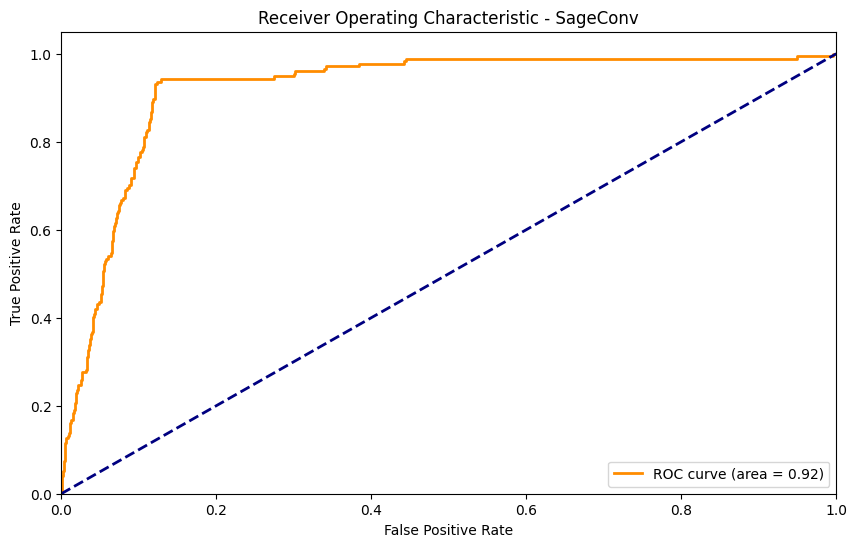

Epoch 1, Loss: 0.4503560945391655
Epoch 2, Loss: 0.25013533495366574
Epoch 3, Loss: 0.24992137122899294
Epoch 4, Loss: 0.24692969899624587
Epoch 5, Loss: 0.24640383729711174
Epoch 6, Loss: 0.24583283113315701
Epoch 7, Loss: 0.24512189580127597
Epoch 8, Loss: 0.2431980174034834
Epoch 9, Loss: 0.24349800748750566
Epoch 10, Loss: 0.24298159265890718
Epoch 11, Loss: 0.24155866242945195
Epoch 12, Loss: 0.24132580403238535
Epoch 13, Loss: 0.24099409943446518
Epoch 14, Loss: 0.24069792171940207
Epoch 15, Loss: 0.23958800323307514
Epoch 16, Loss: 0.2394947295077145
Epoch 17, Loss: 0.23932477859780193
Epoch 18, Loss: 0.23883108096197248
Epoch 19, Loss: 0.23848249483853579
Epoch 20, Loss: 0.2386725004762411


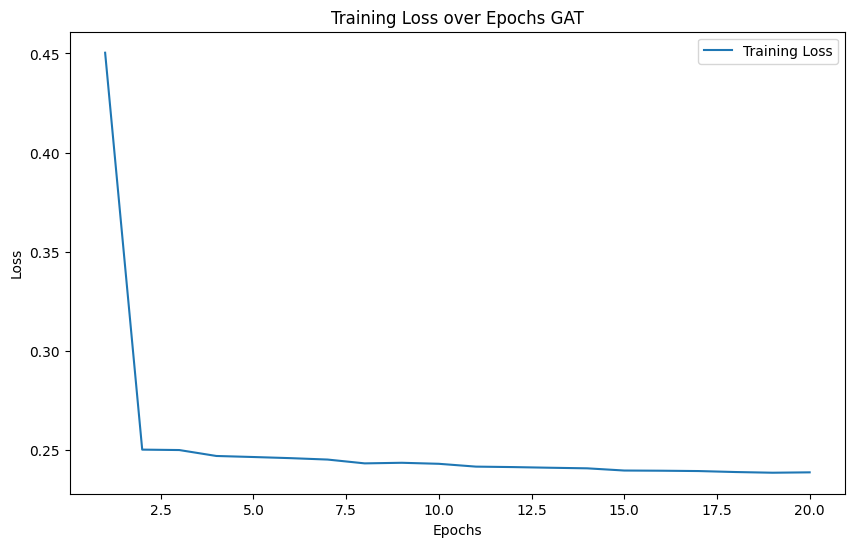

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

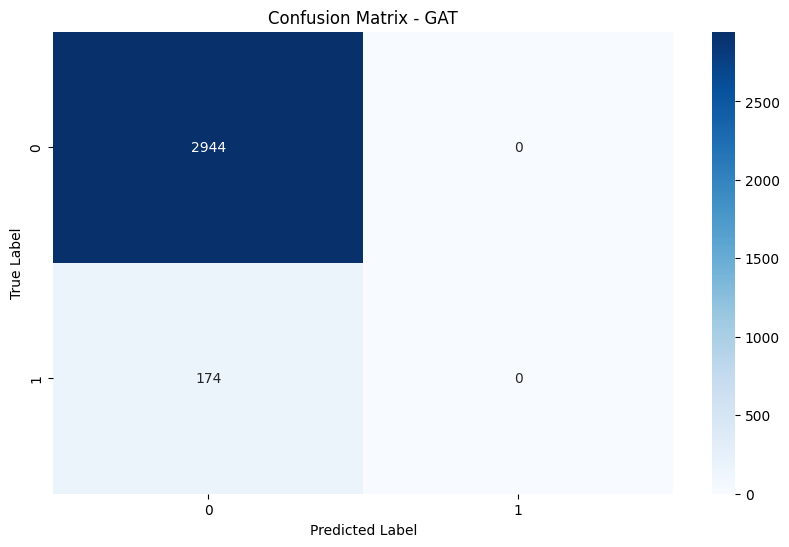

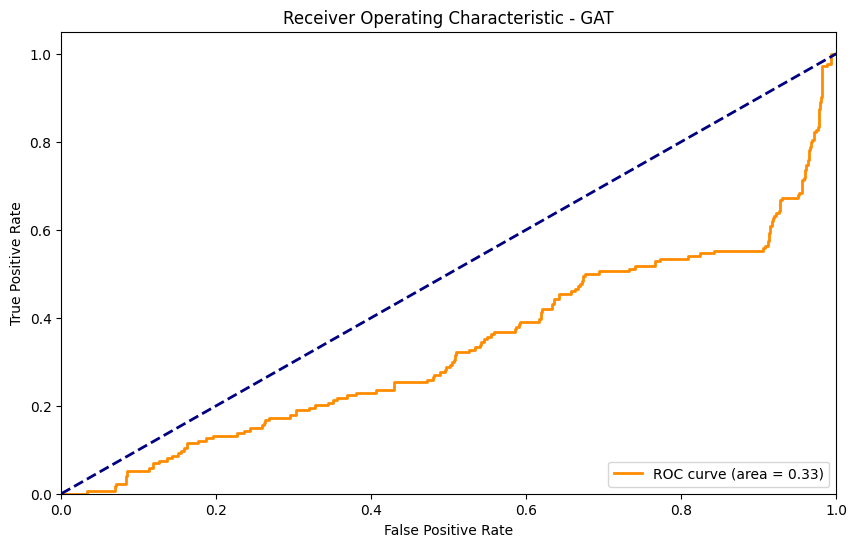

Epoch 1, Loss: 0.2995189977053087
Epoch 2, Loss: 0.19509070267667994
Epoch 3, Loss: 0.1901170494966209
Epoch 4, Loss: 0.1792401044629514
Epoch 5, Loss: 0.17505565248429775
Epoch 6, Loss: 0.17087594158947467
Epoch 7, Loss: 0.16921824486926199
Epoch 8, Loss: 0.16432736711576582
Epoch 9, Loss: 0.16444466481916606
Epoch 10, Loss: 0.16200338448397816
Epoch 11, Loss: 0.16144744390621782
Epoch 12, Loss: 0.158038280159235
Epoch 13, Loss: 0.15728353541344403
Epoch 14, Loss: 0.1559007260017097
Epoch 15, Loss: 0.1575421635992825
Epoch 16, Loss: 0.153533374145627
Epoch 17, Loss: 0.15528394794091582
Epoch 18, Loss: 0.15250590248033405
Epoch 19, Loss: 0.15145174833014607
Epoch 20, Loss: 0.15103044882416725


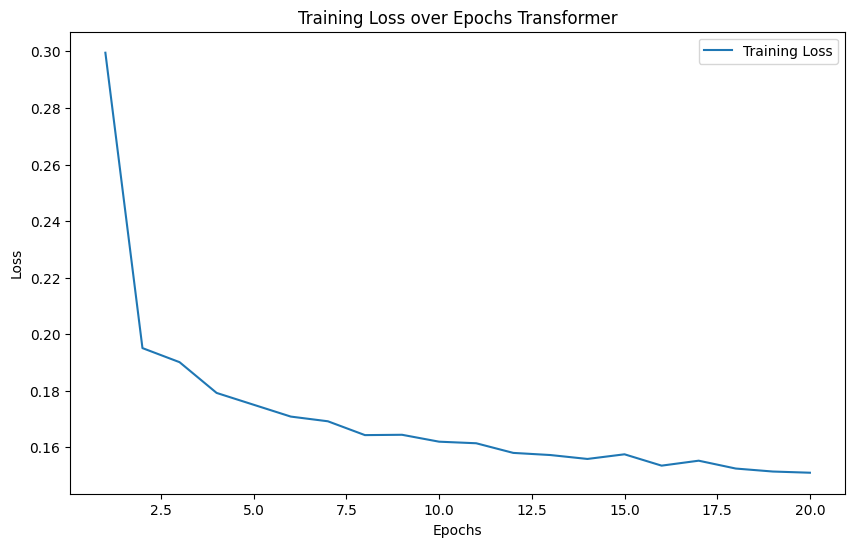

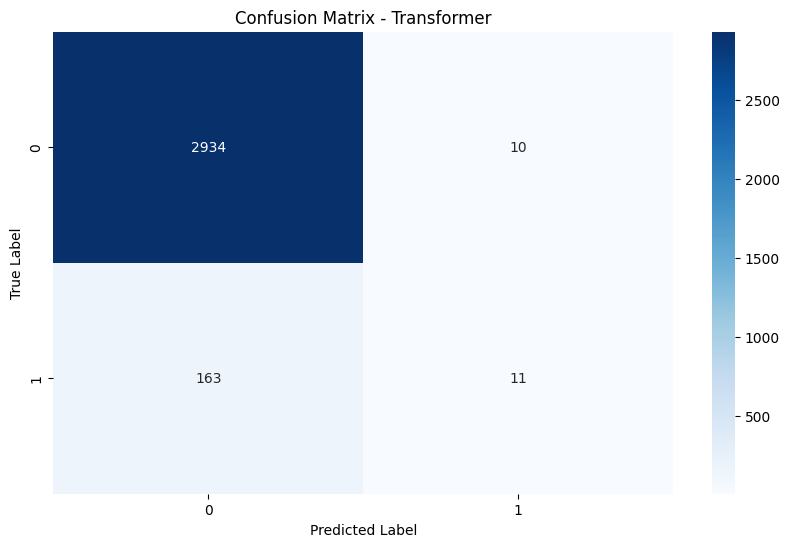

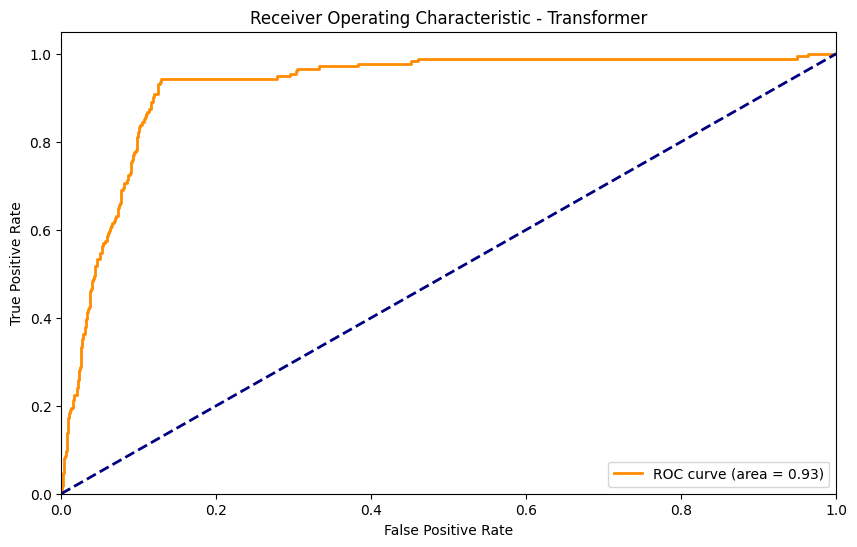

Epoch 1, Loss: 0.47011047713458537
Epoch 2, Loss: 0.29845814518630503
Epoch 3, Loss: 0.2933258846402168
Epoch 4, Loss: 0.28245107308030126
Epoch 5, Loss: 0.27214362658560276
Epoch 6, Loss: 0.2604397082701325
Epoch 7, Loss: 0.2495208613574505
Epoch 8, Loss: 0.23843332957476376
Epoch 9, Loss: 0.23004601821303367
Epoch 10, Loss: 0.22447974383831024
Epoch 11, Loss: 0.22213696399703622
Epoch 12, Loss: 0.22265145368874073
Epoch 13, Loss: 0.22129773106426
Epoch 14, Loss: 0.22018446652218698
Epoch 15, Loss: 0.21688515171408654
Epoch 16, Loss: 0.2148330789990723
Epoch 17, Loss: 0.2161365928594023
Epoch 18, Loss: 0.20994669441133737
Epoch 19, Loss: 0.20843326551839708
Epoch 20, Loss: 0.20932911559939385


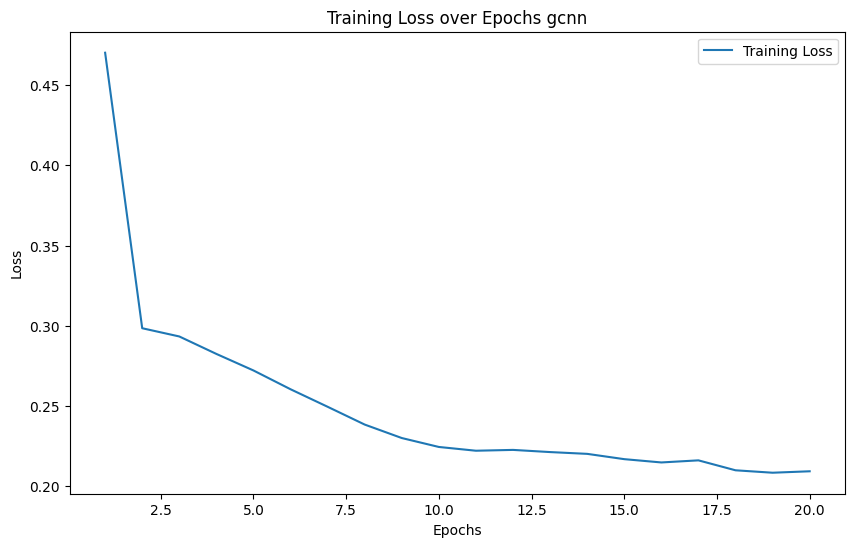

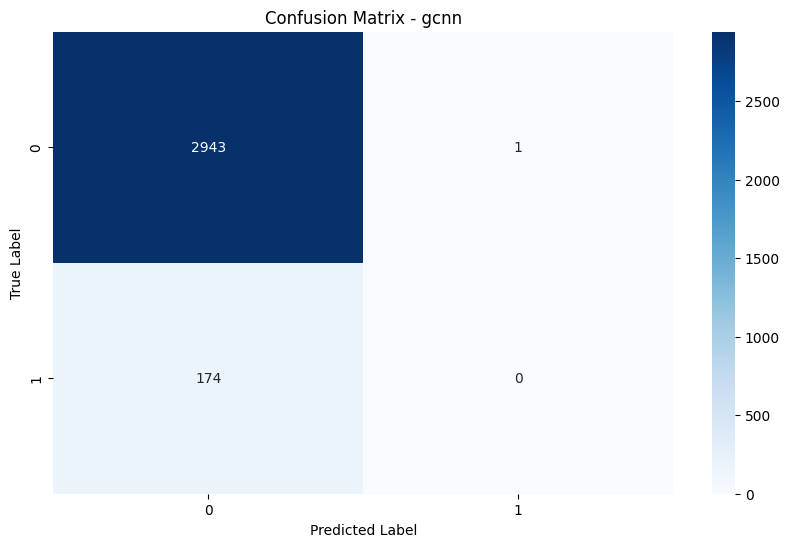

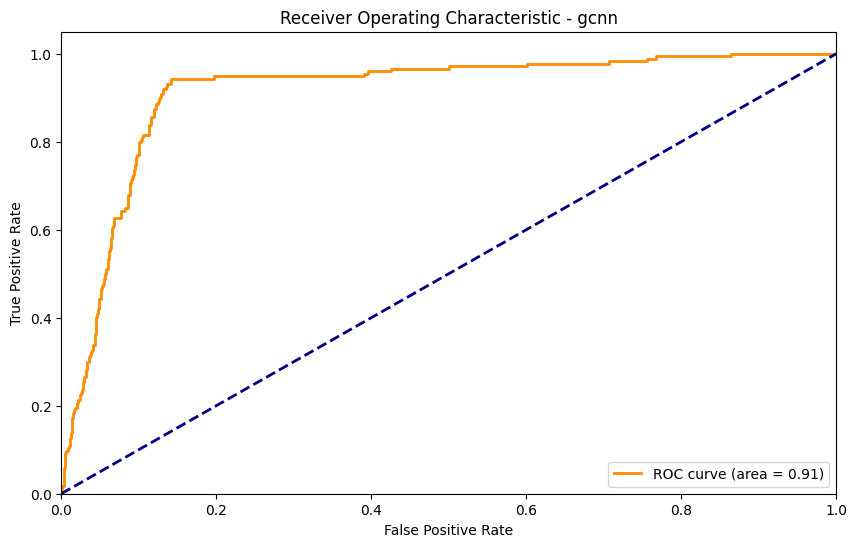

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}, 'type2_label_': {'GSageConv': 0.9315206445115811, 'GAT': 0.9330312185297079, 'GTransformer': 0.9284994964753273, 'GCNN': 0.9330312185297079}, 'type3_label_': {'GSageConv': 0.8913752913752914, 'GAT': 0.8652680652680653, 'GTransformer': 0.889044289044289, 'GCNN': 0.8652680652680653}, 'type4_label_': {'GSageConv': 0.931757359500446, 'GAT': 0.9415700267618198, 'GTransformer': 0.9411239964317574, 'GCNN': 0.9415700267618198}, 'type5_label_': {'GSageConv': 0.9377806286080821, 'GAT': 0.9441949967928159, 'GTransformer': 0.9445157152020526, 'GCNN': 0.9438742783835792}}
type6_label_


100%|██████████| 2414/2414 [03:47<00:00, 10.59it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.29361226996582634
Epoch 2, Loss: 0.16776374783718362
Epoch 3, Loss: 0.15779910247140336
Epoch 4, Loss: 0.1544799214967017
Epoch 5, Loss: 0.15075726968781003
Epoch 6, Loss: 0.1529398920049645
Epoch 7, Loss: 0.1499572553724613
Epoch 8, Loss: 0.14819364745240166
Epoch 9, Loss: 0.15034109993644482
Epoch 10, Loss: 0.14985974987019907
Epoch 11, Loss: 0.14919759937614765
Epoch 12, Loss: 0.14861204440020165
Epoch 13, Loss: 0.14731813468179614
Epoch 14, Loss: 0.14640970289144875
Epoch 15, Loss: 0.14522606057097326
Epoch 16, Loss: 0.14689380499833035
Epoch 17, Loss: 0.1444532259033536
Epoch 18, Loss: 0.14552492001708947
Epoch 19, Loss: 0.14438104791180142
Epoch 20, Loss: 0.14499995737986746


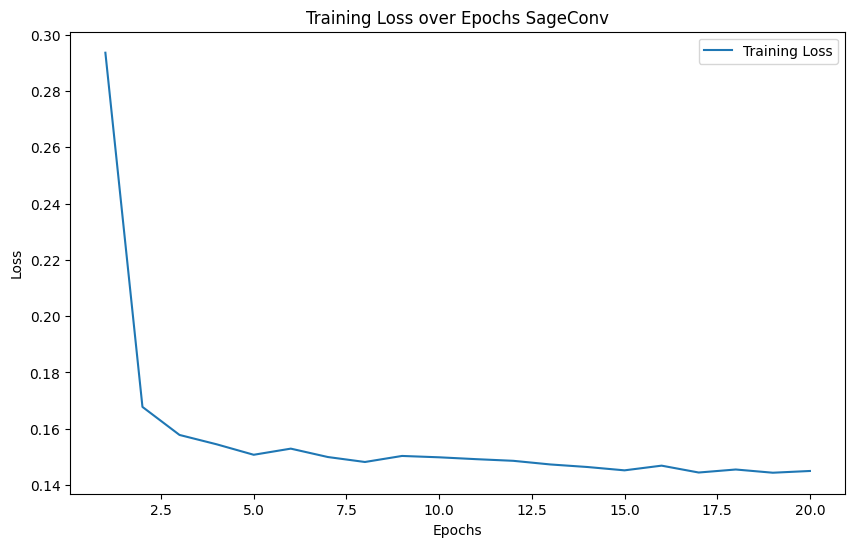

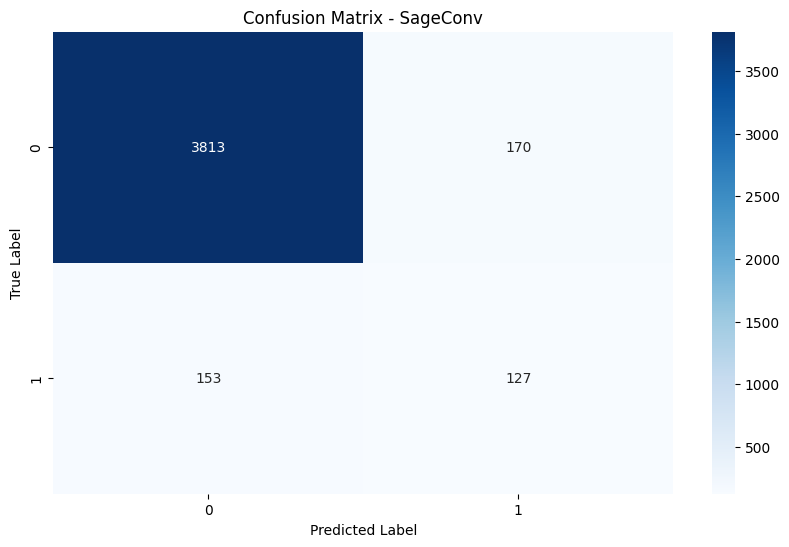

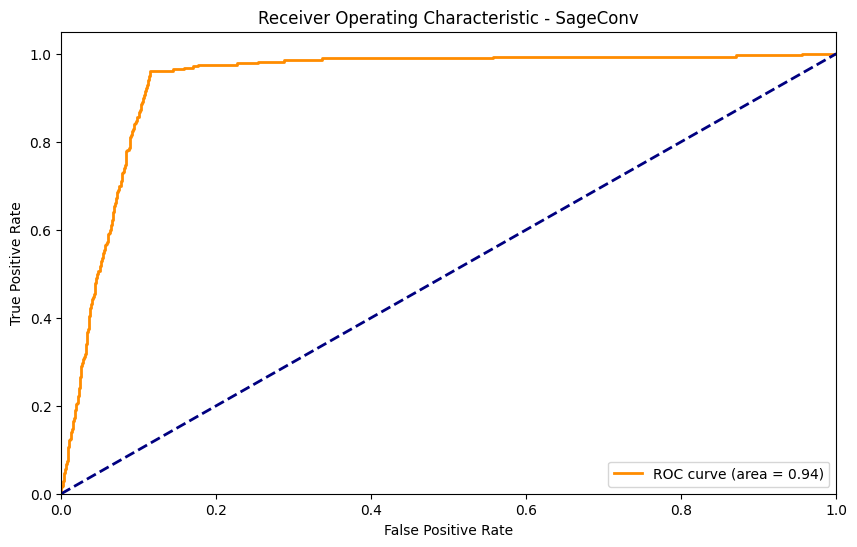

Epoch 1, Loss: 0.4401959660199453
Epoch 2, Loss: 0.2641809764054586
Epoch 3, Loss: 0.2651761155926956
Epoch 4, Loss: 0.26415077252489216
Epoch 5, Loss: 0.2627077276976603
Epoch 6, Loss: 0.2623671683359821
Epoch 7, Loss: 0.2616272049270711
Epoch 8, Loss: 0.2606069875072758
Epoch 9, Loss: 0.2599973549258034
Epoch 10, Loss: 0.26000997733395054
Epoch 11, Loss: 0.2590901661875113
Epoch 12, Loss: 0.25908499386794165
Epoch 13, Loss: 0.2573602759050873
Epoch 14, Loss: 0.25828435778055553
Epoch 15, Loss: 0.25753803466850855
Epoch 16, Loss: 0.25690850931799636
Epoch 17, Loss: 0.25745039264548497
Epoch 18, Loss: 0.2568418957152457
Epoch 19, Loss: 0.2562099201780445
Epoch 20, Loss: 0.2564417298110026


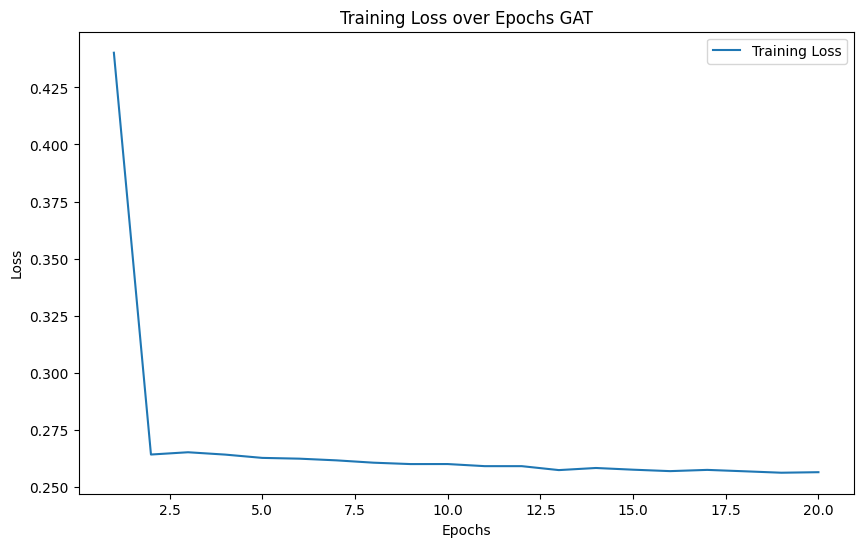

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

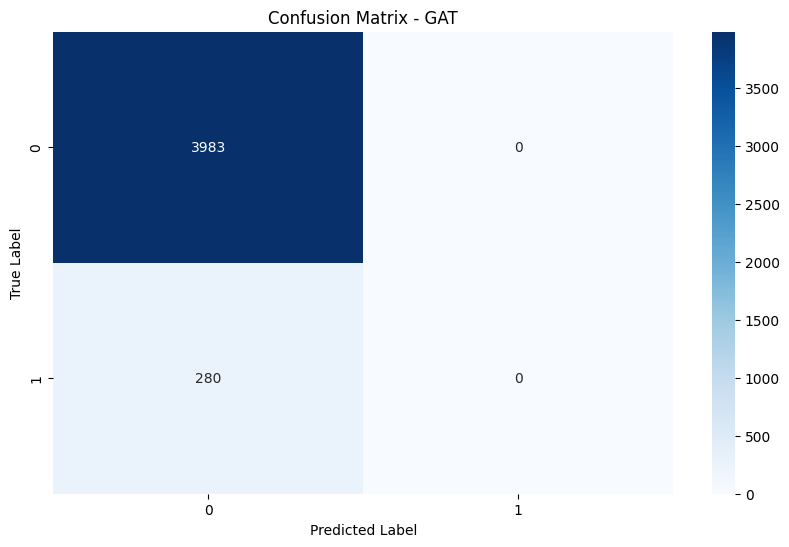

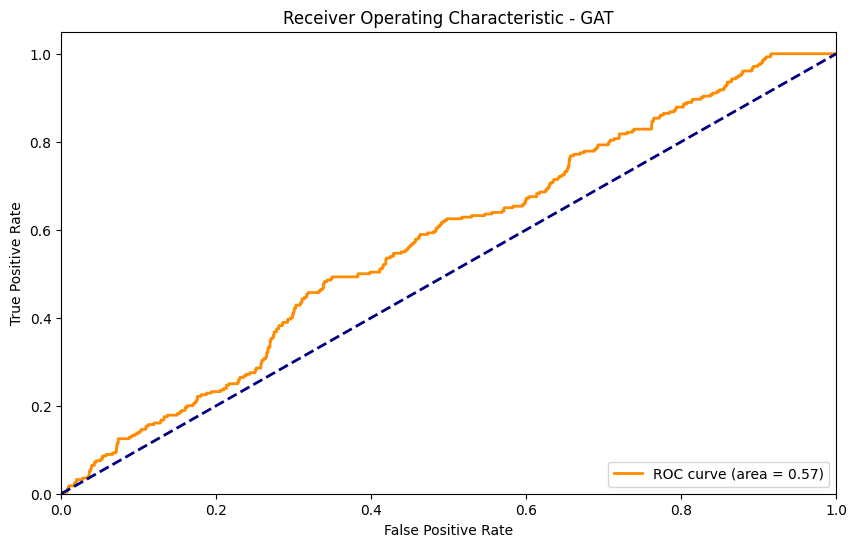

Epoch 1, Loss: 0.29874259762395666
Epoch 2, Loss: 0.16919181914121476
Epoch 3, Loss: 0.17404770120134894
Epoch 4, Loss: 0.16613770973921385
Epoch 5, Loss: 0.15852671151734749
Epoch 6, Loss: 0.15671653458672874
Epoch 7, Loss: 0.15449222602512477
Epoch 8, Loss: 0.1555983350735228
Epoch 9, Loss: 0.15355698616718347
Epoch 10, Loss: 0.1498509498559079
Epoch 11, Loss: 0.15334099787726718
Epoch 12, Loss: 0.15043896591325975
Epoch 13, Loss: 0.15036195969947105
Epoch 14, Loss: 0.15182261414966494
Epoch 15, Loss: 0.14833192260197872
Epoch 16, Loss: 0.1506317957603144
Epoch 17, Loss: 0.14808061346411705
Epoch 18, Loss: 0.14985629318738883
Epoch 19, Loss: 0.14911098813392082
Epoch 20, Loss: 0.14776338770423295


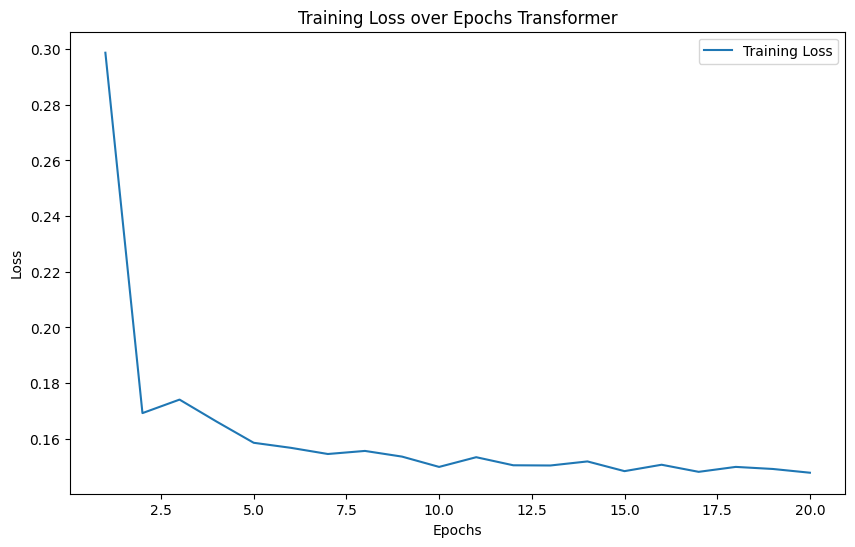

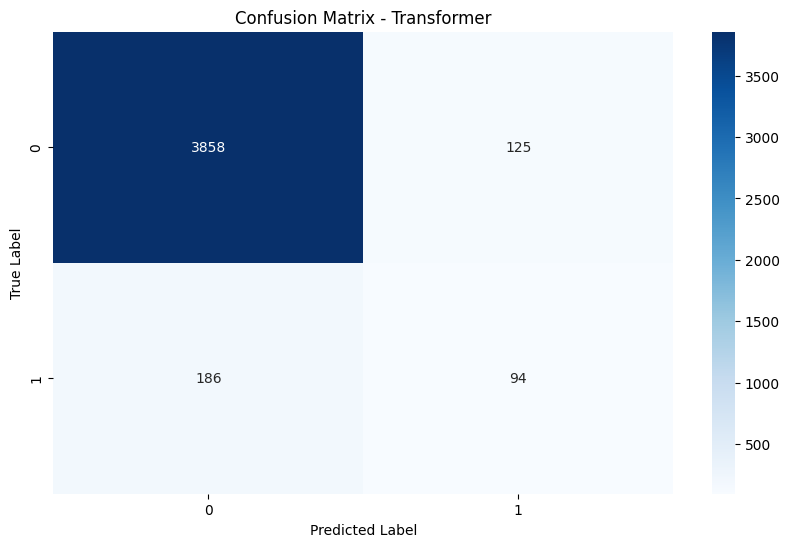

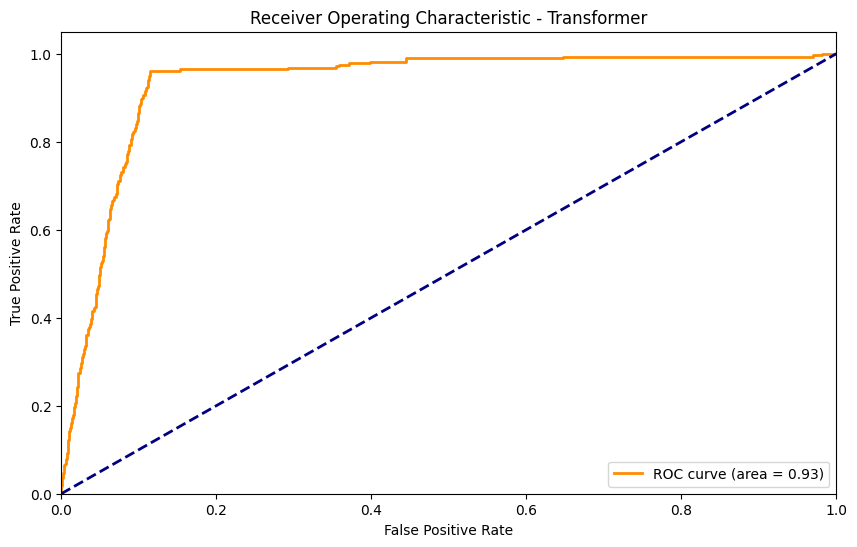

Epoch 1, Loss: 0.4197619929909706
Epoch 2, Loss: 0.29368668176093193
Epoch 3, Loss: 0.29101918904848817
Epoch 4, Loss: 0.2843211033153084
Epoch 5, Loss: 0.27580353041302486
Epoch 6, Loss: 0.2667050676525764
Epoch 7, Loss: 0.25769931780842115
Epoch 8, Loss: 0.25070842643672564
Epoch 9, Loss: 0.24735292314358479
Epoch 10, Loss: 0.24611837789416313
Epoch 11, Loss: 0.24446309751497125
Epoch 12, Loss: 0.24374517067423407
Epoch 13, Loss: 0.239676398418422
Epoch 14, Loss: 0.23591158419566335
Epoch 15, Loss: 0.23462672352369102
Epoch 16, Loss: 0.23433584888588707
Epoch 17, Loss: 0.22983802180245239
Epoch 18, Loss: 0.22733889527197154
Epoch 19, Loss: 0.22564145929689677
Epoch 20, Loss: 0.2232010630574429


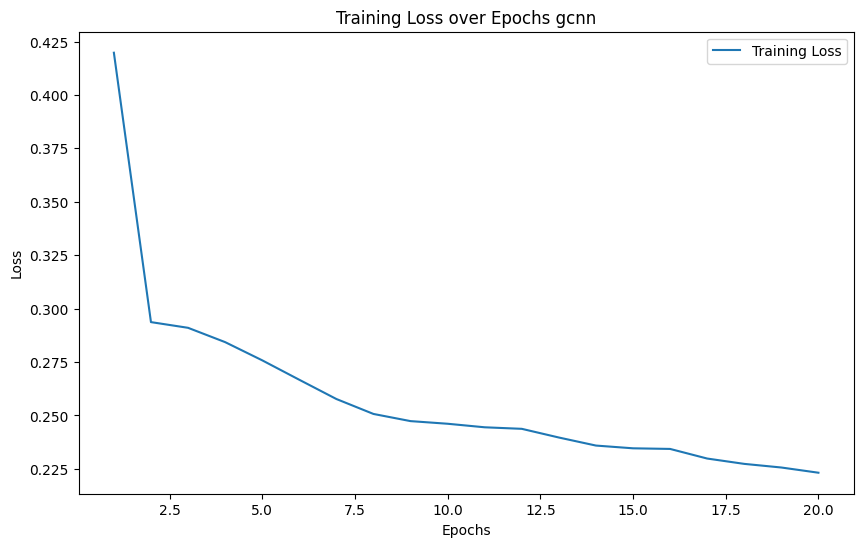

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

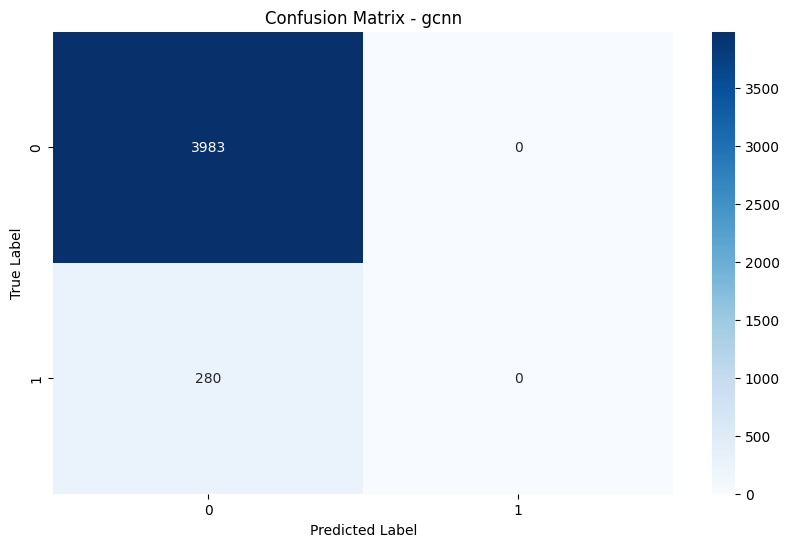

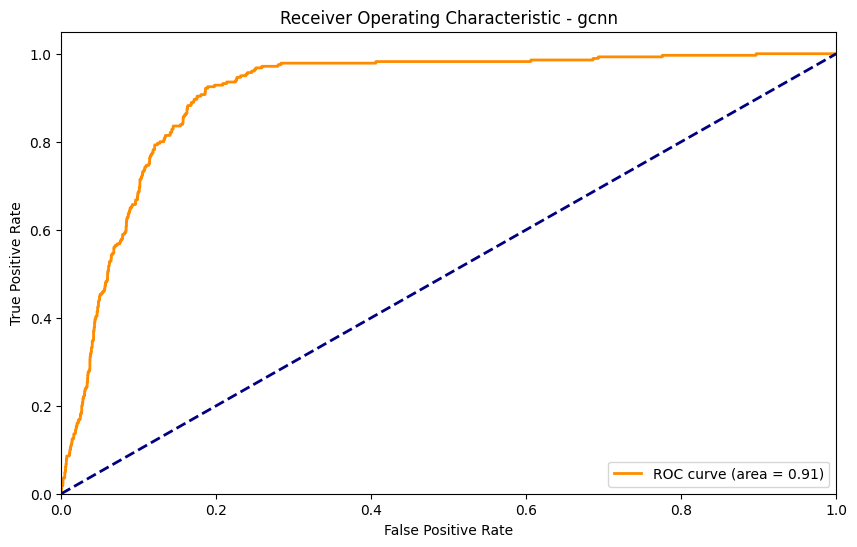

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}, 'type2_label_': {'GSageConv': 0.9315206445115811, 'GAT': 0.9330312185297079, 'GTransformer': 0.9284994964753273, 'GCNN': 0.9330312185297079}, 'type3_label_': {'GSageConv': 0.8913752913752914, 'GAT': 0.8652680652680653, 'GTransformer': 0.889044289044289, 'GCNN': 0.8652680652680653}, 'type4_label_': {'GSageConv': 0.931757359500446, 'GAT': 0.9415700267618198, 'GTransformer': 0.9411239964317574, 'GCNN': 0.9415700267618198}, 'type5_label_': {'GSageConv': 0.9377806286080821, 'GAT': 0.9441949967928159, 'GTransformer': 0.9445157152020526, 'GCNN': 0.9438742783835792}, 'type6_label_': {'GSageConv': 0.9242317616701853, 'GAT': 0.9343185550082101, 'GTransformer': 0.9270466807412621, 'GCNN': 0.9343185550082101}}
type7_la

100%|██████████| 2342/2342 [03:26<00:00, 11.33it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.370852989395364
Epoch 2, Loss: 0.21868874904556343
Epoch 3, Loss: 0.2007180153965377
Epoch 4, Loss: 0.20227751972225422
Epoch 5, Loss: 0.20065951741372162
Epoch 6, Loss: 0.19876075077515382
Epoch 7, Loss: 0.20133332456820285
Epoch 8, Loss: 0.19846110640523526
Epoch 9, Loss: 0.19874113472178578
Epoch 10, Loss: 0.19824777640259036
Epoch 11, Loss: 0.1987816264781241
Epoch 12, Loss: 0.1964778248937084
Epoch 13, Loss: 0.19645318883256271
Epoch 14, Loss: 0.19813886682431286
Epoch 15, Loss: 0.19491762452973768
Epoch 16, Loss: 0.19532418401482013
Epoch 17, Loss: 0.19586928360737288
Epoch 18, Loss: 0.19355145748704672
Epoch 19, Loss: 0.1946515290496441
Epoch 20, Loss: 0.19300716406164262


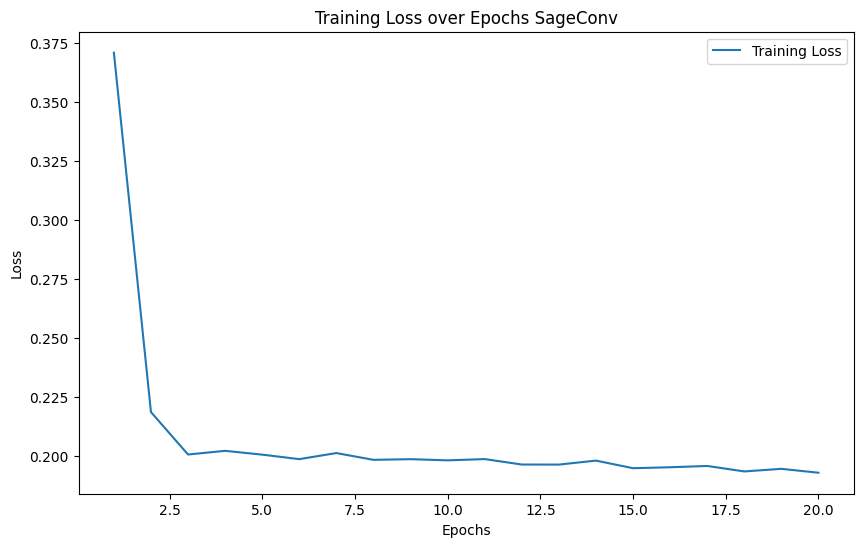

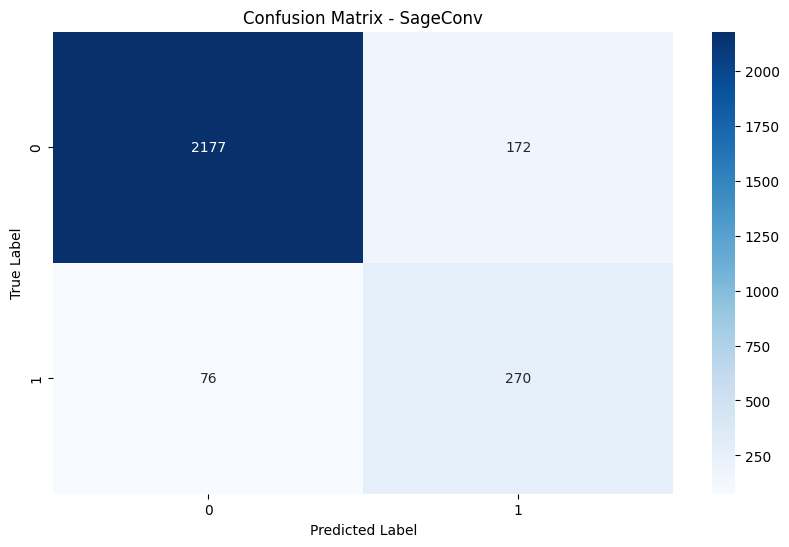

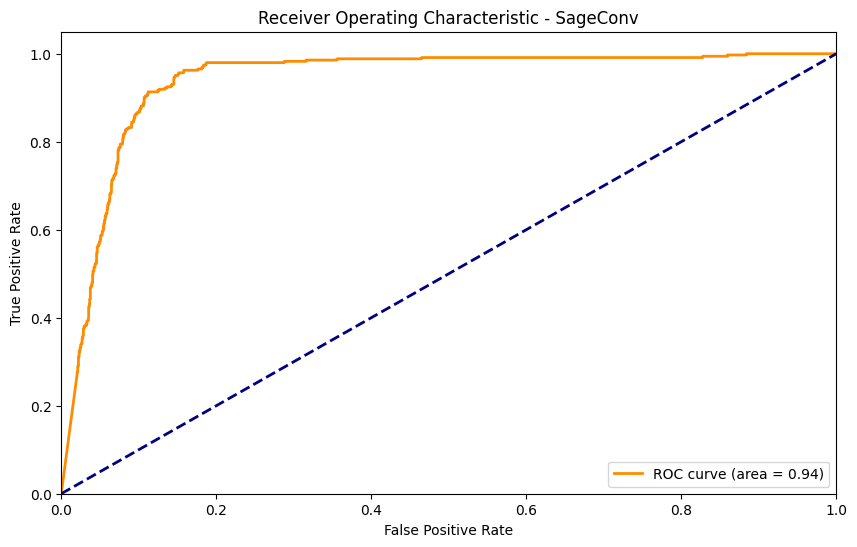

Epoch 1, Loss: 0.5376436939606299
Epoch 2, Loss: 0.4422973176607719
Epoch 3, Loss: 0.4186451897884791
Epoch 4, Loss: 0.3893161120896156
Epoch 5, Loss: 0.3633882285883793
Epoch 6, Loss: 0.3410281003094636
Epoch 7, Loss: 0.32700994023336816
Epoch 8, Loss: 0.3224093820183323
Epoch 9, Loss: 0.31877401951127327
Epoch 10, Loss: 0.31627813096229845
Epoch 11, Loss: 0.317027833742591
Epoch 12, Loss: 0.3158887434177674
Epoch 13, Loss: 0.3150756350503518
Epoch 14, Loss: 0.3139519285267362
Epoch 15, Loss: 0.31312347733630586
Epoch 16, Loss: 0.3135921712964773
Epoch 17, Loss: 0.31324216838066393
Epoch 18, Loss: 0.31195030662302786
Epoch 19, Loss: 0.3106285873800516
Epoch 20, Loss: 0.3100807989159456


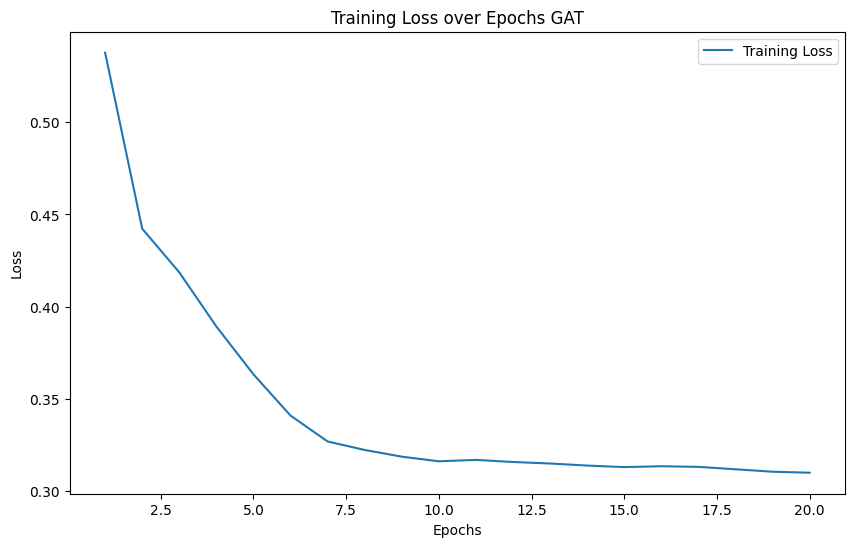

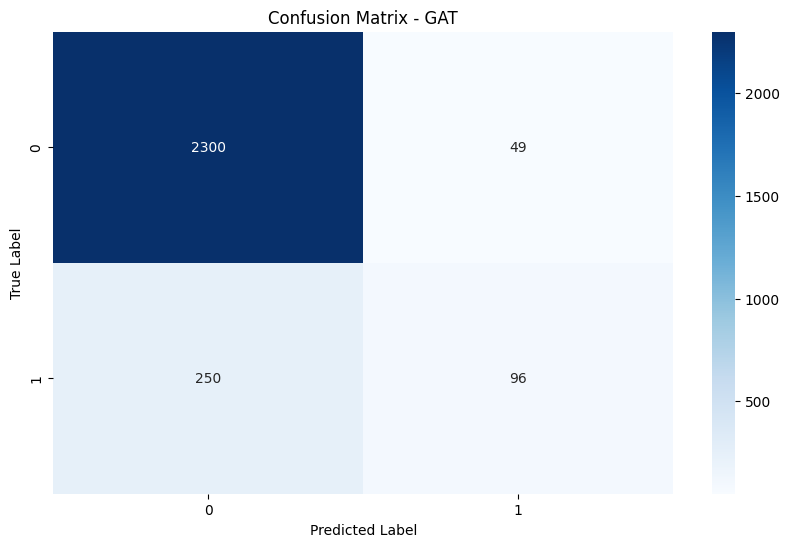

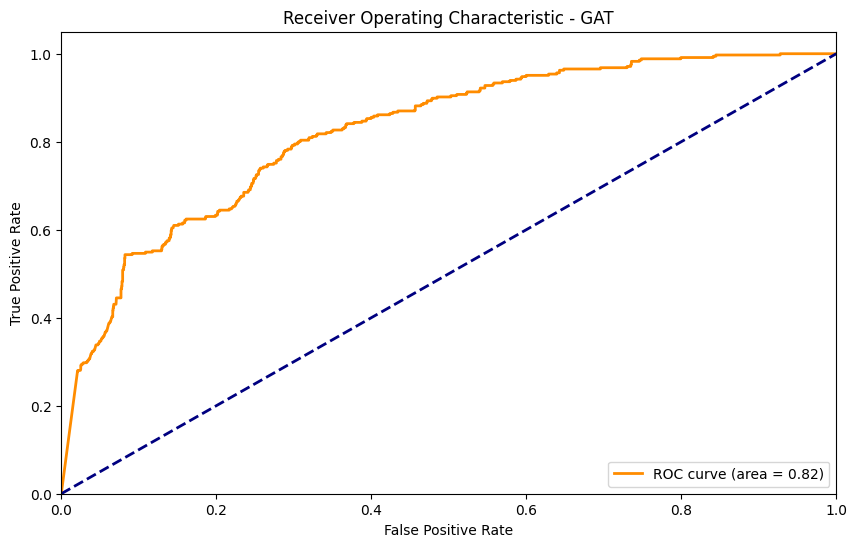

Epoch 1, Loss: 0.41292964828272277
Epoch 2, Loss: 0.2485917596719586
Epoch 3, Loss: 0.21597172255412891
Epoch 4, Loss: 0.21152449399232864
Epoch 5, Loss: 0.21302305962532186
Epoch 6, Loss: 0.2036300004244997
Epoch 7, Loss: 0.20765233365818858
Epoch 8, Loss: 0.20552744447755125
Epoch 9, Loss: 0.20556794968433678
Epoch 10, Loss: 0.2023974285246088
Epoch 11, Loss: 0.19981309699897581
Epoch 12, Loss: 0.20345308226891434
Epoch 13, Loss: 0.19847886604615128
Epoch 14, Loss: 0.1996844453164018
Epoch 15, Loss: 0.20173685245502454
Epoch 16, Loss: 0.19799308052573067
Epoch 17, Loss: 0.20030794013291597
Epoch 18, Loss: 0.19571704918948504
Epoch 19, Loss: 0.19816277018533304
Epoch 20, Loss: 0.19657055145272842


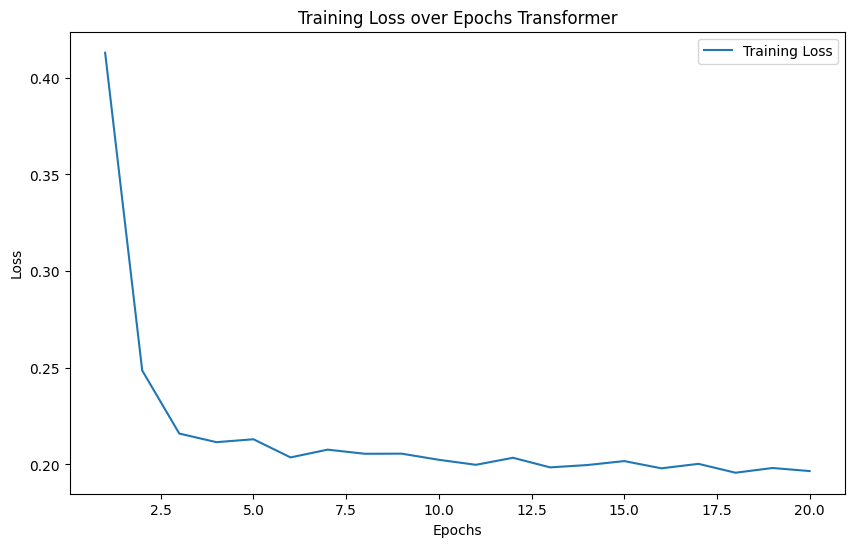

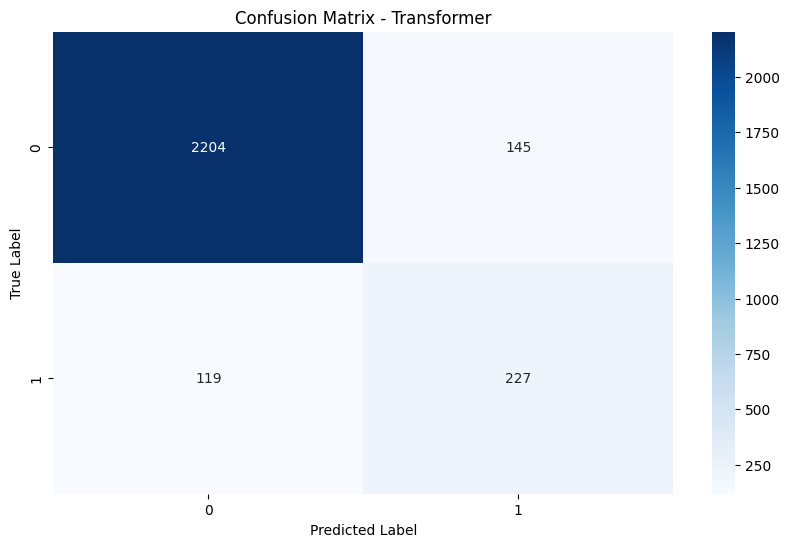

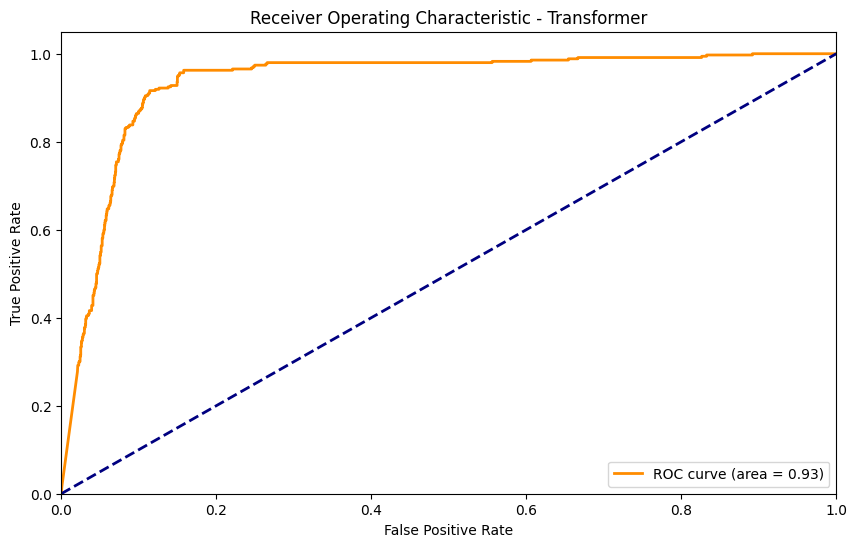

Epoch 1, Loss: 0.5590930317456906
Epoch 2, Loss: 0.4462705571204424
Epoch 3, Loss: 0.41146010475663036
Epoch 4, Loss: 0.3750469624423064
Epoch 5, Loss: 0.347354361644158
Epoch 6, Loss: 0.33059372724248814
Epoch 7, Loss: 0.32481555024591774
Epoch 8, Loss: 0.32405517314775634
Epoch 9, Loss: 0.31703690346330404
Epoch 10, Loss: 0.313953154003964
Epoch 11, Loss: 0.3146895681006404
Epoch 12, Loss: 0.31295480471677506
Epoch 13, Loss: 0.30989583080204636
Epoch 14, Loss: 0.3099401035847572
Epoch 15, Loss: 0.3088534869826757
Epoch 16, Loss: 0.31231398343180233
Epoch 17, Loss: 0.3096140603749798
Epoch 18, Loss: 0.3099509628059772
Epoch 19, Loss: 0.31225426430599046
Epoch 20, Loss: 0.3099651076616003


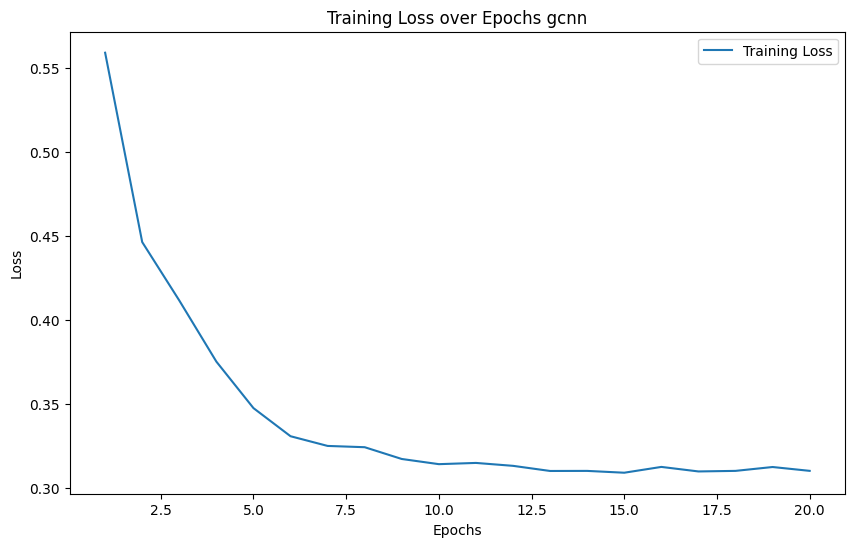

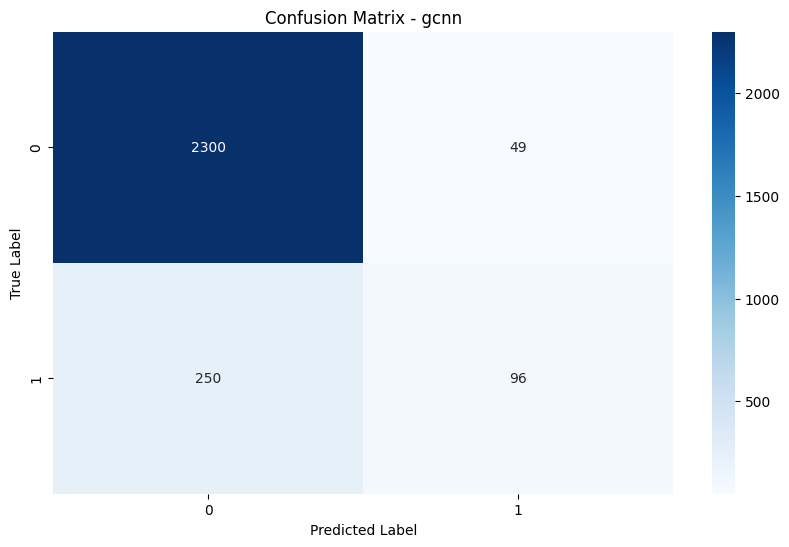

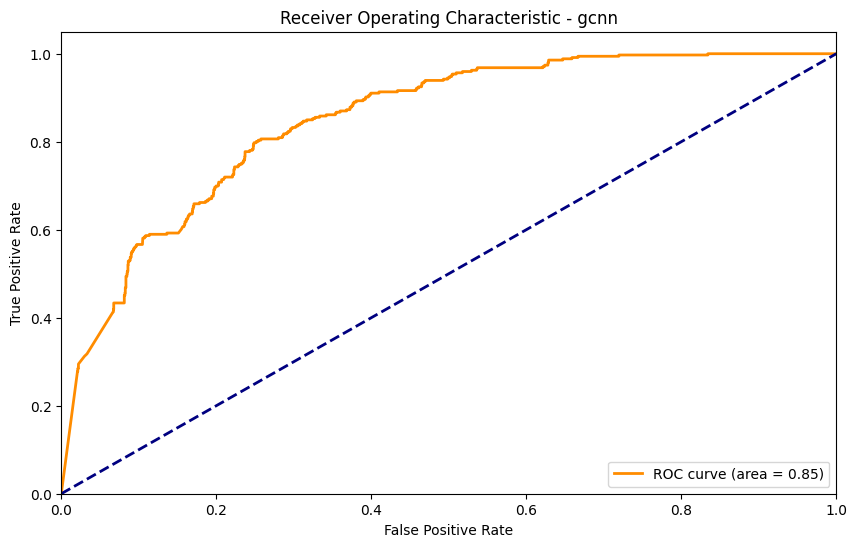

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}, 'type2_label_': {'GSageConv': 0.9315206445115811, 'GAT': 0.9330312185297079, 'GTransformer': 0.9284994964753273, 'GCNN': 0.9330312185297079}, 'type3_label_': {'GSageConv': 0.8913752913752914, 'GAT': 0.8652680652680653, 'GTransformer': 0.889044289044289, 'GCNN': 0.8652680652680653}, 'type4_label_': {'GSageConv': 0.931757359500446, 'GAT': 0.9415700267618198, 'GTransformer': 0.9411239964317574, 'GCNN': 0.9415700267618198}, 'type5_label_': {'GSageConv': 0.9377806286080821, 'GAT': 0.9441949967928159, 'GTransformer': 0.9445157152020526, 'GCNN': 0.9438742783835792}, 'type6_label_': {'GSageConv': 0.9242317616701853, 'GAT': 0.9343185550082101, 'GTransformer': 0.9270466807412621, 'GCNN': 0.9343185550082101}, 'type7_l

100%|██████████| 2658/2658 [03:51<00:00, 11.50it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.5311672504423028
Epoch 2, Loss: 0.24876731406834166
Epoch 3, Loss: 0.2360295572839046
Epoch 4, Loss: 0.2312071945013131
Epoch 5, Loss: 0.22469000815082404
Epoch 6, Loss: 0.22242423042781273
Epoch 7, Loss: 0.22013820950888982
Epoch 8, Loss: 0.21874802521729875
Epoch 9, Loss: 0.21533381553777195
Epoch 10, Loss: 0.21693223841109519
Epoch 11, Loss: 0.21331942848608657
Epoch 12, Loss: 0.21388705576754222
Epoch 13, Loss: 0.21411376834799678
Epoch 14, Loss: 0.21511868548469018
Epoch 15, Loss: 0.21588915968471664
Epoch 16, Loss: 0.2153319423797272
Epoch 17, Loss: 0.21409490174156123
Epoch 18, Loss: 0.2149046430585243
Epoch 19, Loss: 0.21196531517020725
Epoch 20, Loss: 0.21380364872767763


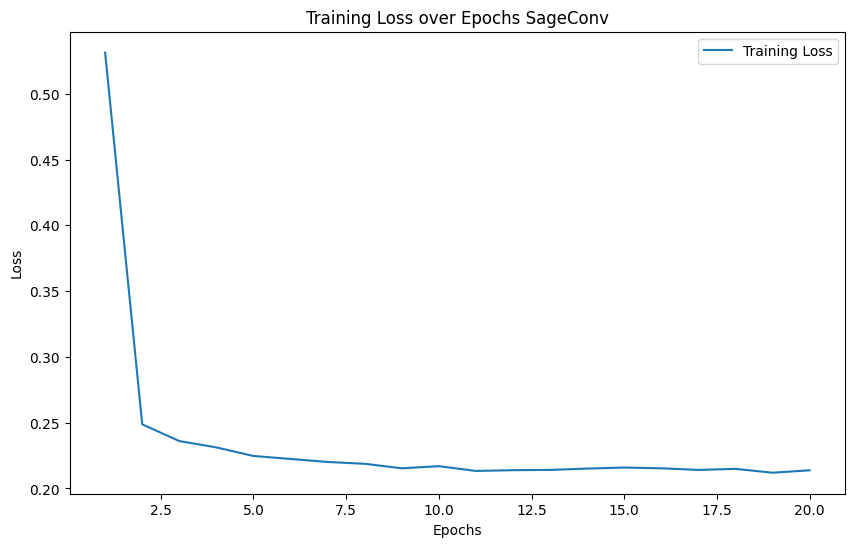

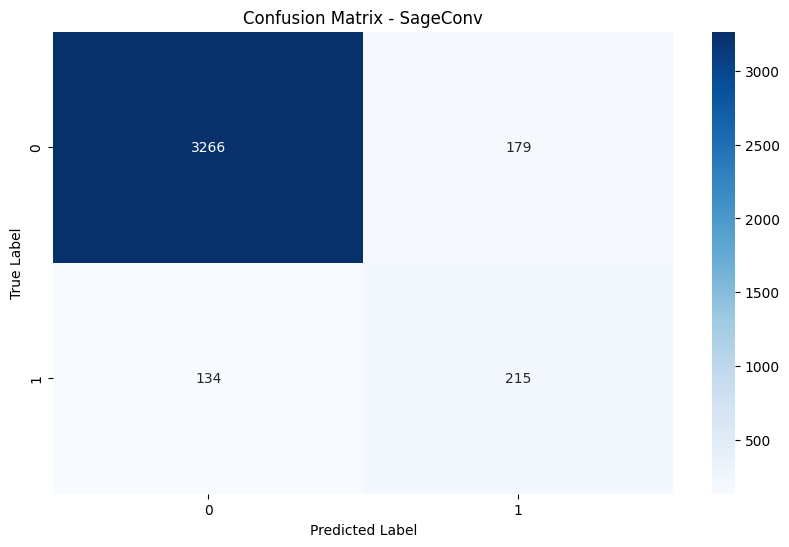

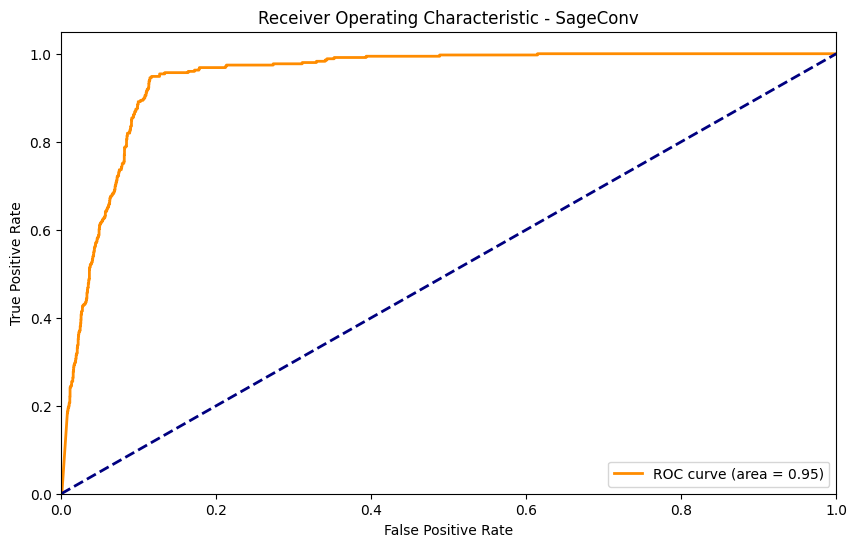

Epoch 1, Loss: 0.5766514575077315
Epoch 2, Loss: 0.4877019451331284
Epoch 3, Loss: 0.45285869680218777
Epoch 4, Loss: 0.40366489781161485
Epoch 5, Loss: 0.37556626672967003
Epoch 6, Loss: 0.3695114497411049
Epoch 7, Loss: 0.3619590625798298
Epoch 8, Loss: 0.3620281540867636
Epoch 9, Loss: 0.36297962359957775
Epoch 10, Loss: 0.3579427425639104
Epoch 11, Loss: 0.3574447131131665
Epoch 12, Loss: 0.35813789019140146
Epoch 13, Loss: 0.35418247355748034
Epoch 14, Loss: 0.35560313542768107
Epoch 15, Loss: 0.35502763521873343
Epoch 16, Loss: 0.35308769143233865
Epoch 17, Loss: 0.3527150008890588
Epoch 18, Loss: 0.3508159438684835
Epoch 19, Loss: 0.35286789299067806
Epoch 20, Loss: 0.3504631725787106


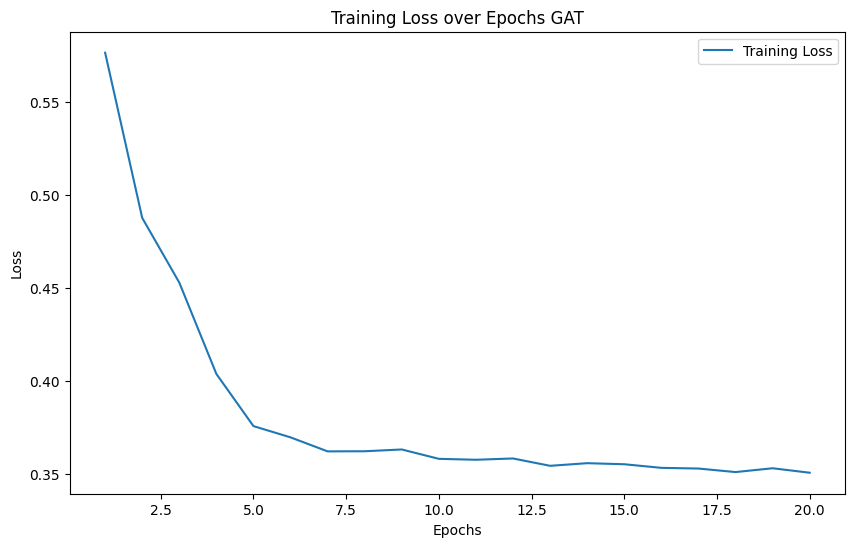

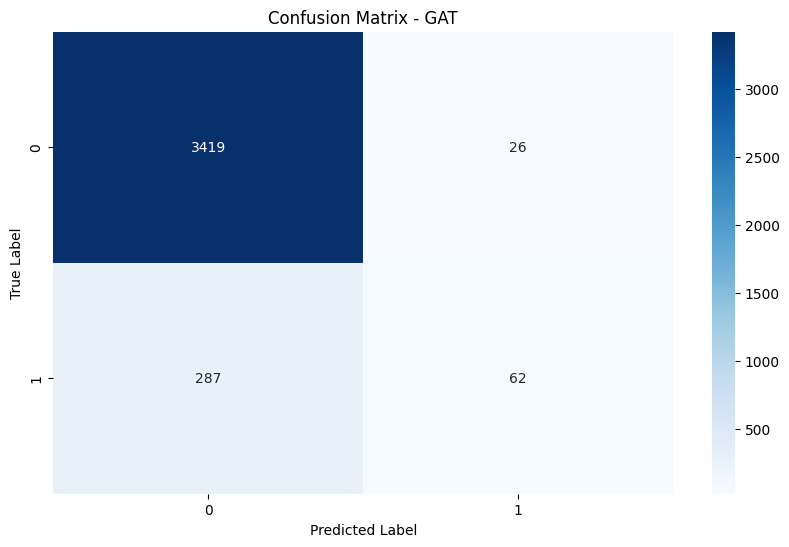

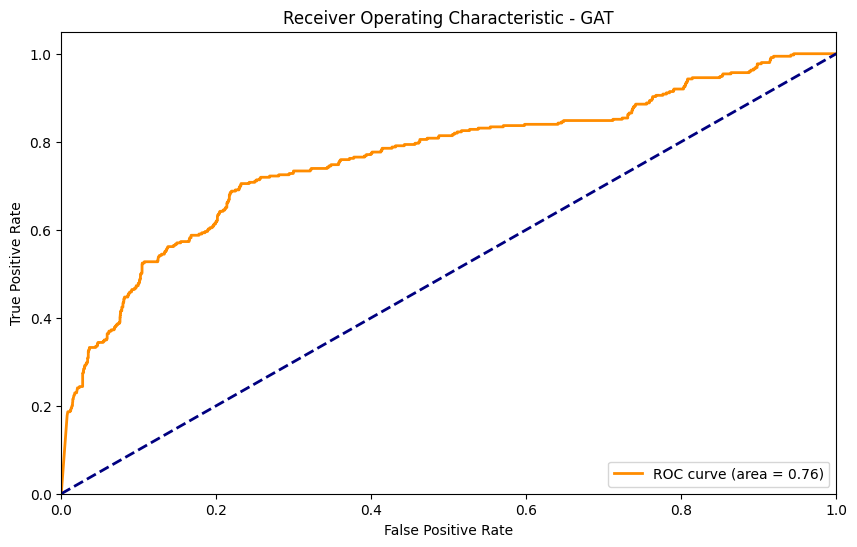

Epoch 1, Loss: 0.5204030303639692
Epoch 2, Loss: 0.26104727349543977
Epoch 3, Loss: 0.24543331456133874
Epoch 4, Loss: 0.2330062367590302
Epoch 5, Loss: 0.22853258804623353
Epoch 6, Loss: 0.22786030293268672
Epoch 7, Loss: 0.2255812367203377
Epoch 8, Loss: 0.22246114669714945
Epoch 9, Loss: 0.2227117065024578
Epoch 10, Loss: 0.22304602687136602
Epoch 11, Loss: 0.2208110558153209
Epoch 12, Loss: 0.22046506853174355
Epoch 13, Loss: 0.21621876014238697
Epoch 14, Loss: 0.2193592335965674
Epoch 15, Loss: 0.21604032893428357
Epoch 16, Loss: 0.21603611332632727
Epoch 17, Loss: 0.2140567350374945
Epoch 18, Loss: 0.2129148510047945
Epoch 19, Loss: 0.2148619597872435
Epoch 20, Loss: 0.21333824066539941


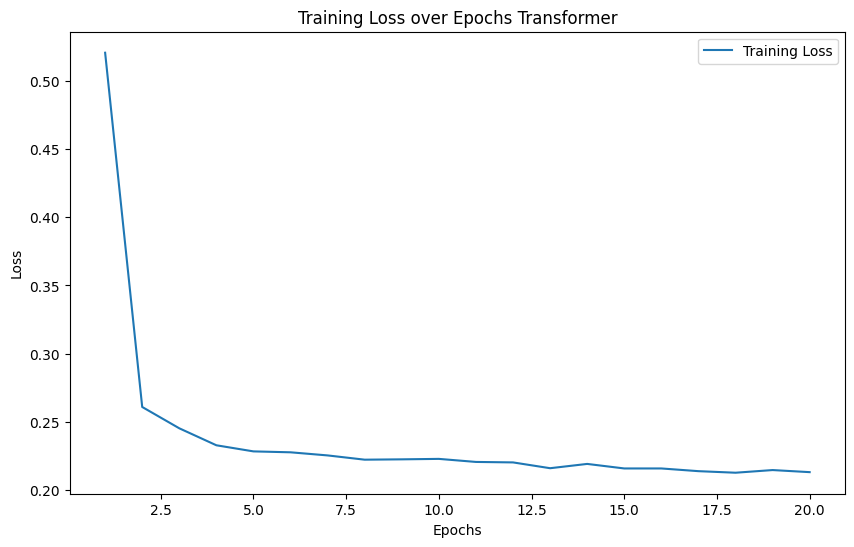

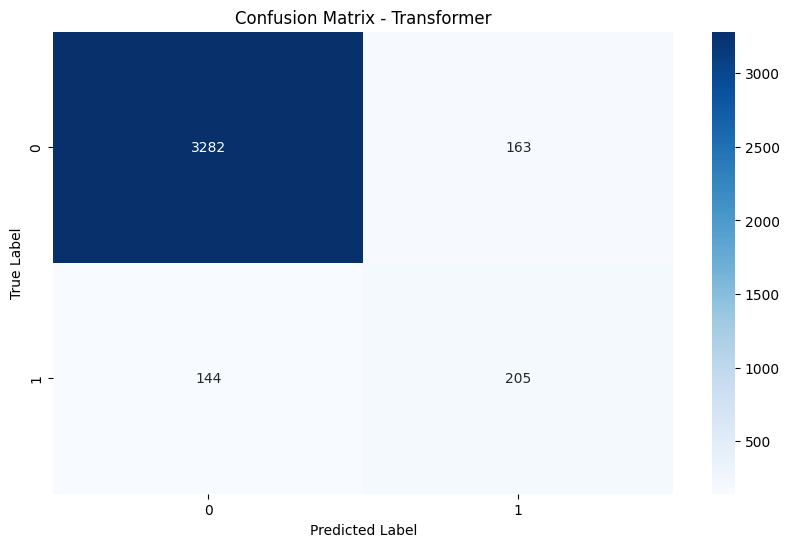

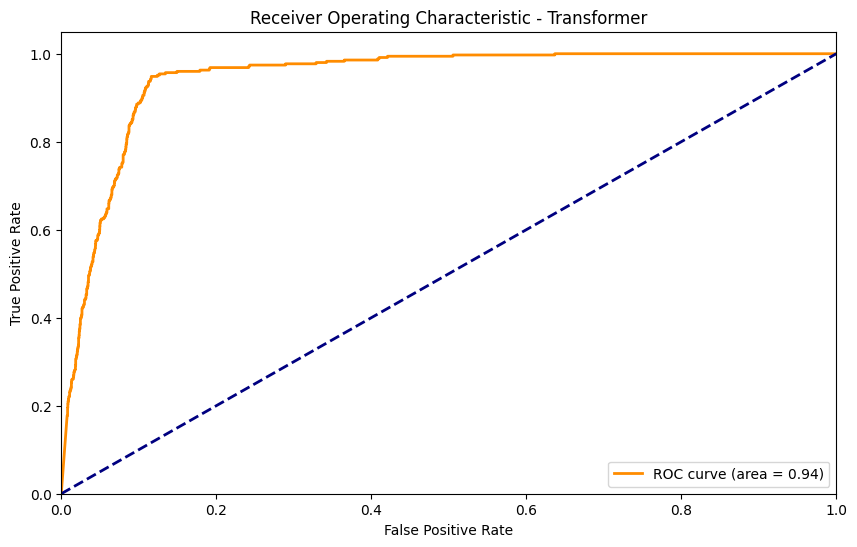

Epoch 1, Loss: 0.599542400594485
Epoch 2, Loss: 0.48155873028908747
Epoch 3, Loss: 0.41081232438653204
Epoch 4, Loss: 0.3747356792880317
Epoch 5, Loss: 0.36265891525199856
Epoch 6, Loss: 0.3528129496311737
Epoch 7, Loss: 0.3476945414381512
Epoch 8, Loss: 0.3414033401315495
Epoch 9, Loss: 0.33379547417921535
Epoch 10, Loss: 0.3344059690706811
Epoch 11, Loss: 0.3305330258809914
Epoch 12, Loss: 0.3287539075491792
Epoch 13, Loss: 0.3315463969641823
Epoch 14, Loss: 0.3319875987530765
Epoch 15, Loss: 0.328656533322597
Epoch 16, Loss: 0.32471801050133625
Epoch 17, Loss: 0.32436639948164003
Epoch 18, Loss: 0.32662112013263217
Epoch 19, Loss: 0.319486153138391
Epoch 20, Loss: 0.32312618656936337


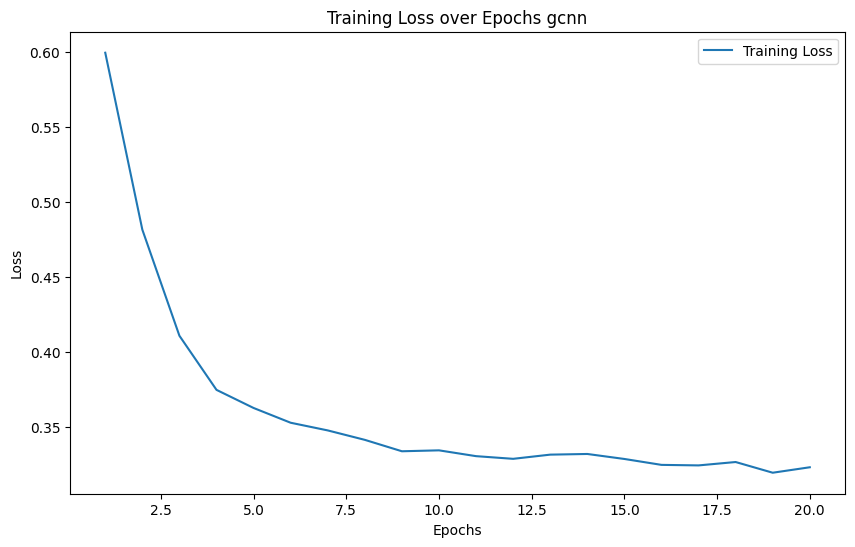

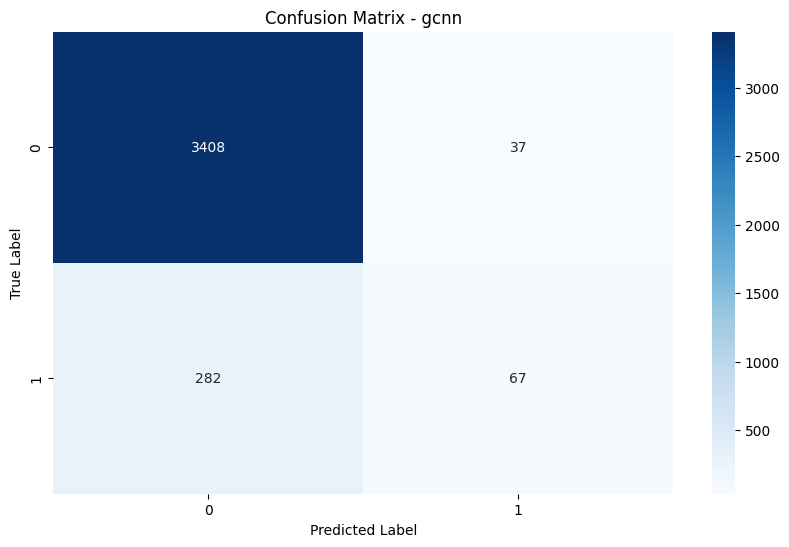

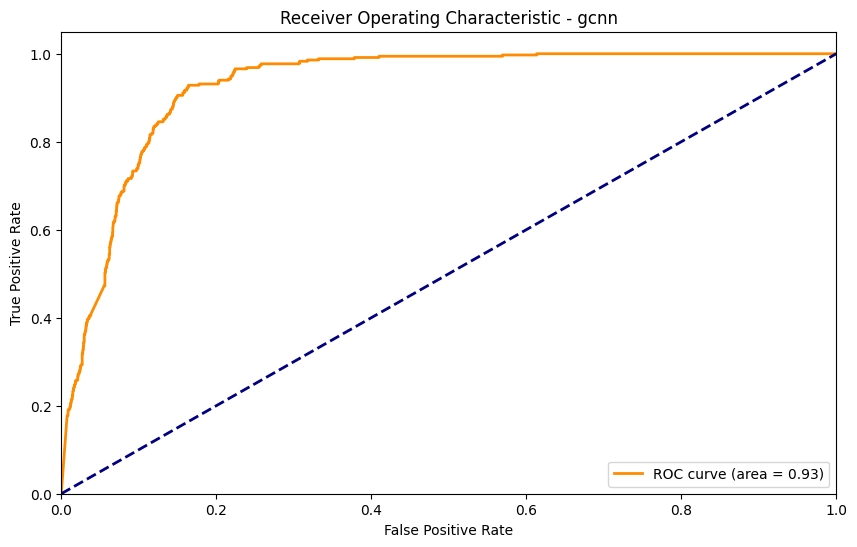

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}, 'type2_label_': {'GSageConv': 0.9315206445115811, 'GAT': 0.9330312185297079, 'GTransformer': 0.9284994964753273, 'GCNN': 0.9330312185297079}, 'type3_label_': {'GSageConv': 0.8913752913752914, 'GAT': 0.8652680652680653, 'GTransformer': 0.889044289044289, 'GCNN': 0.8652680652680653}, 'type4_label_': {'GSageConv': 0.931757359500446, 'GAT': 0.9415700267618198, 'GTransformer': 0.9411239964317574, 'GCNN': 0.9415700267618198}, 'type5_label_': {'GSageConv': 0.9377806286080821, 'GAT': 0.9441949967928159, 'GTransformer': 0.9445157152020526, 'GCNN': 0.9438742783835792}, 'type6_label_': {'GSageConv': 0.9242317616701853, 'GAT': 0.9343185550082101, 'GTransformer': 0.9270466807412621, 'GCNN': 0.9343185550082101}, 'type7_l

100%|██████████| 2304/2304 [03:31<00:00, 10.87it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.28793078858186216
Epoch 2, Loss: 0.17462784986869961
Epoch 3, Loss: 0.1680146532096699
Epoch 4, Loss: 0.1642436155245877
Epoch 5, Loss: 0.16101479451811196
Epoch 6, Loss: 0.1614390872053656
Epoch 7, Loss: 0.16052295908551006
Epoch 8, Loss: 0.1627677385238748
Epoch 9, Loss: 0.16126189147140466
Epoch 10, Loss: 0.16103473769537374
Epoch 11, Loss: 0.15944167157160302
Epoch 12, Loss: 0.16007091682039054
Epoch 13, Loss: 0.15813052709050038
Epoch 14, Loss: 0.15854573501821825
Epoch 15, Loss: 0.1569244363436512
Epoch 16, Loss: 0.15819927429159483
Epoch 17, Loss: 0.157241570124147
Epoch 18, Loss: 0.1584395134419787
Epoch 19, Loss: 0.15623228153323426
Epoch 20, Loss: 0.15557998174107543


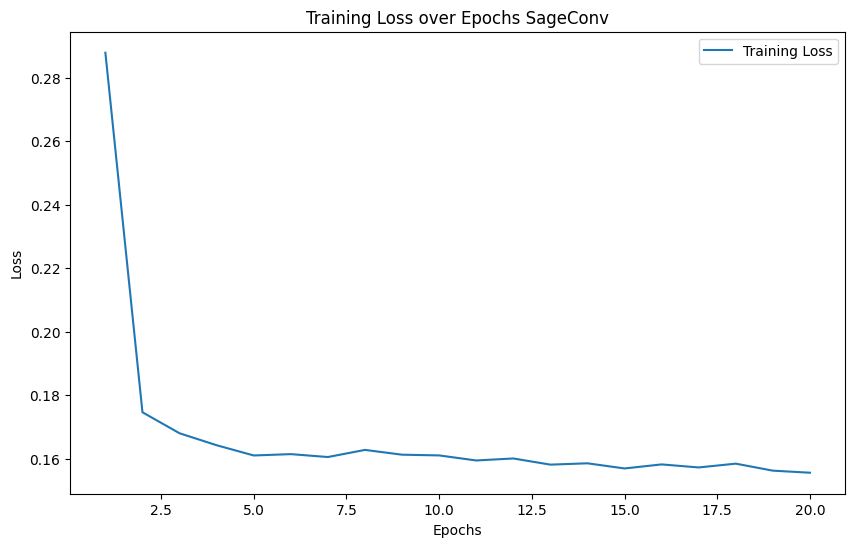

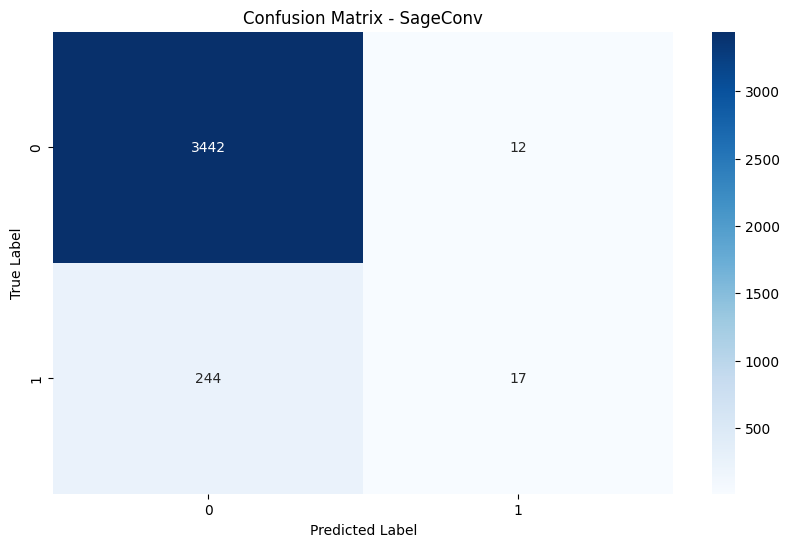

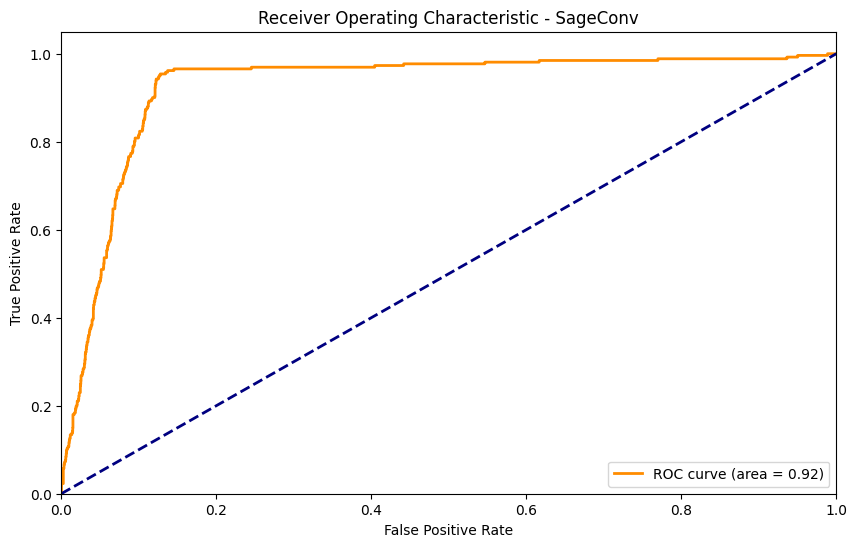

Epoch 1, Loss: 0.4514537604123938
Epoch 2, Loss: 0.26432640478014946
Epoch 3, Loss: 0.2667262936924018
Epoch 4, Loss: 0.2634378620514683
Epoch 5, Loss: 0.2622329142748141
Epoch 6, Loss: 0.26124059533079463
Epoch 7, Loss: 0.2589682274881531
Epoch 8, Loss: 0.2576363865359157
Epoch 9, Loss: 0.25662652848690165
Epoch 10, Loss: 0.25543271947432966
Epoch 11, Loss: 0.2548516321854264
Epoch 12, Loss: 0.2537363876460814
Epoch 13, Loss: 0.2529764585927421
Epoch 14, Loss: 0.2512197690997638
Epoch 15, Loss: 0.250237177400028
Epoch 16, Loss: 0.24924352465599192
Epoch 17, Loss: 0.24873199584145173
Epoch 18, Loss: 0.2477381959119264
Epoch 19, Loss: 0.24668910704991398
Epoch 20, Loss: 0.2452477405176443


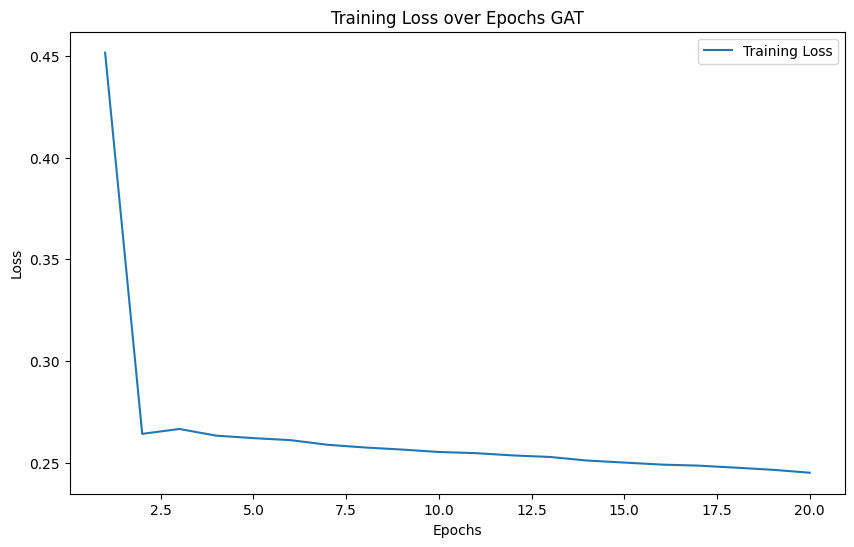

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

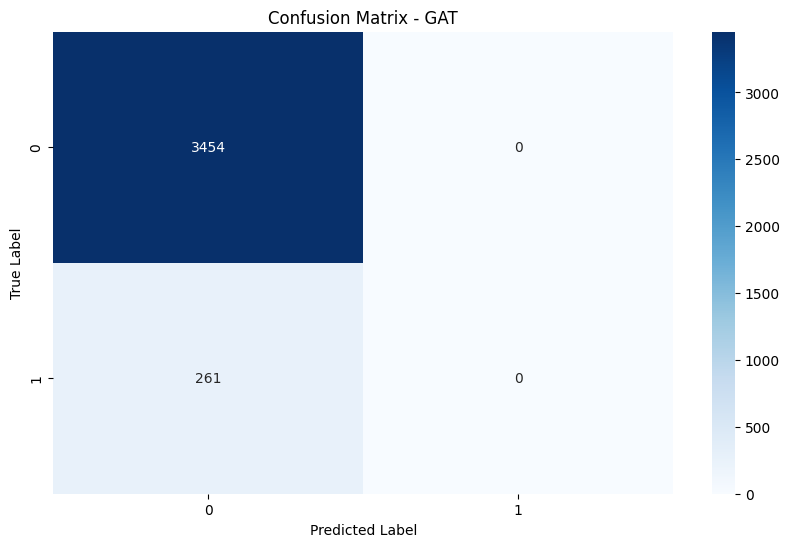

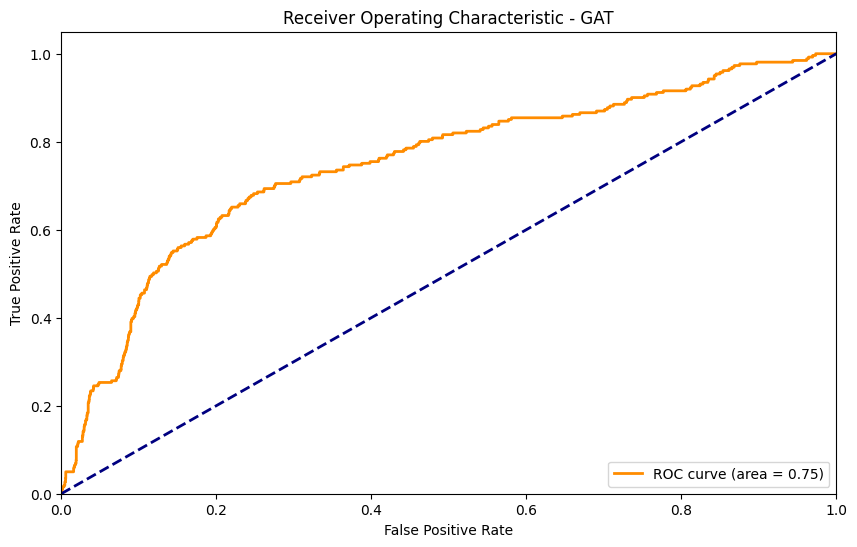

Epoch 1, Loss: 0.30553886664611307
Epoch 2, Loss: 0.17004424070610719
Epoch 3, Loss: 0.17129317769671187
Epoch 4, Loss: 0.16644421029908985
Epoch 5, Loss: 0.16232894346410154
Epoch 6, Loss: 0.16239907094003522
Epoch 7, Loss: 0.1613515677186204
Epoch 8, Loss: 0.16025891735711517
Epoch 9, Loss: 0.16064653481703764
Epoch 10, Loss: 0.16153021041742144
Epoch 11, Loss: 0.16397732003208468
Epoch 12, Loss: 0.160048936110209
Epoch 13, Loss: 0.16066380265150584
Epoch 14, Loss: 0.15995392340290196
Epoch 15, Loss: 0.15989761332086488
Epoch 16, Loss: 0.1583530291841895
Epoch 17, Loss: 0.15871658504885786
Epoch 18, Loss: 0.15819628138606454
Epoch 19, Loss: 0.1584702402937646
Epoch 20, Loss: 0.15728941161696816


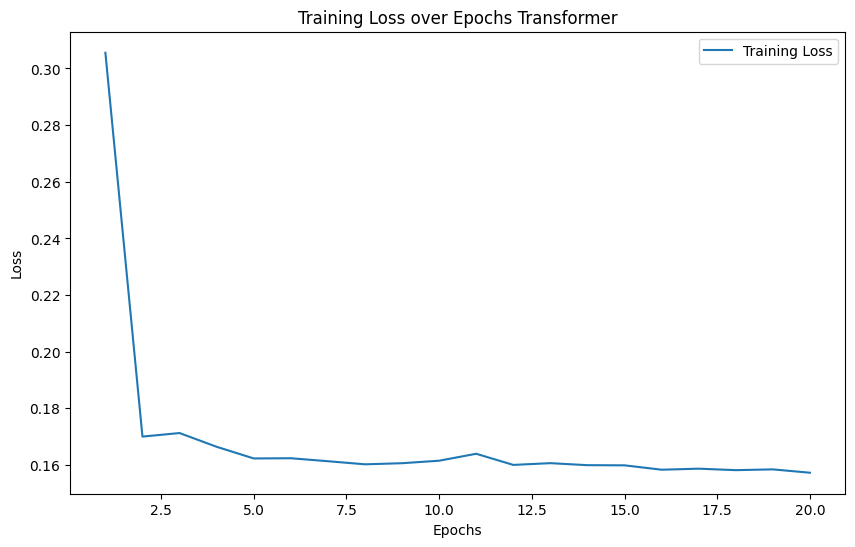

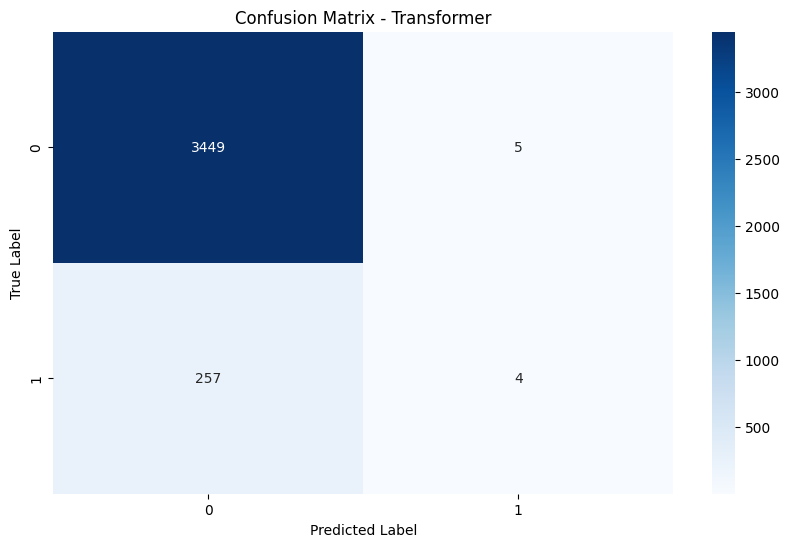

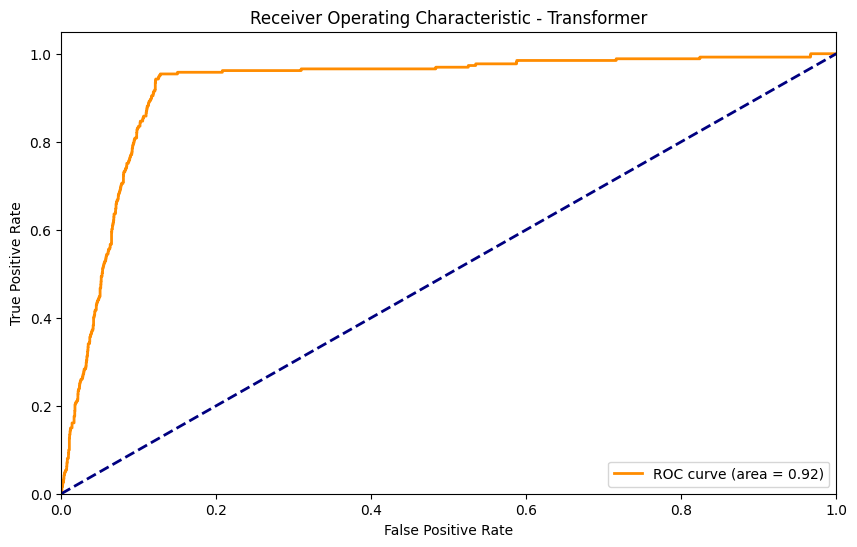

Epoch 1, Loss: 0.45502909068383424
Epoch 2, Loss: 0.2999237746584649
Epoch 3, Loss: 0.29656387777889476
Epoch 4, Loss: 0.28758065986867043
Epoch 5, Loss: 0.2759515980587286
Epoch 6, Loss: 0.26546339909819994
Epoch 7, Loss: 0.25443795936949115
Epoch 8, Loss: 0.24645984530741094
Epoch 9, Loss: 0.24109633705195258
Epoch 10, Loss: 0.23858585749186723
Epoch 11, Loss: 0.23792791739106178
Epoch 12, Loss: 0.2337071266682709
Epoch 13, Loss: 0.23016724260706528
Epoch 14, Loss: 0.22883383794596382
Epoch 15, Loss: 0.22651926395209396
Epoch 16, Loss: 0.22494596746914527
Epoch 17, Loss: 0.22191490711388634
Epoch 18, Loss: 0.22123722713805882
Epoch 19, Loss: 0.22054523594823539
Epoch 20, Loss: 0.21587156939009824


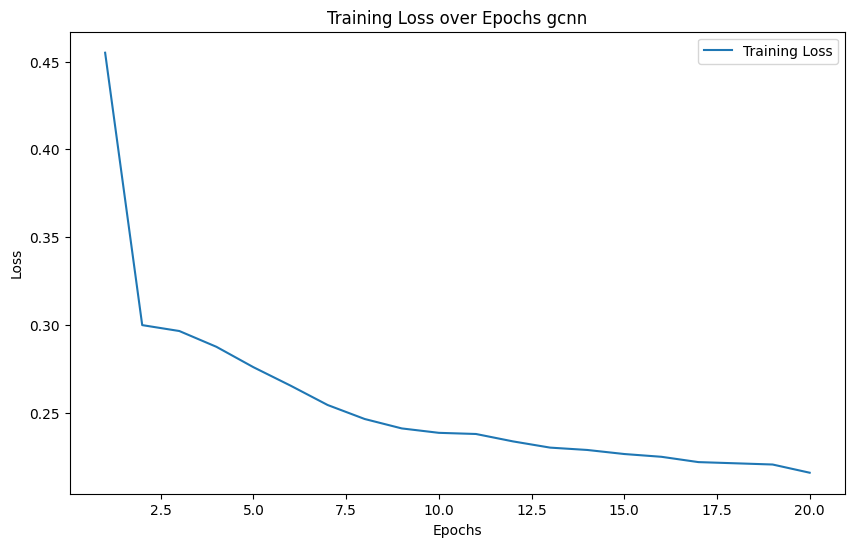

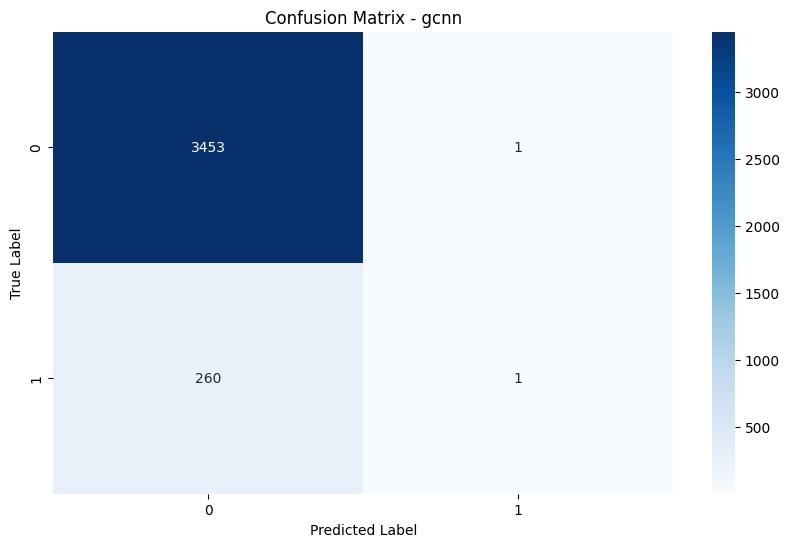

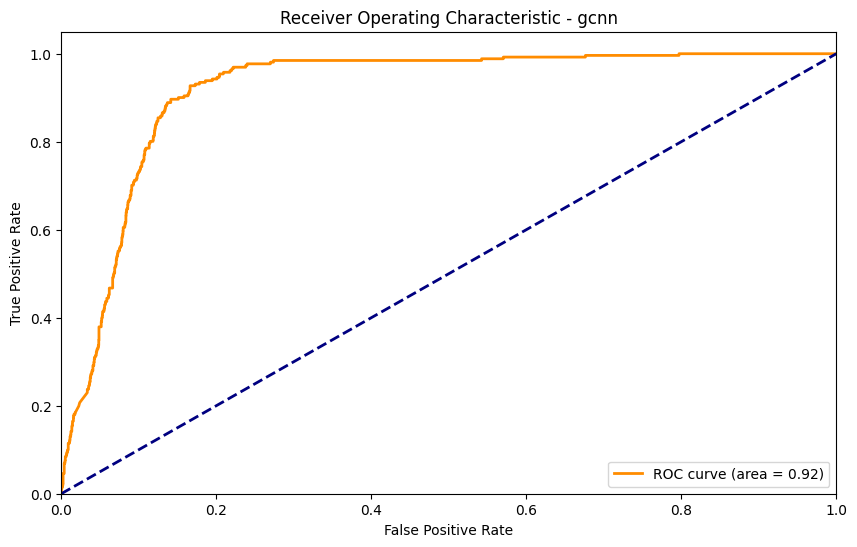

{'type10_label': {'GSageConv': 0.9097744360902256, 'GAT': 0.9293233082706767, 'GTransformer': 0.9136842105263158, 'GCNN': 0.9293233082706767}, 'type1_label_': {'GSageConv': 0.9016493585827734, 'GAT': 0.8631643249847282, 'GTransformer': 0.902871105681124, 'GCNN': 0.8631643249847282}, 'type2_label_': {'GSageConv': 0.9315206445115811, 'GAT': 0.9330312185297079, 'GTransformer': 0.9284994964753273, 'GCNN': 0.9330312185297079}, 'type3_label_': {'GSageConv': 0.8913752913752914, 'GAT': 0.8652680652680653, 'GTransformer': 0.889044289044289, 'GCNN': 0.8652680652680653}, 'type4_label_': {'GSageConv': 0.931757359500446, 'GAT': 0.9415700267618198, 'GTransformer': 0.9411239964317574, 'GCNN': 0.9415700267618198}, 'type5_label_': {'GSageConv': 0.9377806286080821, 'GAT': 0.9441949967928159, 'GTransformer': 0.9445157152020526, 'GCNN': 0.9438742783835792}, 'type6_label_': {'GSageConv': 0.9242317616701853, 'GAT': 0.9343185550082101, 'GTransformer': 0.9270466807412621, 'GCNN': 0.9343185550082101}, 'type7_l

PermissionError: [Errno 13] Permission denied: 'stage3_data_cleaning/v2\\~$type1_label_merged_final_decoded_clean3.xlsx'

In [39]:
new_execution_flag = assign_value()
if new_execution_flag == 1:
    current_time = time.localtime()
    folder_name = time.strftime("%Y-%m-%d_%H-%M-%S", current_time)
else:
    folder_name = input("Input folder name from all_execution_data")

result_dict = {}
for file_path in xlsx_files:
    

    if new_execution_flag == 1:
        data = pd.read_excel(file_path)
        data['can_id'] = data['can_id'].astype(str)
    
    label_key = os.path.basename(file_path).split('.')[0][0:12]
    print(label_key)

    output_dir = f"all_execution_data/{folder_name}/{label_key}/graphs"
    visualization_dir = os.path.join(f"all_execution_data/{folder_name}/{label_key}", "visualizations")
    result_dir =  os.path.join(f"all_execution_data/{folder_name}/{label_key}", "results")

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)
    
    if new_execution_flag == 1:
        pyg_data_list = preprocess_data(data,output_dir,visualization_dir)
    else:
        pyg_data_list = load_saved_graphs(output_dir)


    train_size = int(0.7 * len(pyg_data_list))
    train_data = pyg_data_list[:train_size]
    test_data = pyg_data_list[train_size:]

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    _,_,acc = run_SageConv(train_loader,test_loader,'SageConv',result_dir)
    _,_,gat_acc = run_GAT(train_loader,test_loader,'GAT',result_dir)
    _,_,transformer_acc = run_GTransformer(train_loader,test_loader,'Transformer',result_dir)
    # _,_,sageConv_lstm_acc =run_SageConv_lstm(train_loader,test_loader,'sageConv_lstm',result_dir)
    _,_,gcnn_acc =run_GCnn(train_loader,test_loader,'gcnn',result_dir)

    result_dict[label_key] = {
        'GSageConv': acc,
        'GAT': gat_acc,
        'GTransformer': transformer_acc,
        # 'GSage_conv_lstm': sageConv_lstm_acc,
        'GCNN': gcnn_acc
    }

    print(result_dict)



# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")



In [40]:
result_dict

{'type10_label': {'GSageConv': 0.9097744360902256,
  'GAT': 0.9293233082706767,
  'GTransformer': 0.9136842105263158,
  'GCNN': 0.9293233082706767},
 'type1_label_': {'GSageConv': 0.9016493585827734,
  'GAT': 0.8631643249847282,
  'GTransformer': 0.902871105681124,
  'GCNN': 0.8631643249847282},
 'type2_label_': {'GSageConv': 0.9315206445115811,
  'GAT': 0.9330312185297079,
  'GTransformer': 0.9284994964753273,
  'GCNN': 0.9330312185297079},
 'type3_label_': {'GSageConv': 0.8913752913752914,
  'GAT': 0.8652680652680653,
  'GTransformer': 0.889044289044289,
  'GCNN': 0.8652680652680653},
 'type4_label_': {'GSageConv': 0.931757359500446,
  'GAT': 0.9415700267618198,
  'GTransformer': 0.9411239964317574,
  'GCNN': 0.9415700267618198},
 'type5_label_': {'GSageConv': 0.9377806286080821,
  'GAT': 0.9441949967928159,
  'GTransformer': 0.9445157152020526,
  'GCNN': 0.9438742783835792},
 'type6_label_': {'GSageConv': 0.9242317616701853,
  'GAT': 0.9343185550082101,
  'GTransformer': 0.927046680

In [43]:

# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")

In [44]:
results_df

GSageConv       GAT  GTransformer      GCNN
type10_label   0.909774  0.929323      0.913684  0.929323
type1_label_   0.901649  0.863164      0.902871  0.863164
type2_label_   0.931521  0.933031      0.928499  0.933031
type3_label_   0.891375  0.865268      0.889044  0.865268
type4_label_   0.931757  0.941570      0.941124  0.941570
type5_label_   0.937781  0.944195      0.944516  0.943874
type6_label_   0.924232  0.934319      0.927047  0.934319
type7_label_   0.907978  0.889054      0.902041  0.889054
type8_label_   0.917501  0.917501      0.919083  0.915920
type9_label_   0.931090  0.929744      0.929475  0.929744